#**Analisis de Sentimientos:**
* Identificar si una frase es positiva o negativa

In [ ]:
import nltk
import numpy as np
import pandas as pd
import random as rnd
import os
from nltk.corpus import twitter_samples
nltk.download('twitter_samples')
nltk.download('stopwords')

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

##Base de datos:
* `twitter_samples`contiene subconjuntos de 5.000 tweets positivos, 5.000 negativos y el conjunto completo de 10.000 tweets.

In [ ]:
# Los tweets positivos y negativos
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

* Dividir la prueba de entrenamiento: el 20% estará en el conjunto de prueba y el 80% en el conjunto de entrenamiento.

In [ ]:
# dividir en dos set entrenamiento (Train) y validacion (Test)
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg
test_x = test_pos + test_neg

* Crear el array numpy de etiquetas positivas y etiquetas negativas.

In [ ]:
#Crear los labels
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

In [ ]:
# Print the shape train and test sets
print("train_y.shape = " + str(train_y.shape))
print("test_y.shape = " + str(test_y.shape))

train_y.shape = (8000, 1)
test_y.shape = (2000, 1)


###Funciones Auxiliares:
* `process_tweet()`: limpia el texto, lo tokeniza en palabras separadas, elimina las palabras vacías y convierte las palabras en tallos.

* `build_freqs()`:cuenta la frecuencia con la que una palabra del "corpus" (el conjunto de tweets) se asocia a una etiqueta positiva "1" o negativa "0", y construye el diccionario `freqs`, donde cada clave es una tupla (palabra,etiqueta), y el valor es el recuento de su frecuencia en el corpus de tweets.


In [ ]:
import re
import string
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer


def process_tweet(tweet):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean


def build_freqs(tweets, ys):
    """Build frequencies.
    Input:
        tweets: a list of tweets
        ys: an m x 1 array with the sentiment label of each tweet
            (either 0 or 1)
    Output:
        freqs: a dictionary mapping each (word, sentiment) pair to its
        frequency
    """
    # Convert np array to list since zip needs an iterable.
    # The squeeze is necessary or the list ends up with one element.
    # Also note that this is just a NOP if ys is already a list.
    yslist = np.squeeze(ys).tolist()

    # Start with an empty dictionary and populate it by looping over all tweets
    # and over all processed words in each tweet.
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

In [ ]:
#Crear el diccionario de frecuencias
freqs = build_freqs(train_x, train_y)

print("type(freqs) = " + str(type(freqs)))
print("len(freqs) = " + str(len(freqs.keys())))

type(freqs) = <class 'dict'>
len(freqs) = 11337


In [ ]:
# test the function below
print('This is an example of a positive tweet: \n', train_x[0])
print('\nThis is an example of the processed version of the tweet: \n', process_tweet(train_x[0]))

This is an example of a positive tweet: 
 #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)

This is an example of the processed version of the tweet: 
 ['followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)']


##Regression Logistica

### Part 1: Sigmoide
Vamos a  utilizar la regresión logística para la clasificación de textos.
* La función sigmoidea se define como:

$$ h(z) = \frac{1}{1+\exp^{-z}} \tag{1}$$

Asigna la entrada 'z' a un valor que oscila entre 0 y 1, por lo que puede tratarse como una probabilidad.

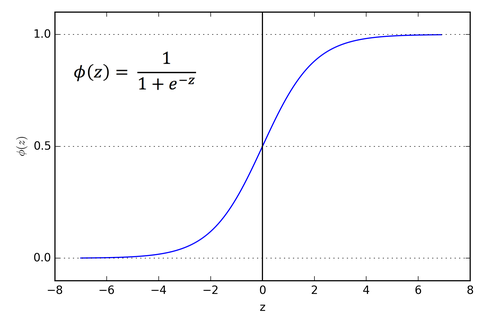


In [ ]:
def sigmoid(z):
    h = 1 / (1 + np.exp(-z))
    return h

In [ ]:
if (sigmoid(0) == 0.5):
    print('SUCCESS!')
else:
    print('Oops!')

if (sigmoid(4.92) == 0.9927537604041685):
    print('CORRECT!')
else:
    print('Oops again!')

SUCCESS!
CORRECT!


### Regresión logística: regresión y sigmoide

La regresión logística toma una regresión lineal normal y aplica una sigmoidea al resultado de la regresión lineal.

Regresión:
$$z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... \theta_N x_N$$

Tenga en cuenta que los valores $\theta$ son "pesos". Si tomaste la Especialización en Aprendizaje Profundo, nos referimos a los pesos con el vector `w`.  En este curso, estamos utilizando una variable diferente $\theta$ para referirse a los pesos.

Regresión logística:
$$ h(z) = \frac{1}{1+\exp^{-z}}$$
$$z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... \theta_N x_N$$

Nos referiremos a 'z' como 'logits'.

### Parte 2 Función de coste y gradiente

La función de coste utilizada para la regresión logística es la media de la pérdida logarítmica en todos los ejemplos de entrenamiento:
$$J(\theta) = -\frac{1}{m} \sum_{i=1}^m y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)}))\tag{5} $$
* $m$ es el número de ejemplos de entrenamiento
* $y^{(i)}$ es la etiqueta real del ejemplo de entrenamiento i-ésimo.
* $h(z(\theta)^{(i)})$ es la predicción del modelo para el ejemplo de entrenamiento i-ésimo.

La función de pérdida para un único ejemplo de entrenamiento es
$$ Loss = -1 \times \left( y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)})) \right)$$

* All the $h$ values are between 0 and 1, so the logs will be negative. That is the reason for the factor of -1 applied to the sum of the two loss terms.
* Note that when the model predicts 1 ($h(z(\theta)) = 1$) and the label $y$ is also 1, the loss for that training example is 0.
* Similarly, when the model predicts 0 ($h(z(\theta)) = 0$) and the actual label is also 0, the loss for that training example is 0.
* However, when the model prediction is close to 1 ($h(z(\theta)) = 0.9999$) and the label is 0, the second term of the log loss becomes a large negative number, which is then multiplied by the overall factor of -1 to convert it to a positive loss value. $-1 \times (1 - 0) \times log(1 - 0.9999) \approx 9.2$ The closer the model prediction gets to 1, the larger the loss.

In [ ]:
-1 * (1 - 0) * np.log(1 - 0.9999) # loss es aproximadamente 9.2

9.210340371976294

#### Actualizar los pesos

Para actualizar su vector de pesos $\theta$, aplicará el descenso de gradiente para mejorar iterativamente las predicciones de su modelo.  
El gradiente de la función de coste $J$ con respecto a uno de los pesos $\theta_j$ es:

$$\nabla_{\theta_j}J(\theta) = \frac{1}{m} \sum_{i=1}^m(h^{(i)}-y^{(i)})x_j \tag{5}$$
* 'i' es el índice de todos los 'm' ejemplos de entrenamiento.
* 'j' es el índice del peso $\theta_j$, por lo que $x_j$ es la característica asociada al peso $\theta_j$

* Para actualizar el peso $\theta_j$, lo ajustamos restando una fracción del gradiente determinada por $\alpha$:
$$\theta_j = \theta_j - \alpha \times \nabla_{\theta_j}J(\theta) $$
* La tasa de aprendizaje $\alpha$ es un valor que elegimos para controlar lo grande que será una sola actualización.

### Instrucciones: Implementar la función de descenso gradiente
* El número de iteraciones `num_iters` es el número de veces que se utilizará todo el conjunto de entrenamiento.
* En cada iteración, calcularás la función de coste usando todos los ejemplos de entrenamiento (hay `m` ejemplos de entrenamiento), y para todas las características.
* En lugar de actualizar un solo peso $\theta_i$ a la vez, podemos actualizar todos los pesos en el vector columna:
$$\mathbf{\theta} = \begin{pmatrix}
\theta_0
\\
\theta_1
\\
\theta_2
\\
\vdots
\\
\theta_n
\end{pmatrix}$$

* $\mathbf{\theta}$ tiene dimensiones (n+1, 1), donde 'n' es el número de características, y hay un elemento más para el término de sesgo $\theta_0$ (nótese que el valor de característica correspondiente $\mathbf{x_0}$ es 1).
* Los 'logits', 'z', se calculan multiplicando la matriz de características 'x' por el vector de pesos 'theta'.  $z = \mathbf{x}\mathbf{\theta}$.

    * $\mathbf{x}$ tiene dimensiones (m, n+1)
    * $\mathbf{\theta}$: tiene dimensioness (n+1, 1)
    * $\mathbf{z}$: tiene dimensiones (m, 1)

* La predicción "h" se calcula aplicando el sigmoide a cada elemento de "z": $h(z) = sigmoide(z)$, y tiene dimensiones (m,1).
* La función de coste $J$ se calcula tomando el producto punto de los vectores 'y' y 'log(h)'.  Dado que tanto "y" y "h" son vectores columna (m,1), transponer el vector a la izquierda, de modo que la multiplicación de matrices de un vector fila con vector columna realiza el producto escalar.

$$J = \frac{-1}{m} \times \left(\mathbf{y}^T \cdot log(\mathbf{h}) + \mathbf{(1-y)}^T \cdot log(\mathbf{1-h}) \right)$$

* La actualización de theta también se vectoriza.  Debido a que las dimensiones de $\mathbf{x}$ son (m, n+1), y tanto $\mathbf{h}$ y $\mathbf{y}$ son (m, 1), tenemos que transponer el $\mathbf{x}$ y colocarlo a la izquierda con el fin de realizar la multiplicación de matrices, que luego produce el (n+1, 1) respuesta que necesitamos:
$$\mathbf{\theta} = \mathbf{\theta} - \frac{\alpha}{m} \veces \left( \mathbf{x}^T \cdot \left( \mathbf{h-y} \right) \right)$$


In [ ]:
def gradientDescent(x, y, theta, alpha, num_iters):
    # obtener la dimension 'm', el numero de filas de la matriz x
    m = x.shape[0]

    for i in range(0, num_iters):

        # Obtener z, el producto punto x y theta
        z = np.dot(x,theta)

        # obtener el sigmoide of z
        h = sigmoid(z)

        # calcular la funcion de coste
        J = -1./m * (np.dot(y.T, np.log(h)) + np.dot((1-y).T,np.log(1-h)))

        # actualizar los pesos theta
        theta = theta - (alpha/m) * np.dot(x.T,(h-y))

    J = float(J)
    return J, theta

In [ ]:
np.random.seed(1)
# X input is 10 x 3 with ones for the bias terms
tmp_X = np.append(np.ones((10, 1)), np.random.rand(10, 2) * 2000, axis=1)
# Y Labels are 10 x 1
tmp_Y = (np.random.rand(10, 1) > 0.35).astype(float)

# Apply gradient descent
tmp_J, tmp_theta = gradientDescent(tmp_X, tmp_Y, np.zeros((3, 1)), 1e-8, 700)
print(f"The cost after training is {tmp_J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(tmp_theta)]}")

The cost after training is 0.67094970.
The resulting vector of weights is [4.1e-07, 0.00035658, 7.309e-05]


Salida esperada
```
The cost after training is 0.67094970.
The resulting vector of weights is [4.1e-07, 0.00035658, 7.309e-05]
```

### Parte 3: Extracción de las características

## Dada una lista de tweets, extraer las características y almacenarlas en una matriz. Extraerás dos características.
    * La primera es el número de palabras positivas en un tweet.
    * La segunda es el número de palabras negativas en un tweet.
* A continuación, entrena tu clasificador de regresión logística en estas características.
* Pruebe el clasificador en un conjunto de validación.

### Instrucciones: Implementar la función extract_features.
* Esta función toma un único tweet.
* Procesa el tweet usando la función importada `process_tweet()` y guarda la lista de palabras del tweet.
* Recorre cada palabra de la lista de palabras procesadas.
    * Para cada palabra, compruebe el diccionario `freqs` para el recuento cuando esa palabra tiene una etiqueta positiva '1'. (Busque la clave (palabra, 1.0)
    * Haga lo mismo para el recuento de cuando la palabra está asociada con la etiqueta negativa '0'. (Busque la clave (palabra, 0.0).)

In [ ]:
def extract_features(tweet, freqs):
    # process_tweet tokenizes, stems, y remover stopwords
    word_l = process_tweet(tweet)

    # 3 elementos en la forma de un vector de 1 x 3
    x = np.zeros((1, 3))

    #bias se inicializa en 1
    x[0,0] = 1

    for word in word_l:

        # incrementa la cuenta de palabras positivas label 1
        x[0,1] += freqs.get((word, 1.0),0)

        # incrementa la cuenta de palabras negativas label 0
        x[0,2] += freqs.get((word, 0.0),0)

    assert(x.shape == (1, 3))
    return x

In [ ]:
tmp1 = extract_features(train_x[0], freqs)
print(tmp1)

[[1.00e+00 3.02e+03 6.10e+01]]


In [ ]:
tmp2 = extract_features('blorb bleeeeb bloooob', freqs)
print(tmp2)

[[1. 0. 0.]]


### Parte 4: Entrenamiento del modelo

Para entrenar el modelo:
* Apila las características de todos los ejemplos de entrenamiento en una matriz `X`.
* Llame `gradientDescent`, que ha implementado anteriormente.

Esta sección se le da a usted.  Por favor, léela para entenderla y ejecuta la celda.

In [ ]:
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs)

Y = train_y

#gradient descent
J, theta = gradientDescent(X, Y, np.zeros((3, 1)), 1e-9, 1500)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")

The cost after training is 0.24215478.
The resulting vector of weights is [7e-08, 0.00052391, -0.00055517]


### Parte 4: Pruebe su regresión logística

Es hora de que pruebes tu función de regresión logística con algún dato nuevo que tu modelo no haya visto antes.

#### Instrucciones: Escribe `predict_tweet`.
Predecir si un tweet es positivo o negativo.

* Dado un tweet, procesarlo, a continuación, extraer las características.
* Aplica los pesos aprendidos del modelo a las características para obtener los logits.
* Aplicar el sigmoide a los logits para obtener la predicción (un valor entre 0 y 1).

$$y_{pred} = sigmoid(\mathbf{x} \cdot \theta)$$

In [ ]:
def predict_tweet(tweet, freqs, theta):

    # extract the features of the tweet and store it into x
    x = extract_features(tweet,freqs)

    # make the prediction using x and theta
    y_pred = sigmoid(np.dot(x,theta))

    return y_pred

In [ ]:
for tweet in ['I am happy', 'I am bad', 'this movie should have been great.', 'great', 'great great', 'great great great', 'great great great great']:
    print( '%s -> %f' % (tweet, predict_tweet(tweet, freqs, theta)))

I am happy -> 0.518581
I am bad -> 0.494339
this movie should have been great. -> 0.515331
great -> 0.515464
great great -> 0.530899
great great great -> 0.546274
great great great great -> 0.561562


In [ ]:
my_tweet = 'I am learning '
predict_tweet(my_tweet, freqs, theta)

array([[0.5003695]])

In [ ]:
my_tweet = 'I am not sad'
predict_tweet(my_tweet, freqs, theta)

array([[0.48677862]])

#### Comprobar el rendimiento con el conjunto de pruebas
Después de entrenar tu modelo utilizando el conjunto de entrenamiento anterior, comprueba el rendimiento de tu modelo con datos reales, no vistos, comparándolo con el conjunto de prueba.

#### Instrucciones: Implementar `test_logistic_regression`.
* Dados los datos de prueba y los pesos de tu modelo entrenado, calcula la precisión de tu modelo de regresión logística.
* Usa tu función `predict_tweet()` para hacer predicciones en cada tweet del conjunto de prueba.
* Si la predicción es > 0.5, establece la clasificación del modelo `y_hat` en 1, de lo contrario establece la clasificación del modelo `y_hat` en 0.
* Una predicción es exacta cuando `y_hat` es igual a `test_y`.  Sume todas las instancias cuando sean iguales y divídalas por `m`.

In [ ]:
def test_logistic_regression(test_x, test_y, freqs, theta):
    y_hat = []

    for tweet in test_x:
        y_pred = predict_tweet(tweet, freqs, theta)

        if y_pred > 0.5:
            # label 1 , positivo
            y_hat.append(1)
        else:
            # label 0 , negativo
            y_hat.append(0)

    accuracy = (y_hat==np.squeeze(test_y)).sum()/len(test_x)
    return accuracy

In [ ]:
tmp_accuracy = test_logistic_regression(test_x, test_y, freqs, theta)
print(f"Logistic regression model's accuracy = {tmp_accuracy:.4f}")

Logistic regression model's accuracy = 0.9950


### Parte 5: Análisis de errores

En esta parte verás algunos tweets que tu modelo clasificó erróneamente. ¿Por qué cree que se han producido estos errores de clasificación? Concretamente, ¿qué tipo de tuits clasifica mal tu modelo?

In [ ]:
print('Label Predicted Tweet')
for x,y in zip(test_x,test_y):
    y_hat = predict_tweet(x, freqs, theta)

    if np.abs(y - (y_hat > 0.5)) > 0:
        print('THE TWEET IS:', x)
        print('THE PROCESSED TWEET IS:', process_tweet(x))
        print('%d\t%0.8f\t%s' % (y, y_hat, ' '.join(process_tweet(x)).encode('ascii', 'ignore')))

Label Predicted Tweet
THE TWEET IS: @jaredNOTsubway @iluvmariah @Bravotv Then that truly is a LATERAL move! Now, we all know the Queen Bee is UPWARD BOUND : ) #MovingOnUp
THE PROCESSED TWEET IS: ['truli', 'later', 'move', 'know', 'queen', 'bee', 'upward', 'bound', 'movingonup']
1	0.49996920	b'truli later move know queen bee upward bound movingonup'
THE TWEET IS: @MarkBreech Not sure it would be good thing 4 my bottom daring 2 say 2 Miss B but Im gonna be so stubborn on mouth soaping ! #NotHavingit :p
THE PROCESSED TWEET IS: ['sure', 'would', 'good', 'thing', '4', 'bottom', 'dare', '2', 'say', '2', 'miss', 'b', 'im', 'gonna', 'stubborn', 'mouth', 'soap', 'nothavingit', ':p']
1	0.48663815	b'sure would good thing 4 bottom dare 2 say 2 miss b im gonna stubborn mouth soap nothavingit :p'
THE TWEET IS: I'm playing Brain Dots : ) #BrainDots
http://t.co/UGQzOx0huu
THE PROCESSED TWEET IS: ["i'm", 'play', 'brain', 'dot', 'braindot']
1	0.48370697	b"i'm play brain dot braindot"
THE TWEET IS: I'm p

### Parte 6: Predecir con tu propio tweet

In [ ]:
my_tweet = 'This is a ridiculously bright movie. The plot was terrible and I was sad until the ending!'
print(process_tweet(my_tweet))
y_hat = predict_tweet(my_tweet, freqs, theta)
print(y_hat)
if y_hat > 0.5:
    print('Positive sentiment')
else:
    print('Negative sentiment')

['ridicul', 'bright', 'movi', 'plot', 'terribl', 'sad', 'end']
[[0.48139084]]
Negative sentiment


##**Naive Bayes**
Naive bayes es un algoritmo que puede utilizarse para el análisis de sentimientos. Tarda poco en entrenarse y también tiene un tiempo de predicción corto.

#### ¿Cómo se entrena un clasificador Naive Bayes?
- La primera parte del entrenamiento de un clasificador bayes ingenuo es identificar el número de clases que tiene.
- Se creará una probabilidad para cada clase.
P(D_{pos})$ es la probabilidad de que el documento sea positivo.
P(D_{neg})$ es la probabilidad de que el documento sea negativo.
Utilice las fórmulas de la siguiente manera y almacene los valores en un diccionario:

$$P(D_{pos}) = \frac{D_{pos}}{D}\tag{1}$$

$$P(D_{neg}) = \frac{D_{neg}}{D}tag{2}$$

Donde $D$ es el número total de documentos, o tweets en este caso, $D_{pos}$ es el número total de tweets positivos y $D_{neg}$ es el número total de tweets negativos.

###Parte 1:
 algunas funciones auxiliares para el preproprocesamiento de la informacion:
  * Función de ayuda `lookup()` que toma el diccionario `freqs`, una palabra y una etiqueta (1 o 0) y devuelve el número de veces que esa tupla de palabra y etiqueta aparece en la colección de tweets.
  * Función `count_tweets()` que toma una lista de tweets como entrada, los limpia todos y devuelve un diccionario.

In [ ]:
def lookup(freqs, word, label):
    n = 0  # freqs.get((word, label), 0)

    pair = (word, label)
    if (pair in freqs):
        n = freqs[pair]

    return n

def count_tweets(result, tweets, ys):
    for y, tweet in zip(ys, tweets):
        for word in process_tweet(tweet):
            pair = (word,y)
            if pair in result:
                result[pair] += 1
            else:
                result[pair] = 1

    return result

In [ ]:
result = {}
tweets = ['i am happy', 'i am tricked', 'i am sad', 'i am tired', 'i am tired']
ys = [1, 0, 0, 0, 0]
count_tweets(result, tweets, ys)

{('happi', 1): 1, ('trick', 0): 1, ('sad', 0): 1, ('tire', 0): 2}

In [ ]:
train_y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))
test_y = np.append(np.ones(len(test_pos)), np.zeros(len(test_neg)))

###Parte 2: Entrenamiento
#### Prior y Logprior

La probabilidad a priori representa la probabilidad subyacente en la población objetivo de que un tuit sea positivo frente a negativo.  En otras palabras, si no tuviéramos información específica y eligiéramos a ciegas un tuit del conjunto de la población, ¿cuál es la probabilidad de que sea positivo frente a la de que sea negativo? Eso es la "probabilidad a priori".

La probabilidad a priori es el cociente de las probabilidades $\frac{P(D_{pos})}{P(D_{neg})}$.
Podemos tomar el logaritmo de la prioridad para cambiar su escala, y vamos a llamar a esto el logprior

$$\text{logprior} = log \left( \frac{P(D_{pos})}{P(D_{neg})} \right) = log \left( \frac{D_{pos}}{D_{neg}} \right)$$.

Obsérvese que $log(\frac{A}{B})$ es lo mismo que $log(A) - log(B)$.  Así que el logprior también se puede calcular como la diferencia entre dos logaritmos:

$$\text{logprior} = log (P(D_{pos})) - log (P(D_{neg})) = log (D_{pos}) - log (D_{neg})\tag{3}$$

#### Probabilidad positiva y negativa de una palabra
Para calcular la probabilidad positiva y la probabilidad negativa de una palabra específica del vocabulario, utilizaremos las siguientes entradas:

- $freq_{pos}$ y $freq_{neg}$ son las frecuencias de esa palabra específica en la clase positiva o negativa. En otras palabras, la frecuencia positiva de una palabra es el número de veces que la palabra se cuenta con la etiqueta 1.
- $N_{pos}$ y $N_{neg}$ son el número total de palabras positivas y negativas para todos los documentos (para todos los tweets), respectivamente.
- $V$ es el número de palabras únicas en todo el conjunto de documentos, para todas las clases, ya sean positivas o negativas.

Utilizaremos estos valores para calcular la probabilidad positiva y negativa de una palabra específica mediante esta fórmula:

$$ P(W_{pos}) = \frac{freq_{pos} + 1}{N_{pos} + V}\tag{4} $$
$$ P(W_{neg}) = \frac{freq_{neg} + 1}{N_{neg} + V}\tag{5} $$

Nótese que añadimos el "+1" en el numerador para el suavizado aditivo.  Este [artículo wiki](https://en.wikipedia.org/wiki/Additive_smoothing) explica más sobre el suavizado aditivo.

#### Log-verosimilitud
Para calcular la loglikelihood de esa misma palabra, podemos implementar las siguientes ecuaciones:

$$\text{loglikelihood} = \log \left(\frac{P(W_{pos})}{P(W_{neg})} \right)\tag{6}$$

In [ ]:
def train_naive_bayes(freqs, train_x, train_y):
    loglikelihood = {}
    logprior = 0
    # calculate V, the number of unique words in the vocabulary
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)

    # calculate N_pos, N_neg, V_pos, V_neg
    N_pos = N_neg = V_pos = V_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] > 0:
            # increment the count of unique positive words by 1
            V_pos += 1

            # Increment the number of positive words by the count for this (word, label) pair
            N_pos += freqs[pair]

        # else, the label is negative
        else:
            # increment the count of unique negative words by 1
            V_neg += 1

            # increment the number of negative words by the count for this (word,label) pair
            N_neg += freqs[pair]

    # Calculate D, the number of documents
    D = len(train_y)

    # Calculate D_pos, the number of positive documents
    D_pos = (len(list(filter(lambda x: x > 0, train_y))))

    # Calculate D_neg, the number of negative documents
    D_neg = (len(list(filter(lambda x: x <= 0, train_y))))

    # Calculate logprior
    logprior = np.log(D_pos) - np.log(D_neg)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = lookup(freqs,word,1)
        freq_neg = lookup(freqs,word,0)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1) / (N_pos + V)
        p_w_neg = (freq_neg + 1) / (N_neg + V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos/p_w_neg)

    return logprior, loglikelihood

In [ ]:
result = {}
freqs = count_tweets(result, train_x, train_y)

In [ ]:
logprior, loglikelihood = train_naive_bayes(freqs, train_x, train_y)
print(logprior)
print(len(loglikelihood))

0.0
9085


### Parte 3: Prueba tu naive bayes

Ahora que tenemos los valores `logprior` y `loglikelihood`, podemos probar la función naive bayes haciendo predicciones sobre algunos tweets.

#### Implementar `naive_bayes_predict`
**Instrucciones**:
Implementa la función `naive_bayes_predict` para hacer predicciones sobre tweets.
* La función toma los datos `tweet`, `logprior`, `loglikelihood`.
* Devuelve la probabilidad de que el tweet pertenezca a la clase positiva o negativa.
* Para cada tweet, suma las loglikelihoods de cada palabra del tweet.
* También añade el logprior a esta suma para obtener el sentimiento predicho de ese tweet.

$$ p = logprior + \sum_i^N (loglikelihood_i)$$

#### Nota
Tenga en cuenta que calculamos la prioridad a partir de los datos de entrenamiento, y que los datos de entrenamiento se dividen por igual entre etiquetas positivas y negativas (4000 tweets positivos y 4000 negativos).  Esto significa que la proporción entre positivos y negativos es 1, y el logprior es 0.

El valor de 0,0 significa que cuando añadimos el logprior a la logverosimilitud, sólo estamos añadiendo cero a la logverosimilitud.  Sin embargo, recuerde incluir el logprior, porque siempre que los datos no estén perfectamente equilibrados, el logprior tendrá un valor distinto de cero.

In [ ]:
def naive_bayes_predict(tweet, logprior, loglikelihood):
    # process the tweet to get a list of words
    word_l = process_tweet(tweet)

    # initialize probability to zero
    p = 0

    # add the logprior
    p += logprior

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            p += loglikelihood[word]
    return p

In [ ]:
my_tweet = 'She smiled.'
p = naive_bayes_predict(my_tweet, logprior, loglikelihood)
print('The expected output is', p)

The expected output is 1.5737244858565678


In [ ]:
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    y_hats = []
    for tweet in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(tweet, logprior, loglikelihood) > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y
    error = np.mean(np.absolute(y_hats-test_y))

    # Accuracy is 1 minus the error
    accuracy = 1-error
    return accuracy

In [ ]:
print("Naive Bayes accuracy = %0.4f" %
      (test_naive_bayes(test_x, test_y, logprior, loglikelihood)))

Naive Bayes accuracy = 0.9940


In [ ]:
for tweet in ['I am happy', 'I am bad', 'this movie should have been great.', 'great', 'great great', 'great great great', 'great great great great']:
    # print( '%s -> %f' % (tweet, naive_bayes_predict(tweet, logprior, loglikelihood)))
    p = naive_bayes_predict(tweet, logprior, loglikelihood)
#     print(f'{tweet} -> {p:.2f} ({p_category})')
    print(f'{tweet} -> {p:.2f}')

I am happy -> 2.15
I am bad -> -1.29
this movie should have been great. -> 2.14
great -> 2.14
great great -> 4.28
great great great -> 6.41
great great great great -> 8.55


In [ ]:
my_tweet = 'you are bad'
naive_bayes_predict(my_tweet, logprior, loglikelihood)

-1.2941744161875384

In [ ]:
my_tweet = 'I am not sad'
naive_bayes_predict(my_tweet, logprior, loglikelihood)

-2.8182524796704818

###Parte 4: Filtrar palabras por Relación entre recuentos positivos y negativos

- Algunas palabras tienen más recuentos positivos que otras, y pueden considerarse "más positivas".  Del mismo modo, algunas palabras pueden considerarse más negativas que otras.
- Una forma de definir el nivel de positividad o negatividad, sin calcular la probabilidad logarítmica, es comparar la frecuencia positiva y negativa de la palabra.
    - Tenga en cuenta que también podemos utilizar los cálculos de probabilidad logarítmica para comparar la positividad o negatividad relativa de las palabras.
- Podemos calcular la relación entre las frecuencias positivas y negativas de una palabra.
- Una vez que somos capaces de calcular estos ratios, también podemos filtrar un subconjunto de palabras que tengan un ratio mínimo de positividad / negatividad o superior.
- Del mismo modo, también podemos filtrar un subconjunto de palabras que tienen una relación máxima de positividad / negatividad o inferior (palabras que son al menos tan negativas, o incluso más negativas que un umbral dado).

#### `get_ratio()`
- Dado el diccionario de palabras `freqs` y una palabra concreta, utiliza `lookup(freqs,palabra,1)` para obtener el recuento positivo de la palabra.
- Del mismo modo, utilice la función `lookup()` para obtener el recuento negativo de esa palabra.
- Calcule la relación entre los recuentos positivos y los negativos

$$ ratio = \frac{\text{pos_words} + 1}{\text{neg_words} + 1} $$

Donde pos_palabras y neg_palabras corresponden a la frecuencia de las palabras en sus respectivas clases.

<table>
    <tr>
        <td>
            <b>Words</b>
        </td>
        <td>
        Positive word count
        </td>
         <td>
        Negative Word Count
        </td>
  </tr>
    <tr>
        <td>
        glad
        </td>
         <td>
        41
        </td>
    <td>
        2
        </td>
  </tr>
    <tr>
        <td>
        arriv
        </td>
         <td>
        57
        </td>
    <td>
        4
        </td>
  </tr>
    <tr>
        <td>
        :(
        </td>
         <td>
        1
        </td>
    <td>
        3663
        </td>
  </tr>
    <tr>
        <td>
        :-(
        </td>
         <td>
        0
        </td>
    <td>
        378
        </td>
  </tr>
</table>

In [ ]:
def get_ratio(freqs, word):
    pos_neg_ratio = {'positive': 0, 'negative': 0, 'ratio': 0.0}
    # use lookup() to find positive counts for the word (denoted by the integer 1)
    pos_neg_ratio['positive'] = lookup(freqs,word,1)

    # use lookup() to find negative counts for the word (denoted by integer 0)
    pos_neg_ratio['negative'] = lookup(freqs,word,0)

    # calculate the ratio of positive to negative counts for the word
    pos_neg_ratio['ratio'] = (pos_neg_ratio['positive'] + 1)/(pos_neg_ratio['negative'] + 1)
    return pos_neg_ratio

In [ ]:
get_ratio(freqs, 'happi')

{'positive': 161, 'negative': 18, 'ratio': 8.526315789473685}

In [ ]:
def get_words_by_threshold(freqs, label, threshold):
    word_list = {}

    for key in freqs.keys():
        word, _ = key

        # get the positive/negative ratio for a word
        pos_neg_ratio = get_ratio(freqs, word)

        # if the label is 1 and the ratio is greater than or equal to the threshold...
        if label == 1 and pos_neg_ratio['ratio'] >= threshold :

            # Add the pos_neg_ratio to the dictionary
            word_list[word] = pos_neg_ratio

        # If the label is 0 and the pos_neg_ratio is less than or equal to the threshold...
        elif label == 0 and pos_neg_ratio['ratio'] <= threshold:
            # Add the pos_neg_ratio to the dictionary
            word_list[word] = pos_neg_ratio

        # otherwise, do not include this word in the list (do nothing)

    return word_list


In [ ]:
get_words_by_threshold(freqs, label=0, threshold=0.05)

{':(': {'positive': 1, 'negative': 3663, 'ratio': 0.0005458515283842794},
 ':-(': {'positive': 0, 'negative': 378, 'ratio': 0.002638522427440633},
 'zayniscomingbackonjuli': {'positive': 0, 'negative': 19, 'ratio': 0.05},
 '26': {'positive': 0, 'negative': 20, 'ratio': 0.047619047619047616},
 '>:(': {'positive': 0, 'negative': 43, 'ratio': 0.022727272727272728},
 'lost': {'positive': 0, 'negative': 19, 'ratio': 0.05},
 '♛': {'positive': 0, 'negative': 210, 'ratio': 0.004739336492890996},
 '》': {'positive': 0, 'negative': 210, 'ratio': 0.004739336492890996},
 'beli̇ev': {'positive': 0, 'negative': 35, 'ratio': 0.027777777777777776},
 'wi̇ll': {'positive': 0, 'negative': 35, 'ratio': 0.027777777777777776},
 'justi̇n': {'positive': 0, 'negative': 35, 'ratio': 0.027777777777777776},
 'ｓｅｅ': {'positive': 0, 'negative': 35, 'ratio': 0.027777777777777776},
 'ｍｅ': {'positive': 0, 'negative': 35, 'ratio': 0.027777777777777776}}

In [ ]:
get_words_by_threshold(freqs, label=1, threshold=10)

{'followfriday': {'positive': 23, 'negative': 0, 'ratio': 24.0},
 'commun': {'positive': 27, 'negative': 1, 'ratio': 14.0},
 ':)': {'positive': 2847, 'negative': 2, 'ratio': 949.3333333333334},
 'flipkartfashionfriday': {'positive': 16, 'negative': 0, 'ratio': 17.0},
 ':d': {'positive': 498, 'negative': 0, 'ratio': 499.0},
 ':p': {'positive': 104, 'negative': 0, 'ratio': 105.0},
 'influenc': {'positive': 16, 'negative': 0, 'ratio': 17.0},
 ':-)': {'positive': 543, 'negative': 0, 'ratio': 544.0},
 "here'": {'positive': 20, 'negative': 0, 'ratio': 21.0},
 'youth': {'positive': 14, 'negative': 0, 'ratio': 15.0},
 'bam': {'positive': 44, 'negative': 0, 'ratio': 45.0},
 'warsaw': {'positive': 44, 'negative': 0, 'ratio': 45.0},
 'shout': {'positive': 11, 'negative': 0, 'ratio': 12.0},
 ';)': {'positive': 22, 'negative': 0, 'ratio': 23.0},
 'stat': {'positive': 51, 'negative': 0, 'ratio': 52.0},
 'arriv': {'positive': 57, 'negative': 4, 'ratio': 11.6},
 'via': {'positive': 60, 'negative': 1, 

### Parte 5: Análisis de errores

En esta parte verás algunos tweets que tu modelo clasificó erróneamente. ¿Por qué cree que se produjeron los errores de clasificación? ¿Había alguna suposición hecha por el modelo bayes ingenuo?

In [ ]:
print('Truth Predicted Tweet')
for x, y in zip(test_x, test_y):
    y_hat = naive_bayes_predict(x, logprior, loglikelihood)
    if y != (np.sign(y_hat) > 0):
        print('%d\t%0.2f\t%s' % (y, np.sign(y_hat) > 0, ' '.join(
            process_tweet(x)).encode('ascii', 'ignore')))

Truth Predicted Tweet
1	0.00	b''
1	0.00	b'truli later move know queen bee upward bound movingonup'
1	0.00	b'new report talk burn calori cold work harder warm feel better weather :p'
1	0.00	b'harri niall 94 harri born ik stupid wanna chang :d'
1	0.00	b''
1	0.00	b''
1	0.00	b'park get sunlight'
1	0.00	b'uff itna miss karhi thi ap :p'
0	1.00	b'hello info possibl interest jonatha close join beti :( great'
0	1.00	b'u prob fun david'
0	1.00	b'pat jay'
0	1.00	b'whatev stil l young >:-('


### Parte 6: Predecir con tu propio tweet

En esta parte puedes predecir el sentimiento de tu propio tweet.

In [ ]:
my_tweet = 'I am happy because I am learning :)'

p = naive_bayes_predict(my_tweet, logprior, loglikelihood)
print(p)

9.57385883169329


## **Deep Neural Networks:**

###Parte 1: Construir el vocabulario

Construye ahora el vocabulario.
- Asigna cada palabra de cada tweet a un número entero (un "índice").
- El siguiente código lo hace por ti, pero por favor, léelo y entiende lo que está haciendo.
- Ten en cuenta que construirás el vocabulario basándote en los datos de entrenamiento.
- Para ello, asignarás un índice a cada palabra iterando sobre tu conjunto de entrenamiento.

El vocabulario también incluirá algunos tokens especiales
- `__PAD__`: relleno
- fin de línea
- `__UNK__`: un token que representa cualquier palabra que no esté en el vocabulario.

In [ ]:
Vocab = {'__PAD__': 0, '__</e>__': 1, '__UNK__': 2}

# Note that we build vocab using training data
for tweet in train_x:
    processed_tweet = process_tweet(tweet)
    for word in processed_tweet:
        if word not in Vocab:
            Vocab[word] = len(Vocab)

print("Total words in vocab are",len(Vocab))
display(Vocab)

Total words in vocab are 9088


{'__PAD__': 0,
 '__</e>__': 1,
 '__UNK__': 2,
 'followfriday': 3,
 'top': 4,
 'engag': 5,
 'member': 6,
 'commun': 7,
 'week': 8,
 ':)': 9,
 'hey': 10,
 'jame': 11,
 'odd': 12,
 ':/': 13,
 'pleas': 14,
 'call': 15,
 'contact': 16,
 'centr': 17,
 '02392441234': 18,
 'abl': 19,
 'assist': 20,
 'mani': 21,
 'thank': 22,
 'listen': 23,
 'last': 24,
 'night': 25,
 'bleed': 26,
 'amaz': 27,
 'track': 28,
 'scotland': 29,
 'congrat': 30,
 'yeaaah': 31,
 'yipppi': 32,
 'accnt': 33,
 'verifi': 34,
 'rqst': 35,
 'succeed': 36,
 'got': 37,
 'blue': 38,
 'tick': 39,
 'mark': 40,
 'fb': 41,
 'profil': 42,
 '15': 43,
 'day': 44,
 'one': 45,
 'irresist': 46,
 'flipkartfashionfriday': 47,
 'like': 48,
 'keep': 49,
 'love': 50,
 'custom': 51,
 'wait': 52,
 'long': 53,
 'hope': 54,
 'enjoy': 55,
 'happi': 56,
 'friday': 57,
 'lwwf': 58,
 'second': 59,
 'thought': 60,
 '’': 61,
 'enough': 62,
 'time': 63,
 'dd': 64,
 'new': 65,
 'short': 66,
 'enter': 67,
 'system': 68,
 'sheep': 69,
 'must': 70,
 'buy':

####Convertir un tweet en un tensor

Escribe una función que convierta cada tweet en un tensor (una lista de IDs enteros únicos que representen el tweet procesado).
- Ten en cuenta que el tipo de datos devuelto será una `list()`** regular de Python.
    - No utilizarás TensorFlow en esta función.
    - Tampoco usarás un array numpy
    - Tampoco usarás un array trax.fastmath.numpy
- Para las palabras en el tweet que no están en el vocabulario, establécelas con el ID único para el token `__UNK__`.

##### Ejemplo
Introduce un tweet:
```CPP
'@happypuppy, is Maria happy?'
```
El tweet_to_tensor convertirá primero el tuit en una lista de tokens (incluyendo sólo las palabras relevantes)
```CPP
['maria', 'happi']
```

Después convertirá cada palabra en su entero único

```CPP
[2, 56]
```
- Observa que la palabra "maria" no está en el vocabulario, por lo que se le asigna el entero único asociado al token `__UNK__`, ya que se considera "desconocida".

In [ ]:
def tweet_to_tensor(tweet, vocab_dict, unk_token='__UNK__', verbose=False):
    # Process the tweet into a list of words
    # where only important words are kept (stop words removed)
    word_l = process_tweet(tweet)

    if verbose:
        print("List of words from the processed tweet:")
        print(word_l)

    # Initialize the list that will contain the unique integer IDs of each word
    tensor_l = []

    # Get the unique integer ID of the __UNK__ token
    unk_ID = vocab_dict[unk_token]

    if verbose:
        print(f"The unique integer ID for the unk_token is {unk_ID}")

    # for each word in the list:
    for word in word_l:

        # Get the unique integer ID.
        # If the word doesn't exist in the vocab dictionary,
        # use the unique ID for __UNK__ instead.
        word_ID = vocab_dict[word] if word in vocab_dict else unk_ID
    ### END CODE HERE ###

        # Append the unique integer ID to the tensor list.
        tensor_l.append(word_ID)

    return tensor_l

In [ ]:
print("Actual tweet is\n", test_pos[0])
print("\nTensor of tweet:\n", tweet_to_tensor(test_pos[0], vocab_dict=Vocab))

Actual tweet is
 Bro:U wan cut hair anot,ur hair long Liao bo
Me:since ord liao,take it easy lor treat as save $ leave it longer :)
Bro:LOL Sibei xialan

Tensor of tweet:
 [1064, 136, 478, 2351, 744, 8148, 1122, 744, 53, 2, 2671, 790, 2, 2, 348, 600, 2, 3488, 1016, 596, 4558, 9, 1064, 157, 2, 2]


####Creación de un generador de lotes

La mayor parte del tiempo en el Procesamiento del Lenguaje Natural, y en la IA en general, utilizamos lotes cuando entrenamos nuestros conjuntos de datos.
- Si en lugar de entrenar con lotes de ejemplos, se entrenara un modelo con un ejemplo cada vez, se tardaría mucho tiempo en entrenar el modelo.
- Ahora vamos a construir un generador de datos que toma los tweets positivos/negativos y devuelve un lote de ejemplos de entrenamiento. Devuelve las entradas del modelo, los objetivos (etiquetas positivas o negativas) y el peso de cada objetivo (por ejemplo: esto nos permite tratar algunos ejemplos como más importantes para acertar que otros, pero normalmente todos serán 1,0).

Una vez creado el generador, puedes incluirlo en un bucle for

```CPP
for batch_inputs, batch_targets, batch_example_weights in data_generator:
    ...
```
También puede conseguir un lote individual como este:

```CPP
batch_inputs, batch_targets, batch_example_weights = next(data_generator)
```
The generator returns the next batch each time it's called.
- This generator returns the data in a format (tensors) that you could directly use in your model.
- It returns a triple: the inputs, targets, and loss weights:
-- Inputs is a tensor that contains the batch of tweets we put into the model.
-- Targets is the corresponding batch of labels that we train to generate.
-- Loss weights here are just 1s with same shape as targets. Next week, you will use it to mask input padding.

In [ ]:
def data_generator(data_pos, data_neg, batch_size, loop, vocab_dict, shuffle=False):
    # make sure the batch size is an even number
    # to allow an equal number of positive and negative samples
    assert batch_size % 2 == 0

    # Number of positive examples in each batch is half of the batch size
    # same with number of negative examples in each batch
    n_to_take = batch_size // 2

    # Use pos_index to walk through the data_pos array
    # same with neg_index and data_neg
    pos_index = 0
    neg_index = 0

    len_data_pos = len(data_pos)
    len_data_neg = len(data_neg)

    # Get and array with the data indexes
    pos_index_lines = list(range(len_data_pos))
    neg_index_lines = list(range(len_data_neg))

    # shuffle lines if shuffle is set to True
    if shuffle:
        rnd.shuffle(pos_index_lines)
        rnd.shuffle(neg_index_lines)

    stop = False

    # Loop indefinitely
    while not stop:

        # create a batch with positive and negative examples
        batch = []

        # First part: Pack n_to_take positive examples

        # Start from pos_index and increment i up to n_to_take
        for i in range(n_to_take):

            # If the positive index goes past the positive dataset lenght,
            if pos_index >= len_data_pos:

                # If loop is set to False, break once we reach the end of the dataset
                if not loop:
                    stop = True;
                    break;

                # If user wants to keep re-using the data, reset the index
                pos_index = 0

                if shuffle:
                    # Shuffle the index of the positive sample
                    rnd.shuffle(pos_index_lines)

            # get the tweet as pos_index
            tweet = data_pos[pos_index_lines[pos_index]]

            # convert the tweet into tensors of integers representing the processed words
            tensor = tweet_to_tensor(tweet, vocab_dict)

            # append the tensor to the batch list
            batch.append(tensor)

            # Increment pos_index by one
            pos_index = pos_index + 1

        # Second part: Pack n_to_take negative examples

        # Using the same batch list, start from neg_index and increment i up to n_to_take
        for i in range(n_to_take):

            # If the negative index goes past the negative dataset length,
            if neg_index >= len_data_neg:

                # If loop is set to False, break once we reach the end of the dataset
                if not loop:
                    stop = True;
                    break;

                # If user wants to keep re-using the data, reset the index
                neg_index = 0

                if shuffle:
                    # Shuffle the index of the negative sample
                    rnd.shuffle(neg_index_lines)
            # get the tweet as pos_index
            tweet = data_neg[neg_index_lines[neg_index]]

            # convert the tweet into tensors of integers representing the processed words
            tensor = tweet_to_tensor(tweet, vocab_dict)

            # append the tensor to the batch list
            batch.append(tensor)

            # Increment neg_index by one
            neg_index += 1
        if stop:
            break;

        # Update the start index for positive data
        # so that it's n_to_take positions after the current pos_index
        pos_index += n_to_take

        # Update the start index for negative data
        # so that it's n_to_take positions after the current neg_index
        neg_index += n_to_take

        # Get the max tweet length (the length of the longest tweet)
        # (you will pad all shorter tweets to have this length)
        max_len = max([len(t) for t in batch])


        # Initialize the input_l, which will
        # store the padded versions of the tensors
        tensor_pad_l = []
        # Pad shorter tweets with zeros
        for tensor in batch:
            # Get the number of positions to pad for this tensor so that it will be max_len long
            n_pad = max_len - len(tensor)

            # Generate a list of zeros, with length n_pad
            pad_l = [0]*n_pad

            # concatenate the tensor and the list of padded zeros
            tensor_pad = tensor + pad_l

            # append the padded tensor to the list of padded tensors
            tensor_pad_l.append(tensor_pad)

        # convert the list of padded tensors to a numpy array
        # and store this as the model inputs
        inputs = np.array(tensor_pad_l)

        # Generate the list of targets for the positive examples (a list of ones)
        # The length is the number of positive examples in the batch
        target_pos = [1]*n_to_take

        # Generate the list of targets for the negative examples (a list of ones)
        # The length is the number of negative examples in the batch
        target_neg = [0]*n_to_take

        # Concatenate the positve and negative targets
        target_l = target_pos + target_neg

        # Convert the target list into a numpy array
        targets = np.array(target_l)

        # Example weights: Treat all examples equally importantly.
        example_weights = np.ones_like(targets)

        # note we use yield and not return
        yield inputs, targets, example_weights

In [ ]:
rnd.seed(30)

# Create the training data generator
def train_generator(batch_size, shuffle = False):
    return data_generator(train_pos, train_neg, batch_size, True, Vocab, shuffle)

# Create the validation data generator
def val_generator(batch_size, shuffle = False):
    return data_generator(test_pos, test_neg, batch_size, True, Vocab, shuffle)

# Create the validation data generator
def test_generator(batch_size, shuffle = False):
    return data_generator(test_pos, test_neg, batch_size, False, Vocab, shuffle)

# Get a batch from the train_generator and inspect.
inputs, targets, example_weights = next(train_generator(4, shuffle=True))

# this will print a list of 4 tensors padded with zeros
print(f'Inputs: {inputs}')
print(f'Targets: {targets}')
print(f'Example Weights: {example_weights}')

Inputs: [[2005 4450 3200    9    0    0    0    0    0    0    0]
 [4953  566 2000 1453 5173 3498  141 3498  130  458    9]
 [3760  109  136  582 2929 3968    0    0    0    0    0]
 [ 249 3760    0    0    0    0    0    0    0    0    0]]
Targets: [1 1 0 0]
Example Weights: [1 1 1 1]


In [ ]:
tmp_data_gen = train_generator(batch_size = 4)

# Call the data generator to get one batch and its targets
tmp_inputs, tmp_targets, tmp_example_weights = next(tmp_data_gen)

print(f"The inputs shape is {tmp_inputs.shape}")
print(f"The targets shape is {tmp_targets.shape}")
print(f"The example weights shape is {tmp_example_weights.shape}")

for i,t in enumerate(tmp_inputs):
    print(f"input tensor: {t}; target {tmp_targets[i]}; example weights {tmp_example_weights[i]}")

The inputs shape is (4, 14)
The targets shape is (4,)
The example weights shape is (4,)
input tensor: [3 4 5 6 7 8 9 0 0 0 0 0 0 0]; target 1; example weights 1
input tensor: [10 11 12 13 14 15 16 17 18 19 20  9 21 22]; target 1; example weights 1
input tensor: [5736 2900 3760    0    0    0    0    0    0    0    0    0    0    0]; target 0; example weights 1
input tensor: [ 857  255 3651 5737  306 4457  566 1229 2766  327 1201 3760    0    0]; target 0; example weights 1


###Parte 2: Definición de clases

En esta parte, escribirás tu propia librería de capas. Será muy similar
a la utilizada en Trax y también en Keras y PyTorch. Escribir tu propio pequeño
te ayudará a entender cómo funcionan y a utilizarlas eficazmente en el futuro.
en el futuro.

In [ ]:
class Layer(object):
    """Base class for layers."""
    def __init__(self):
        self.weights = None

    def forward(self, x):
        raise NotImplementedError

    def init_weights_and_state(self, input_signature, random_key):
        pass

    def init(self, input_signature, random_key):
        self.init_weights_and_state(input_signature, random_key)
        return self.weights

    def __call__(self, x):
        return self.forward(x)

####Clase ReLU
A continuación implementaremos la función de activación ReLU en una clase. La función ReLU tiene el siguiente aspecto:

$$ \mathrm{ReLU}(x) = \mathrm{max}(0,x) $$
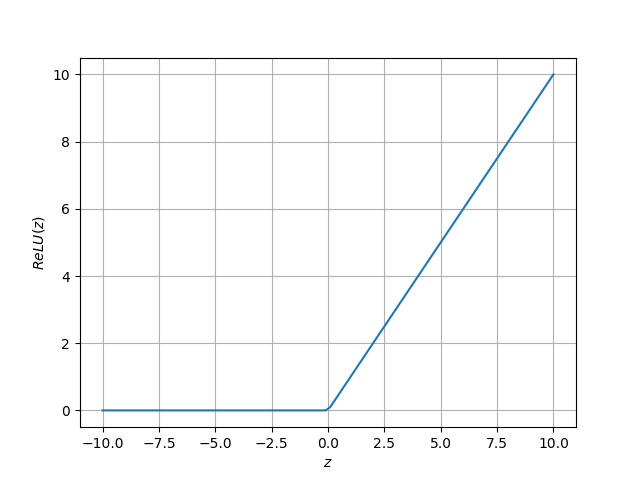



In [ ]:
class Relu(Layer):
    def forward(self, x):
        activation = np.maximum(x,0)
        return activation

In [ ]:
x = np.array([[-2.0, -1.0, 0.0], [0.0, 1.0, 2.0]], dtype=float)
relu_layer = Relu()
print("Test data is:")
print(x)
print("Output of Relu is:")
print(relu_layer(x))

Test data is:
[[-2. -1.  0.]
 [ 0.  1.  2.]]
Output of Relu is:
[[0. 0. 0.]
 [0. 1. 2.]]


####Clase densa
Implementa la función forward de la clase Dense.
- La función forward multiplica la entrada a la capa (`x`) por la matriz de pesos (`W`)


$$\mathrm{forward}(\mathbf{x},\mathbf{W}) = \mathbf{xW} $$


In [ ]:
!pip install trax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 637.9/637.9 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 93.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 120.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 48.9 MB/s eta 0:00:00
  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
     

In [ ]:
from trax import fastmath
import trax
np = fastmath.numpy
random = fastmath.random

In [ ]:
tmp_key = random.get_prng(seed=1)
print("The random seed generated by random.get_prng")
display(tmp_key)

print("choose a matrix with 2 rows and 3 columns")
tmp_shape=(2,3)
display(tmp_shape)

# Generate a weight matrix
# Note that you'll get an error if you try to set dtype to tf.float32, where tf is tensorflow
# Just avoid setting the dtype and allow it to use the default data type
tmp_weight = trax.fastmath.random.normal(key=tmp_key, shape=tmp_shape)

print("Weight matrix generated with a normal distribution with mean 0 and stdev of 1")
display(tmp_weight)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The random seed generated by random.get_prng


Array([0, 1], dtype=uint32)

choose a matrix with 2 rows and 3 columns


(2, 3)

Weight matrix generated with a normal distribution with mean 0 and stdev of 1


Array([[ 0.95730704, -0.9699289 ,  1.0070665 ],
       [ 0.3661903 ,  0.1729483 ,  0.29092234]], dtype=float32)

In [ ]:
class Dense(Layer):
    # __init__ is implemented for you
    def __init__(self, n_units, init_stdev=0.1):

        # Set the number of units in this layer
        self._n_units = n_units
        self._init_stdev = init_stdev

    # Please implement 'forward()'
    def forward(self, x):
        # Matrix multiply x and the weight matrix
        dense = np.dot(x, self.weights)
        return dense

    # init_weights
    def init_weights_and_state(self, input_signature, random_key):
        # The input_signature has a .shape attribute that gives the shape as a tuple
        input_shape = input_signature.shape

        # Generate the weight matrix from a normal distribution,
        # and standard deviation of 'stdev'
        w = self._init_stdev * random.normal(key = random_key, shape = (input_shape[-1], self._n_units))
        self.weights = w
        return self.weights

In [ ]:
dense_layer = Dense(n_units=10)  #sets  number of units in dense layer
random_key = random.get_prng(seed=0)  # sets random seed
z = np.array([[2.0, 7.0, 25.0]]) # input array

dense_layer.init(z, random_key)
print("Weights are\n ",dense_layer.weights) #Returns randomly generated weights
print("Foward function output is ", dense_layer(z)) # Returns multiplied values of units and weights

Weights are
  [[-0.02837107  0.09368163 -0.10050073  0.14165013  0.10543301  0.09108127
  -0.04265671  0.0986188  -0.05575324  0.0015325 ]
 [-0.2078568   0.05548371  0.09142365  0.05744596  0.07227863  0.01210618
  -0.03237354  0.16234998  0.02450039 -0.13809781]
 [-0.06111237  0.01403725  0.08410043 -0.10943579 -0.1077502  -0.11396457
  -0.0593338  -0.01557651 -0.03832145 -0.11144515]]
Foward function output is  [[-3.0395489   0.92668045  2.5414748  -2.0504727  -1.9769385  -2.5822086
  -1.7952732   0.94427466 -0.89803994 -3.7497485 ]]


###Parte 3:Modelo

Ahora implementará un clasificador utilizando redes neuronales. Esta es la arquitectura del modelo que implementará.

En primer lugar, mira el código de la capa Trax Dense y compáralo con tu implementación anterior.

- [tl.Dense](https://github.com/google/trax/blob/master/trax/layers/core.py#L29): Trax Dense layer implementation

Otra capa importante que utilizarás mucho es la que permite ejecutar una capa tras otra en secuencia.

- [tl.Serial](https://github.com/google/trax/blob/master/trax/layers/combinators.py#L26): Combinator that applies layers serially.

In [ ]:
from trax import layers as tl
help(tl.Dense)

Help on class Dense in module trax.layers.core:

class Dense(trax.layers.base.Layer)
 |  Dense(n_units, kernel_initializer=<function ScaledInitializer.<locals>.Init at 0x7aa905b8eb90>, bias_initializer=<function RandomNormalInitializer.<locals>.<lambda> at 0x7aa905b8ec20>, use_bias=True, use_bfloat16=False)
 |  
 |  A dense (a.k.a. fully-connected, affine) layer.
 |  
 |  Dense layers are the prototypical example of a trainable layer, i.e., a layer
 |  with trainable weights. Each node in a dense layer computes a weighted sum of
 |  all node values from the preceding layer and adds to that sum a node-specific
 |  bias term. The full layer computation is expressed compactly in linear
 |  algebra as an affine map `y = Wx + b`, where `W` is a matrix and `y`, `x`,
 |  and `b` are vectors. The layer is trained, or "learns", by updating the
 |  values in `W` and `b`.
 |  
 |  Less commonly, a dense layer can omit the bias term and be a pure linear map:
 |  `y = Wx`.
 |  
 |  Method resolutio

In [ ]:
def classifier(vocab_size=len(Vocab), embedding_dim=256, output_dim=2, mode='train'):
    # create embedding layer
    embed_layer = tl.Embedding(
        vocab_size=vocab_size, # Size of the vocabulary
        d_feature=embedding_dim)  # Embedding dimension

    # Create a mean layer, to create an "average" word embedding
    mean_layer = tl.Mean(axis=1)

    # Create a dense layer, one unit for each output
    dense_output_layer = tl.Dense(n_units = output_dim)


    # Create the log softmax layer (no parameters needed)
    log_softmax_layer = tl.LogSoftmax()

    # Use tl.Serial to combine all layers
    # and create the classifier
    # of type trax.layers.combinators.Serial
    model = tl.Serial(
      embed_layer, # embedding layer
      mean_layer, # mean layer
      dense_output_layer, # dense output layer
      log_softmax_layer  # log softmax layer
    )
    # return the model of type
    return model

In [ ]:
tmp_model = classifier()

In [ ]:
print(type(tmp_model))
display(tmp_model)

<class 'trax.layers.combinators.Serial'>


Serial[
  Embedding_9088_256
  Mean
  Dense_2
  LogSoftmax
]

### Parte 4: Entrenamiento

Para entrenar un modelo en una tarea, Trax define una abstracción training.[`trax.supervised.training.TrainTask`](https://trax-ml.readthedocs.io/en/latest/trax.supervised.html#trax.supervised.training.TrainTask)que empaqueta los datos de entrenamiento, las pérdidas y el optimizador (entre otras cosas) en un objeto.

Del mismo modo, para evaluar un modelo, Trax define una abstracción [`trax.supervised.training.EvalTask`](https://trax-ml.readthedocs.io/en/latest/trax.supervised.html#trax.supervised.training.EvalTask) que empaqueta los datos de la evaluación y las métricas (entre otras cosas) en otro objeto.

La última pieza que une todo es el [`trax.supervised.training.Loop`](https://trax-ml.readthedocs.io/en/latest/trax.supervised.html#trax.supervised.training.Loop) abstracción que es una forma muy sencilla y flexible de reunir todo y entrenar el modelo, a la vez que se evalúa y se guardan los puntos de control.


In [ ]:
from trax.supervised import training

batch_size = 16
rnd.seed(271)

train_task = training.TrainTask(
    labeled_data=train_generator(batch_size=batch_size, shuffle=True),
    loss_layer=tl.CrossEntropyLoss(),
    optimizer=trax.optimizers.Adam(0.01),
    n_steps_per_checkpoint=10,
)

eval_task = training.EvalTask(
    labeled_data=val_generator(batch_size=batch_size, shuffle=True),
    metrics=[tl.CrossEntropyLoss(), tl.Accuracy()],
)

model = classifier()

In [ ]:
output_dir = '~/model/'
output_dir_expand = os.path.expanduser(output_dir)
print(output_dir_expand)

/root/model/


In [ ]:
def train_model(classifier, train_task, eval_task, n_steps, output_dir):
    training_loop = training.Loop(classifier, # The learning model
                                train_task, # The training task
                                eval_tasks = eval_task, # The evaluation task
                                output_dir = output_dir) # The output directory

    training_loop.run(n_steps = n_steps)
    # Return the training_loop, since it has the model.
    return training_loop

In [ ]:
training_loop = train_model(model, train_task, eval_task, 100, output_dir_expand)

/usr/local/lib/python3.10/dist-packages/jax/_src/xla_bridge.py:833: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trax/layers/base.py:851: FutureWarning: GzipFile was opened for writing, but this will change in future Python releases.  Specify the mode argument for opening it for writing.
  with gzip.GzipFile(fileobj=f, compresslevel=compresslevel) as gzipf:



Step      1: Total number of trainable weights: 2327042
Step      1: Ran 1 train steps in 2.24 secs
Step      1: train CrossEntropyLoss |  0.69134951


/usr/local/lib/python3.10/dist-packages/trax/supervised/training.py:1249: FutureWarning: GzipFile was opened for writing, but this will change in future Python releases.  Specify the mode argument for opening it for writing.
  with gzip_lib.GzipFile(fileobj=f, compresslevel=2) as gzipf:


Step      1: eval  CrossEntropyLoss |  0.69083756
Step      1: eval          Accuracy |  0.50000000

Step     10: Ran 9 train steps in 6.00 secs
Step     10: train CrossEntropyLoss |  0.63903117
Step     10: eval  CrossEntropyLoss |  0.57052720
Step     10: eval          Accuracy |  0.87500000

Step     20: Ran 10 train steps in 6.72 secs
Step     20: train CrossEntropyLoss |  0.43543854
Step     20: eval  CrossEntropyLoss |  0.28021976
Step     20: eval          Accuracy |  1.00000000

Step     30: Ran 10 train steps in 3.00 secs
Step     30: train CrossEntropyLoss |  0.21934168
Step     30: eval  CrossEntropyLoss |  0.14136277
Step     30: eval          Accuracy |  1.00000000

Step     40: Ran 10 train steps in 2.09 secs
Step     40: train CrossEntropyLoss |  0.14651243
Step     40: eval  CrossEntropyLoss |  0.09430134
Step     40: eval          Accuracy |  1.00000000

Step     50: Ran 10 train steps in 1.90 secs
Step     50: train CrossEntropyLoss |  0.05606594
Step     50: eval  Cr

#### Haciendo una Prediccion

In [ ]:
tmp_train_generator = train_generator(16)

# get one batch
tmp_batch = next(tmp_train_generator)

# Position 0 has the model inputs (tweets as tensors)
# position 1 has the targets (the actual labels)
tmp_inputs, tmp_targets, tmp_example_weights = tmp_batch

print(f"The batch is a tuple of length {len(tmp_batch)} because position 0 contains the tweets, and position 1 contains the targets.")
print(f"The shape of the tweet tensors is {tmp_inputs.shape} (num of examples, length of tweet tensors)")
print(f"The shape of the labels is {tmp_targets.shape}, which is the batch size.")
print(f"The shape of the example_weights is {tmp_example_weights.shape}, which is the same as inputs/targets size.")

The batch is a tuple of length 3 because position 0 contains the tweets, and position 1 contains the targets.
The shape of the tweet tensors is (16, 15) (num of examples, length of tweet tensors)
The shape of the labels is (16,), which is the batch size.
The shape of the example_weights is (16,), which is the same as inputs/targets size.


In [ ]:
tmp_pred = training_loop.eval_model(tmp_inputs)
print(f"The prediction shape is {tmp_pred.shape}, num of tensor_tweets as rows")
print("Column 0 is the probability of a negative sentiment (class 0)")
print("Column 1 is the probability of a positive sentiment (class 1)")
print()
print("View the prediction array")
tmp_pred

The prediction shape is (16, 2), num of tensor_tweets as rows
Column 0 is the probability of a negative sentiment (class 0)
Column 1 is the probability of a positive sentiment (class 1)

View the prediction array


Array([[-8.2832794e+00, -2.5272369e-04],
       [-9.1690121e+00, -1.0395050e-04],
       [-8.2101994e+00, -2.7179718e-04],
       [-8.2595367e+00, -2.5892258e-04],
       [-6.0829601e+00, -2.2840500e-03],
       [-7.5590882e+00, -5.2142143e-04],
       [-8.6757288e+00, -1.7070770e-04],
       [-5.1484814e+00, -5.8252811e-03],
       [-2.1288395e-03, -6.1532393e+00],
       [-2.9656887e-03, -5.8221655e+00],
       [-3.2615662e-04, -8.0278149e+00],
       [-4.7683716e-07, -1.4783379e+01],
       [-7.9090595e-03, -4.8436890e+00],
       [-1.1241436e-03, -6.7911692e+00],
       [-2.2392273e-03, -6.1027484e+00],
       [-6.1345100e-04, -7.3967605e+00]], dtype=float32)

In [ ]:
tmp_is_positive = tmp_pred[:,1] > tmp_pred[:,0]
for i, p in enumerate(tmp_is_positive):
    print(f"Neg log prob {tmp_pred[i,0]:.4f}\tPos log prob {tmp_pred[i,1]:.4f}\t is positive? {p}\t actual {tmp_targets[i]}")

Neg log prob -8.2833	Pos log prob -0.0003	 is positive? True	 actual 1
Neg log prob -9.1690	Pos log prob -0.0001	 is positive? True	 actual 1
Neg log prob -8.2102	Pos log prob -0.0003	 is positive? True	 actual 1
Neg log prob -8.2595	Pos log prob -0.0003	 is positive? True	 actual 1
Neg log prob -6.0830	Pos log prob -0.0023	 is positive? True	 actual 1
Neg log prob -7.5591	Pos log prob -0.0005	 is positive? True	 actual 1
Neg log prob -8.6757	Pos log prob -0.0002	 is positive? True	 actual 1
Neg log prob -5.1485	Pos log prob -0.0058	 is positive? True	 actual 1
Neg log prob -0.0021	Pos log prob -6.1532	 is positive? False	 actual 0
Neg log prob -0.0030	Pos log prob -5.8222	 is positive? False	 actual 0
Neg log prob -0.0003	Pos log prob -8.0278	 is positive? False	 actual 0
Neg log prob -0.0000	Pos log prob -14.7834	 is positive? False	 actual 0
Neg log prob -0.0079	Pos log prob -4.8437	 is positive? False	 actual 0
Neg log prob -0.0011	Pos log prob -6.7912	 is positive? False	 actual 0

### Parte 5: Calcular la precisión en un lote

Ahora escribirá una función que evalúe su modelo en el conjunto de validación y devuelva la precisión.

In [ ]:
def compute_accuracy(preds, y, y_weights):
    # Create an array of booleans,
    # True if the probability of positive sentiment is greater than
    # the probability of negative sentiment
    # else False
    is_pos =  preds[:, 1] > preds[:, 0]

    # convert the array of booleans into an array of np.int32
    is_pos_int = is_pos.astype(np.int32)

    # compare the array of predictions (as int32) with the target (labels) of type int32
    correct = is_pos_int == y

    # Count the sum of the weights.
    sum_weights = np.sum(y_weights)

    # convert the array of correct predictions (boolean) into an arrayof np.float32
    correct_float = correct.astype(np.float32)

    # Multiply each prediction with its corresponding weight.
    weighted_correct_float = correct_float * y_weights

    # Sum up the weighted correct predictions (of type np.float32), to go in the
    # denominator.
    weighted_num_correct = np.sum(weighted_correct_float)

    # Divide the number of weighted correct predictions by the sum of the
    # weights.
    accuracy = weighted_num_correct / sum_weights
    return accuracy, weighted_num_correct, sum_weights

In [ ]:
# test your function
tmp_val_generator = val_generator(64)

# get one batch
tmp_batch = next(tmp_val_generator)

# Position 0 has the model inputs (tweets as tensors)
# position 1 has the targets (the actual labels)
tmp_inputs, tmp_targets, tmp_example_weights = tmp_batch

# feed the tweet tensors into the model to get a prediction
tmp_pred = training_loop.eval_model(tmp_inputs)

tmp_acc, tmp_num_correct, tmp_num_predictions = compute_accuracy(preds=tmp_pred, y=tmp_targets, y_weights=tmp_example_weights)

print(f"Model's prediction accuracy on a single training batch is: {100 * tmp_acc}%")
print(f"Weighted number of correct predictions {tmp_num_correct}; weighted number of total observations predicted {tmp_num_predictions}")

Model's prediction accuracy on a single training batch is: 100.0%
Weighted number of correct predictions 64.0; weighted number of total observations predicted 64


In [ ]:
def test_model(generator, model):
    accuracy = 0.
    total_num_correct = 0
    total_num_pred = 0
    for batch in generator:

        # Retrieve the inputs from the batch
        inputs = batch[0]

        # Retrieve the targets (actual labels) from the batch
        targets = batch[1]

        # Retrieve the example weight.
        example_weight = batch[2]

        # Make predictions using the inputs
        pred = model(inputs)

        # Calculate accuracy for the batch by comparing its predictions and targets
        batch_accuracy, batch_num_correct, batch_num_pred = compute_accuracy(pred, targets, example_weight)

        # Update the total number of correct predictions
        # by adding the number of correct predictions from this batch
        total_num_correct += batch_num_correct

        # Update the total number of predictions
        # by adding the number of predictions made for the batch
        total_num_pred += batch_num_pred

    # Calculate accuracy over all examples
    accuracy = total_num_correct / total_num_pred
    return accuracy

In [ ]:
model = training_loop.eval_model
accuracy = test_model(test_generator(16), model)

print(f'The accuracy of your model on the validation set is {accuracy:.4f}', )

The accuracy of your model on the validation set is 0.9940


### Parte 6: Pruebas con sus propios datos

In [ ]:
def predict(sentence):
    inputs = np.array(tweet_to_tensor(sentence, vocab_dict=Vocab))

    # Batch size 1, add dimension for batch, to work with the model
    inputs = inputs[None, :]

    # predict with the model
    preds_probs = model(inputs)

    # Turn probabilities into categories
    preds = int(preds_probs[0, 1] > preds_probs[0, 0])
    print(preds_probs)

    sentiment = "negative"
    if preds == 1:
        sentiment = 'positive'

    return preds, sentiment

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
sentence = "I am bad"
tmp_pred, tmp_sentiment = predict(sentence)
print(f"The sentiment of the sentence \n***\n\"{sentence}\"\n***\nis {tmp_sentiment}.")


[[-0.03366446 -3.4080966 ]]
The sentiment of the sentence 
***
"I am bad"
***
is negative.


#**Categorizacion de Texto**
Consiste en clasificar un texto en una clase mas grande pero en el caso de este ejemplo sin nesesidad de entrenar el modelo en esas categorias One-shot ya que proveemos un ejemplo

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Predecir Paises de sus Capitales:
###Parte 1: Importar la informacion

In [13]:
data = pd.read_csv('capitals.txt', delimiter=' ')
data.columns = ['city1', 'country1', 'city2', 'country2']

# print first five elements in the DataFrame
data.head(50)

,city1,country1,city2,country2
0,Athens,Greece,Bangkok,Thailand
1,Athens,Greece,Beijing,China
2,Athens,Greece,Berlin,Germany
3,Athens,Greece,Bern,Switzerland
4,Athens,Greece,Cairo,Egypt
5,Athens,Greece,Canberra,Australia
6,Athens,Greece,Hanoi,Vietnam
7,Athens,Greece,Havana,Cuba
8,Athens,Greece,Helsinki,Finland
9,Athens,Greece,Islamabad,Pakistan


In [3]:
import nltk
nltk.download('punkt')
from gensim.models import KeyedVectors


embeddings = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True)
f = open('/content/drive/MyDrive/NLP/capitals.txt', 'r').read()
set_words = set(nltk.word_tokenize(f))
select_words = words = ['king', 'queen', 'oil', 'gas', 'happy', 'sad', 'city', 'town', 'village', 'country', 'continent', 'petroleum', 'joyful']
for w in select_words:
    set_words.add(w)

def get_word_embeddings(embeddings):

    word_embeddings = {}
    for word in embeddings.index_to_key:
        if word in set_words:
            word_embeddings[word] = embeddings[word]
    return word_embeddings


# Testing your function
word_embeddings = get_word_embeddings(embeddings)
print(len(word_embeddings))
pickle.dump( word_embeddings, open( "/content/drive/MyDrive/NLP/word_embeddings_subset.p", "wb" ) )

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


243


#### Para cargar despues el modelo :

In [ ]:
word_embeddings = pickle.load(open("Modelos Entrenados\word_embeddings_subset.p", "rb"))
len(word_embeddings)

243

#### Funciones importantes para calcular la distiancia y similitud

In [4]:
def cosine_similarity(A, B):
    dot = np.dot(A,B)
    norma = np.sqrt(np.dot(A,A))
    normb = np.sqrt(np.dot(B,B))
    cos = dot / (norma*normb)
    return cos

def euclidean(A, B):
    d = np.linalg.norm(A-B)
    return d

In [5]:
king = word_embeddings['king']
queen = word_embeddings['queen']

cosine_similarity(king, queen)

0.6510956

In [6]:
euclidean(king, queen)

2.4796925

###Parte 2: Encontrar el país de cada capital

Ahora, utilizarás las funciones anteriores para calcular similitudes entre vectores
y las utilizarás para hallar las capitales de los países. Escribiremos una función que
toma tres palabras y el diccionario de incrustaciones. Su tarea consiste en encontrar las
capitales. Por ejemplo, dadas las siguientes palabras

- 1: Atenas 2: Grecia 3: Bagdad,

tu tarea es predecir el país 4: Irak.

1. Para predecir la capital, tal vez quieras fijarte en el ejemplo *Rey - Hombre + Mujer = Reina* anterior, e implementar ese esquema en una función matemática, utilizando las incrustaciones de palabras y una función de similitud.

2. Itere sobre el diccionario de incrustaciones y calcule la puntuación de similitud coseno entre su vector y la incrustación de palabras actual.

3. Debería añadir una comprobación para asegurarse de que la palabra que devuelve no es ninguna de las palabras que introdujo en su función. Devuelve la que tenga la puntuación más alta.

In [7]:
def get_country(city1, country1, city2, embeddings):
    # store the city1, country 1, and city 2 in a set called group
    group = set((city1, country1, city2))

    # get embeddings of city 1
    city1_emb = word_embeddings[city1]

    # get embedding of country 1
    country1_emb =  word_embeddings[country1]

    # get embedding of city 2
    city2_emb = word_embeddings[city2]

    # get embedding of country 2 (it's a combination of the embeddings of country 1, city 1 and city 2)
    # Remember: King - Man + Woman = Queen
    vec = country1_emb - city1_emb + city2_emb

    # Initialize the similarity to -1 (it will be replaced by a similarities that are closer to +1)
    similarity = -1

    # initialize country to an empty string
    country = ''

    # loop through all words in the embeddings dictionary
    for word in embeddings.keys():

        # first check that the word is not already in the 'group'
        if word not in group:

            # get the word embedding
            word_emb = word_embeddings[word]

            # calculate cosine similarity between embedding of country 2 and the word in the embeddings dictionary
            cur_similarity = cosine_similarity(vec,word_emb)

            # if the cosine similarity is more similar than the previously best similarity...
            if cur_similarity > similarity:

                # update the similarity to the new, better similarity
                similarity = cur_similarity

                # store the country as a tuple, which contains the word and the similarity
                country = (word, similarity)

    return country

In [14]:
get_country('Russia', 'Sweden', 'Hanoi', word_embeddings)

('Vientiane', 0.5397004)

####Precisión del modelo

Ahora probará su nueva función en el conjunto de datos y comprobará la precisión del modelo:

In [15]:
def get_accuracy(word_embeddings, data):
    # initialize num correct to zero
    num_correct = 0

    # loop through the rows of the dataframe
    for i, row in data.iterrows():

        # get city1
        city1 = row['city1']

        # get country1
        country1 = row['country1']

        # get city2
        city2 =  row['city2']

        # get country2
        country2 = row['country2']

        # use get_country to find the predicted country2
        predicted_country2, _ = get_country(city1,country1,city2,word_embeddings)

        # if the predicted country2 is the same as the actual country2...
        if predicted_country2 == country2:
            # increment the number of correct by 1
            num_correct += 1

    # get the number of rows in the data dataframe (length of dataframe)
    m = len(data)

    # calculate the accuracy by dividing the number correct by m
    accuracy = num_correct/m

    return accuracy

In [16]:
accuracy = get_accuracy(word_embeddings, data)
print(f"Accuracy is {accuracy:.2f}")

Accuracy is 0.92


###Parte 3: Trazado de los vectores mediante PCA

Ahora exploraremos la distancia entre los vectores de palabras después de reducir su dimensión.
La técnica que emplearemos se conoce como
[*análisis de componentes principales* (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis).
Como hemos visto, en este caso estamos trabajando en un espacio de 300 dimensiones.
Aunque desde una perspectiva computacional pudimos realizar un buen trabajo,
es imposible visualizar los resultados en espacios de tan alta dimensión.

El PCA es un método que proyecta nuestros vectores en un espacio de dimensión reducida, manteniendo la máxima información sobre los vectores.
dimensión reducida, manteniendo la máxima información sobre los vectores
sus contrapartes reducidas. En este caso, por *máxima información* entendemos que la distancia
distancia euclidiana entre los vectores originales y sus hermanos proyectados es
mínima. Por lo tanto, los vectores que originalmente estaban próximos en el diccionario de incrustaciones
...producirán vectores de menor dimensión que aún están cerca unos de otros.

Verá que cuando mapee las palabras, las palabras similares se agruparán
unas junto a otras. Por ejemplo, las palabras "triste", "feliz", "alegre" describen emociones y se supone que están cerca unas de otras.
emoción y se supone que al trazarlas deben estar cerca unas de otras.
Las palabras petróleo", "gas" y "petróleo" describen recursos naturales.
Las palabras "ciudad", "aldea", "pueblo" pueden considerarse sinónimos y describen algo similar.
algo similar.

Antes de trazar las palabras, primero hay que reducir cada vector de palabras
con PCA en 2 dimensiones y luego trazarlo.

In [17]:
def compute_pca(X, n_components=2):
    # mean center the data
    X_demeaned = X - np.mean(X,axis=0)
    print('X_demeaned.shape: ',X_demeaned.shape)

    # calculate the covariance matrix
    covariance_matrix = np.cov(X_demeaned, rowvar=False)

    # calculate eigenvectors & eigenvalues of the covariance matrix
    eigen_vals, eigen_vecs = np.linalg.eigh(covariance_matrix, UPLO='L')

    # sort eigenvalue in increasing order (get the indices from the sort)
    idx_sorted = np.argsort(eigen_vals)

    # reverse the order so that it's from highest to lowest.
    idx_sorted_decreasing = idx_sorted[::-1]

    # sort the eigen values by idx_sorted_decreasing
    eigen_vals_sorted = eigen_vals[idx_sorted_decreasing]

    # sort eigenvectors using the idx_sorted_decreasing indices
    eigen_vecs_sorted = eigen_vecs[:,idx_sorted_decreasing]

    # select the first n eigenvectors (n is desired dimension
    # of rescaled data array, or dims_rescaled_data)
    eigen_vecs_subset = eigen_vecs_sorted[:,0:n_components]

    # transform the data by multiplying the transpose of the eigenvectors
    # with the transpose of the de-meaned data
    # Then take the transpose of that product.
    X_reduced = np.dot(eigen_vecs_subset.transpose(),X_demeaned.transpose()).transpose()
    return X_reduced

def get_vectors(embeddings, words):
    """
    Input:
        embeddings: a word
        fr_embeddings:
        words: a list of words
    Output:
        X: a matrix where the rows are the embeddings corresponding to the rows on the list

    """
    m = len(words)
    X = np.zeros((1, 300))
    for word in words:
        english = word
        eng_emb = embeddings[english]
        X = np.row_stack((X, eng_emb))
    X = X[1:,:]
    return X

In [18]:
words = ['oil', 'gas', 'happy', 'sad', 'city', 'town',
         'village', 'country', 'continent', 'petroleum', 'joyful','Athens', 'Greece', 'Cairo','Egypt']

# given a list of words and the embeddings, it returns a matrix with all the embeddings
X = get_vectors(word_embeddings, words)

print('You have 15 words each of 300 dimensions thus X.shape is:', X.shape)

You have 15 words each of 300 dimensions thus X.shape is: (15, 300)


X_demeaned.shape:  (15, 300)


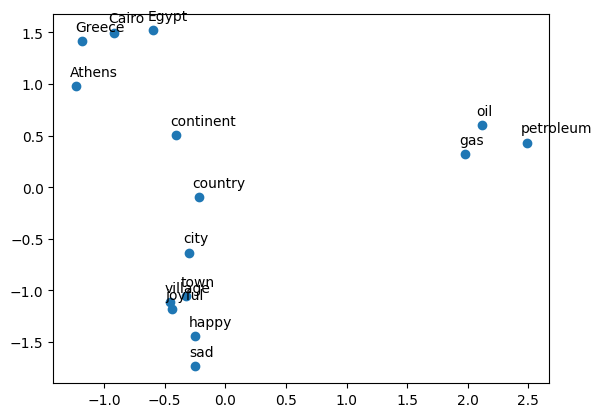

In [19]:
result = compute_pca(X, 2)
plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0] - 0.05, result[i, 1] + 0.1))

plt.show()

#**Traduccion**:
Pasar de un idioma a otro con sentido

##Naive Machine Translation:


In [20]:
import pdb
import pickle
import string

import time

import gensim
import matplotlib.pyplot as plt
import nltk
import numpy as np
import scipy
import sklearn
from gensim.models import KeyedVectors
from nltk.corpus import stopwords, twitter_samples
from nltk.tokenize import TweetTokenizer

###funciones utiles

In [21]:
def get_dict(file_name):
    """
    This function returns the english to french dictionary given a file where the each column corresponds to a word.
    Check out the files this function takes in your workspace.
    """
    my_file = pd.read_csv(file_name, delimiter=' ')
    etof = {}  # the english to french dictionary to be returned
    for i in range(len(my_file)):
        # indexing into the rows.
        en = my_file.loc[i][0]
        fr = my_file.loc[i][1]
        etof[en] = fr

    return etof

In [22]:
!curl -o ./wiki.multi.fr.vec https://dl.fbaipublicfiles.com/arrival/vectors/wiki.multi.fr.vec

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  599M  100  599M    0     0  51.7M      0  0:00:11  0:00:11 --:--:-- 62.7M


In [23]:
from gensim.models import KeyedVectors

en_embeddings = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True)
fr_embeddings = KeyedVectors.load_word2vec_format('./wiki.multi.fr.vec')


# loading the english to french dictionaries
en_fr_train = get_dict('en-fr.train.txt')
print('The length of the english to french training dictionary is', len(en_fr_train))
en_fr_test = get_dict('en-fr.test.txt')
print('The length of the english to french test dictionary is', len(en_fr_train))

english_set = set(en_embeddings.index_to_key)
french_set = set(fr_embeddings.index_to_key)
en_embeddings_subset = {}
fr_embeddings_subset = {}
french_words = set(en_fr_train.values())

for en_word in en_fr_train.keys():
    fr_word = en_fr_train[en_word]
    if fr_word in french_set and en_word in english_set:
        en_embeddings_subset[en_word] = en_embeddings[en_word]
        fr_embeddings_subset[fr_word] = fr_embeddings[fr_word]


for en_word in en_fr_test.keys():
    fr_word = en_fr_test[en_word]
    if fr_word in french_set and en_word in english_set:
        en_embeddings_subset[en_word] = en_embeddings[en_word]
        fr_embeddings_subset[fr_word] = fr_embeddings[fr_word]


pickle.dump( en_embeddings_subset, open( "Modelos Entrenados\en_embeddings.p", "wb" ) )
pickle.dump( fr_embeddings_subset, open( "Modelos Entrenados\fr_embeddings.p", "wb" ) )

The length of the english to french training dictionary is 5000
The length of the english to french test dictionary is 5000


#### Cargar despues de reducir

In [ ]:
en_embeddings_subset = pickle.load(open("Modelos Entrenados\en_embeddings.p", "rb"))
fr_embeddings_subset = pickle.load(open("Modelos Entrenados\fr_embeddings.p", "rb"))

In [24]:
en_fr_train = get_dict('en-fr.train.txt')
print('The length of the English to French training dictionary is', len(en_fr_train))
en_fr_test = get_dict('en-fr.test.txt')
print('The length of the English to French test dictionary is', len(en_fr_train))

The length of the English to French training dictionary is 5000
The length of the English to French test dictionary is 5000


###Parte 1: Generar matrices de incrustación y transformación

Ahora implementaremos una función `get_matrices`, que toma los datos cargados
y devuelve las matrices `X` y `Y`.

In [25]:
def get_matrices(en_fr, french_vecs, english_vecs):
    # X_l and Y_l are lists of the english and french word embeddings
    X_l = list()
    Y_l = list()

    # get the english words (the keys in the dictionary) and store in a set()
    english_set = english_vecs.keys()

    # get the french words (keys in the dictionary) and store in a set()
    french_set = french_vecs.keys()

    # store the french words that are part of the english-french dictionary (these are the values of the dictionary)
    french_words = set(en_fr.values())

    # loop through all english, french word pairs in the english french dictionary
    for en_word, fr_word in en_fr.items():

        # check that the french word has an embedding and that the english word has an embedding
        if fr_word in french_set and en_word in english_set:

            # get the english embedding
            en_vec = english_vecs[en_word]

            # get the french embedding
            fr_vec = french_vecs[fr_word]

            # add the english embedding to the list
            X_l.append(en_vec)

            # add the french embedding to the list
            Y_l.append(fr_vec)

    # stack the vectors of X_l into a matrix X
    X =  np.vstack(X_l)

    # stack the vectors of Y_l into a matrix Y
    Y = np.vstack(Y_l)
    return X, Y

In [26]:
X_train, Y_train = get_matrices(
    en_fr_train, fr_embeddings_subset, en_embeddings_subset)

### Parte 2 La traducción como transformación lineal de incrustaciones

Dados los diccionarios de incrustaciones de palabras en inglés y francés, se creará una matriz de transformación `R`.
* Dada una incrustación de palabra inglesa, $\mathbf{e}$, puede multiplicar $\mathbf{eR}$ para obtener una nueva incrustación de palabra $\mathbf{f}$.
    * Tanto $\mathbf{e}$ como $\mathbf{f}$ son [vectores fila](https://en.wikipedia.org/wiki/Row_and_column_vectors).
* A continuación, puede calcular los vecinos más cercanos a `f` en las incrustaciones francesas y recomendar la palabra que es más similar a la incrustación de la palabra transformada.

#### Describiendo la traslación como el problema de minimización

Encontrar una matriz `R` que minimiza la siguiente ecuación.

$$\arg \min _{\mathbf{R}}\| \mathbf{X R} - \mathbf{Y}\|_{F}\tag{1} $$

#### Norma de Frobenius

La norma de Frobenius de una matriz $A$ (suponiendo que es de dimensión $m,n$) se define como la raíz cuadrada de la suma de los cuadrados absolutos de sus elementos:

$$\|\mathbf{A}\|_{F} \equiv \sqrt{\sum_{i=1}^{m} \sum_{j=1}^{n}\left|a_{i j}\right|^{2}}\tag{2}$$

#### Función de pérdida real
En las aplicaciones del mundo real, la pérdida de la norma de Frobenius:

$$\| \mathbf{XR} - |mathbf{Y}|_{F}$$

suele sustituirse por su valor al cuadrado dividido por $m$:

$$ \frac{1}{m} | \mathbf{X R} - Y \|_{F}^{2}$$

donde $m$ es el número de ejemplos (filas en $\mathbf{X}$).

* Se encuentra la misma R cuando se utiliza esta función de pérdida frente a la norma de Frobenius original.
* La razón para tomar el cuadrado es que es más fácil calcular el gradiente de Frobenius al cuadrado.
* La razón de dividir por $m$ es que estamos más interesados en la pérdida media por incrustación que en la pérdida para todo el conjunto de entrenamiento.
    * La pérdida para todo el conjunto de entrenamiento aumenta con más palabras (ejemplos de entrenamiento),
    por lo que tomar la media nos ayuda a rastrear la pérdida media independientemente del tamaño del conjunto de entrenamiento.

####Cálculo de la funcion de pérdida
* La función de pérdida será la norma de Frobenoius al cuadrado de la diferencia entre
y su aproximación, dividida por el número de ejemplos de entrenamiento $m$.
* Su fórmula es:
$$ L(X, Y, R)=\frac{1}{m}\sum_{i=1}^{m} \sum_{j=1}^{n}\left( a_{i j} \right)^{2}$$

donde $a_{i j}$ es el valor en $i$ fila y $j$ columna de la matriz $\mathbf{XR}-\mathbf{Y}$.

In [27]:
def compute_loss(X, Y, R):
    # m is the number of rows in X
    m = X.shape[0]

    # diff is XR - Y
    diff = np.dot(X,R)-Y

    # diff_squared is the element-wise square of the difference
    diff_squared = diff**2

    # sum_diff_squared is the sum of the squared elements
    sum_diff_squared = np.sum(diff_squared)

    # loss i the sum_diff_squard divided by the number of examples (m)
    loss = sum_diff_squared/m
    return loss

####Calcular el gradiente de la pérdida con respecto a la matriz de transformación R

* Calcular el gradiente de la pérdida con respecto a la matriz de transformación `R`.
* El gradiente es una matriz que codifica cuánto un pequeño cambio en `R`
afecta al cambio en la función de pérdida.
* El gradiente nos da la dirección en la que debemos disminuir `R` para minimizar la pérdida.
para minimizar la pérdida.
* $m$ es el número de ejemplos de entrenamiento (número de filas en $X$).
* La fórmula para el gradiente de la función de pérdida $𝐿(𝑋,𝑌,𝑅)$ es:

$$\frac{d}{dR}𝐿(𝑋,𝑌,𝑅)=\frac{d}{dR}\Big(\frac{1}{m}\| X R -Y\|_{F}^{2}\Big) = \frac{2}{m}X^{T} (X R - Y)$$

In [28]:
def compute_gradient(X, Y, R):
    # m is the number of rows in X
    m = X.shape[0]

    # gradient is X^T(XR - Y) * 2/m
    gradient = np.dot(X.transpose(),np.dot(X,R)-Y)*(2/m)
    return gradient

#### Descenso de gradiente

[Gradient descent](https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html) es un algoritmo iterativo que se utiliza en la búsqueda del óptimo de la función.
* Anteriormente, hemos mencionado que el gradiente de la pérdida con respecto a la matriz codifica cuánto afecta un pequeño cambio en alguna coordenada de esa matriz al cambio de la función de pérdida.
* El descenso gradiente utiliza esa información para cambiar iterativamente la matriz `R` hasta que alcanzamos un punto en el que la pérdida se minimiza.

In [29]:
def align_embeddings(X, Y, train_steps=100, learning_rate=0.0003):
    np.random.seed(129)

    # the number of columns in X is the number of dimensions for a word vector (e.g. 300)
    # R is a square matrix with length equal to the number of dimensions in th  word embedding
    R = np.random.rand(X.shape[1], X.shape[1])

    for i in range(train_steps):
        if i % 25 == 0:
            print(f"loss at iteration {i} is: {compute_loss(X, Y, R):.4f}")
        # use the function that you defined to compute the gradient
        gradient = compute_gradient(X,Y,R)

        # update R by subtracting the learning rate times gradient
        R -=  learning_rate * gradient
    return R

In [30]:
np.random.seed(129)
m = 10
n = 5
X = np.random.rand(m, n)
Y = np.random.rand(m, n) * .1
R = align_embeddings(X, Y)

loss at iteration 0 is: 3.7242
loss at iteration 25 is: 3.6283
loss at iteration 50 is: 3.5350
loss at iteration 75 is: 3.4442


In [31]:
R_train = align_embeddings(X_train, Y_train, train_steps=400, learning_rate=0.8)

loss at iteration 0 is: 963.0146
loss at iteration 25 is: 97.8292
loss at iteration 50 is: 26.8329
loss at iteration 75 is: 9.7893
loss at iteration 100 is: 4.3776
loss at iteration 125 is: 2.3281
loss at iteration 150 is: 1.4480
loss at iteration 175 is: 1.0338
loss at iteration 200 is: 0.8251
loss at iteration 225 is: 0.7145
loss at iteration 250 is: 0.6534
loss at iteration 275 is: 0.6185
loss at iteration 300 is: 0.5981
loss at iteration 325 is: 0.5858
loss at iteration 350 is: 0.5782
loss at iteration 375 is: 0.5735


###Parte 3:Probar la traduccion

#### Algoritmo k-Nearest neighbors

[Algoritmo k-Nearest neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)
* k-NN es un método que toma un vector como entrada y encuentra los otros vectores en el conjunto de datos que están más cerca de él.
* El 'k' es el número de "vecinos más cercanos" a encontrar (por ejemplo, k=2 encuentra los dos vecinos más cercanos).

#### Búsqueda de la incrustación de traducción
Dado que estamos aproximando la función de traducción de inglés a francés incrustaciones por una matriz de transformación lineal $\mathbf{R}$, la mayoría de las veces no vamos a obtener la exacta incrustación de una palabra francesa cuando transformamos incrustación $\mathbf{e}$ de alguna palabra en particular Inglés en el espacio de incrustación francés.
* Aquí es donde $k$-NN resulta realmente útil. Utilizando $1$-NN con $\mathbf{eR}$ como entrada, podemos buscar una incrustación $\mathbf{f}$ (como fila) en la matriz $\mathbf{Y}$ que sea la más cercana al vector transformado $\mathbf{eR}$.

In [32]:
def nearest_neighbor(v, candidates, k=1):
    similarity_l = []

    # for each candidate vector...
    for row in candidates:
        # get the cosine similarity
        cos_similarity = cosine_similarity(v,row)

        # append the similarity to the list
        similarity_l.append(cos_similarity)

    # sort the similarity list and get the indices of the sorted list
    sorted_ids = np.argsort(similarity_l)

    # get the indices of the k most similar candidate vectors
    k_idx = sorted_ids[-k:]
    return k_idx

In [33]:
def test_vocabulary(X, Y, R):
    # The prediction is X times R
    pred = np.dot(X,R)

    # initialize the number correct to zero
    num_correct = 0

    # loop through each row in pred (each transformed embedding)
    for i in range(len(pred)):
        # get the index of the nearest neighbor of pred at row 'i'; also pass in the candidates in Y
        pred_idx = nearest_neighbor(pred[i],Y)

        # if the index of the nearest neighbor equals the row of i... \
        if pred_idx == i:
            # increment the number correct by 1.
            num_correct += 1

    # accuracy is the number correct divided by the number of rows in 'pred' (also number of rows in X)
    accuracy = num_correct / len(pred)

    return accuracy

In [34]:
X_val, Y_val = get_matrices(en_fr_test, fr_embeddings_subset, en_embeddings_subset)

In [35]:
acc = test_vocabulary(X_val, Y_val, R_train)  # this might take a minute or two
print(f"accuracy on test set is {acc:.3f}")

accuracy on test set is 0.557


##Neural Machine Translation:
English-to-German neural machine translation (NMT) model using Long Short-Term Memory (LSTM) networks with attention.

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Parte 1:Dataset
Usaremos el conjunto de datos de Europarl que tiene pares de oraciones en la mayoría de los idiomas europeos. Los datos fueron creados por la Unión Europea, que traduce gran parte de sus comunicaciones a los idiomas de los países miembros de la Unión Europea.

http://www.statmt.org/europarl/

In [ ]:
import sys
import os
import urllib.request
import tarfile
import zipfile

########################################################################


def _print_download_progress(count, block_size, total_size):
    """
    Function used for printing the download progress.
    Used as a call-back function in maybe_download_and_extract().
    """

    # Percentage completion.
    pct_complete = float(count * block_size) / total_size

    # Limit it because rounding errors may cause it to exceed 100%.
    pct_complete = min(1.0, pct_complete)

    # Status-message. Note the \r which means the line should overwrite itself.
    msg = "\r- Download progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()


########################################################################

def download(base_url, filename, download_dir):
    """
    Download the given file if it does not already exist in the download_dir.

    :param base_url: The internet URL without the filename.
    :param filename: The filename that will be added to the base_url.
    :param download_dir: Local directory for storing the file.
    :return: Nothing.
    """

    # Path for local file.
    save_path = os.path.join(download_dir, filename)

    # Check if the file already exists, otherwise we need to download it now.
    if not os.path.exists(save_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        print("Downloading", filename, "...")

        # Download the file from the internet.
        url = base_url + filename
        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=save_path,
                                                  reporthook=_print_download_progress)

        print(" Done!")


def maybe_download_and_extract(url, download_dir):
    """
    Download and extract the data if it doesn't already exist.
    Assumes the url is a tar-ball file.

    :param url:
        Internet URL for the tar-file to download.
        Example: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

    :param download_dir:
        Directory where the downloaded file is saved.
        Example: "data/CIFAR-10/"

    :return:
        Nothing.
    """

    # Filename for saving the file downloaded from the internet.
    # Use the filename from the URL and add it to the download_dir.
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    # Check if the file already exists.
    # If it exists then we assume it has also been extracted,
    # otherwise we need to download and extract it now.
    if not os.path.exists(file_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        # Download the file from the internet.
        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=file_path,
                                                  reporthook=_print_download_progress)

        print()
        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            # Unpack the zip-file.
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            # Unpack the tar-ball.
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done.")
    else:
        print("Data has apparently already been downloaded and unpacked.")

In [ ]:
import os
data_dir = "data/europarl/"

# Base-URL for the data-sets on the internet.
data_url = "http://www.statmt.org/europarl/v7/"

def maybe_download_and_extract_2(language_code="da"):
    """
    Download and extract the Europarl data-set if the data-file doesn't
    already exist in data_dir. The data-set is for translating between
    English and the given language-code (e.g. 'da' for Danish, see the
    list of available language-codes above).
    """

    # Create the full URL for the file with this data-set.
    url = data_url + language_code + "-en.tgz"

    maybe_download_and_extract(url=url, download_dir=data_dir)


def load_data(english=True, language_code="da", start="", end=""):
    """
    Load the data-file for either the English-language texts or
    for the other language (e.g. "da" for Danish).

    All lines of the data-file are returned as a list of strings.

    :param english:
      Boolean whether to load the data-file for
      English (True) or the other language (False).

    :param language_code:
      Two-char code for the other language e.g. "da" for Danish.
      See list of available codes above.

    :param start:
      Prepend each line with this text e.g. "ssss " to indicate start of line.

    :param end:
      Append each line with this text e.g. " eeee" to indicate end of line.

    :return:
      List of strings with all the lines of the data-file.
    """

    if english:
        # Load the English data.
        filename = "europarl-v7.{0}-en.en".format(language_code)
    else:
        # Load the other language.
        filename = "europarl-v7.{0}-en.{0}".format(language_code)

    # Full path for the data-file.
    path = os.path.join(data_dir, filename)

    # Open and read all the contents of the data-file.
    with open(path, encoding="utf-8") as file:
        # Read the line from file, strip leading and trailing whitespace,
        # prepend the start-text and append the end-text.
        texts = [start + line.strip() + end for line in file]

    return texts

####La lista de idiomas soportados actualmente y sus códigos son los siguientes:
* bg - Bulgaro      
* cs - Checo
* da - Danes
* de - Aleman
* el - Griego
* es - Español
* et - Estonio
* fi - Finlandes
* fr - Frances
* hu - Hungaro
* it - Italiano
* lt - Lituano
* lv - Leton
* nl - Holandes
* pl - Polaco
* pt - Portugues
* ro - Rumano
* sk - Eslovaco
* sl - Esloveno
* sv - Sueco

In [ ]:
language_code='es'

Para que el decodificador sepa cuándo comenzar y terminar una oración, debemos marcar el comienzo y el final de cada oración con palabras que probablemente no aparezcan en el conjunto de datos.

In [ ]:
mark_start = 'ssss '
mark_end = ' eeee'

In [ ]:
maybe_download_and_extract_2(language_code=language_code)

- Download progress: 100.0%
Download finished. Extracting files.
Done.


Cargue los textos para el idioma de origen, aquí usamos Español. y Cargue los textos para el idioma de destino, aquí usamos inglés.

In [ ]:
data_src = load_data(english=False,language_code=language_code)
data_dest = load_data(english=True,
                               language_code=language_code,
                               start=mark_start,
                               end=mark_end)

#### Datos de ejemplo

Los datos son solo una lista de textos que se ordenan para que coincidan los textos de origen y destino.

In [ ]:
idx = 2
print(data_src[idx])
print(data_dest[idx])

Como todos han podido comprobar, el gran "efecto del año 2000" no se ha producido. En cambio, los ciudadanos de varios de nuestros países han sido víctimas de catástrofes naturales verdaderamente terribles.
ssss Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful. eeee


###Parte 2:Tokenizador

Las redes neuronales no pueden trabajar directamente con datos de texto. Usamos un proceso de dos pasos para convertir texto en números que se pueden usar en una red neuronal. El primer paso es convertir palabras de texto en los llamados tokens enteros.

Establecer el número máximo de palabras en nuestro vocabulario. Esto significa que solo usaremos, por ejemplo, las 10000 palabras más frecuentes en el conjunto de datos. Usamos el mismo número para los idiomas de origen y de destino, pero estos podrían ser diferentes.

In [ ]:
num_words = 10000
class TokenizerWrap(Tokenizer):
    """Wrap the Tokenizer-class from Keras with more functionality."""

    def __init__(self, texts, padding,
                 reverse=False, num_words=None):
        """
        :param texts: List of strings. This is the data-set.
        :param padding: Either 'post' or 'pre' padding.
        :param reverse: Boolean whether to reverse token-lists.
        :param num_words: Max number of words to use.
        """

        Tokenizer.__init__(self, num_words=num_words)

        # Create the vocabulary from the texts.
        self.fit_on_texts(texts)

        # Create inverse lookup from integer-tokens to words.
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))

        # Convert all texts to lists of integer-tokens.
        # Note that the sequences may have different lengths.
        self.tokens = self.texts_to_sequences(texts)

        if reverse:
            # Reverse the token-sequences.
            self.tokens = [list(reversed(x)) for x in self.tokens]

            # Sequences that are too long should now be truncated
            # at the beginning, which corresponds to the end of
            # the original sequences.
            truncating = 'pre'
        else:
            # Sequences that are too long should be truncated
            # at the end.
            truncating = 'post'

        # The number of integer-tokens in each sequence.
        self.num_tokens = [len(x) for x in self.tokens]

        # Max number of tokens to use in all sequences.
        # We will pad / truncate all sequences to this length.
        # This is a compromise so we save a lot of memory and
        # only have to truncate maybe 5% of all the sequences.
        self.max_tokens = np.mean(self.num_tokens) \
                          + 2 * np.std(self.num_tokens)
        self.max_tokens = int(self.max_tokens)

        # Pad / truncate all token-sequences to the given length.
        # This creates a 2-dim numpy matrix that is easier to use.
        self.tokens_padded = pad_sequences(self.tokens,
                                           maxlen=self.max_tokens,
                                           padding=padding,
                                           truncating=truncating)

    def token_to_word(self, token):
        """Lookup a single word from an integer-token."""

        word = " " if token == 0 else self.index_to_word[token]
        return word

    def tokens_to_string(self, tokens):
        """Convert a list of integer-tokens to a string."""

        # Create a list of the individual words.
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]

        # Concatenate the words to a single string
        # with space between all the words.
        text = " ".join(words)

        return text

    def text_to_tokens(self, text, reverse=False, padding=False):
        """
        Convert a single text-string to tokens with optional
        reversal and padding.
        """

        # Convert to tokens. Note that we assume there is only
        # a single text-string so we wrap it in a list.
        tokens = self.texts_to_sequences([text])
        tokens = np.array(tokens)

        if reverse:
            # Reverse the tokens.
            tokens = np.flip(tokens, axis=1)

            # Sequences that are too long should now be truncated
            # at the beginning, which corresponds to the end of
            # the original sequences.
            truncating = 'pre'
        else:
            # Sequences that are too long should be truncated
            # at the end.
            truncating = 'post'

        if padding:
            # Pad and truncate sequences to the given length.
            tokens = pad_sequences(tokens,
                                   maxlen=self.max_tokens,
                                   padding='pre',
                                   truncating=truncating)

        return tokens

Tenga en cuenta que rellenamos con ceros al principio ('pre') de las secuencias. También invertimos las secuencias de tokens porque la literatura de investigación sugiere que esto podría mejorar el rendimiento, porque las últimas palabras vistas por el codificador coinciden con las primeras palabras producidas por el decodificador, por lo que supuestamente las dependencias a corto plazo se modelan con mayor precisión.

In [ ]:
%%time
tokenizer_src = TokenizerWrap(texts=data_src,
                              padding='pre',
                              reverse=True,
                              num_words=num_words)

CPU times: user 2min 49s, sys: 1.75 s, total: 2min 51s
Wall time: 2min 52s


Ahora cree el tokenizador para el idioma de destino. Necesitamos un tokenizador para los idiomas de origen y de destino porque sus vocabularios son diferentes.

In [ ]:
%%time
tokenizer_dest = TokenizerWrap(texts=data_dest,
                               padding='post',
                               reverse=False,
                               num_words=num_words)

Defina variables de conveniencia para las secuencias de fichas rellenadas.

Tenga en cuenta que las longitudes de secuencia son diferentes para los idiomas de origen y de destino.

Además, hemos llegado a un compromiso al tokenizar los textos originales para ahorrar mucha memoria.

In [ ]:
tokens_src = tokenizer_src.tokens_padded
tokens_dest = tokenizer_dest.tokens_padded
print(tokens_src.shape)
print(tokens_dest.shape)

In [ ]:
tokens_src = tokens_src[:300000, :]
tokens_dest = tokens_dest[:300000, :]
print(tokens_src.shape)
print(tokens_dest.shape)

In [ ]:
token_start = tokenizer_dest.word_index[mark_start.strip()]
token_start

In [ ]:
token_end = tokenizer_dest.word_index[mark_end.strip()]
token_end

####Ejemplo Tokenizacion
Esta es la salida del tokenizador. Observe cómo se rellena con ceros al principio (relleno previo).

In [ ]:
idx = 2
print(tokens_src[idx])
print(tokenizer_src.tokens_to_string(tokens_src[idx]))
print(data_src[idx])

In [ ]:
print(tokens_dest[idx])
print(tokenizer_dest.tokens_to_string(tokens_dest[idx]))
print(data_dest[idx])

###Parte 3: datos de Entrenamiento
Ahora que el conjunto de datos se ha convertido en secuencias de tokens enteros que se rellenan, truncan y guardan en matrices numpy, podemos preparar fácilmente los datos para usarlos en el entrenamiento de la red neuronal.

La entrada al codificador es simplemente la matriz numérica para las secuencias rellenadas y truncadas de tokens enteros producidos por el tokenizador:

In [ ]:
encoder_input_data = tokens_src

In [ ]:
decoder_input_data = tokens_dest[:, :-1]
decoder_input_data.shape

In [ ]:
decoder_output_data = tokens_dest[:, 1:]
decoder_output_data.shape

###Parte 4: Modelo
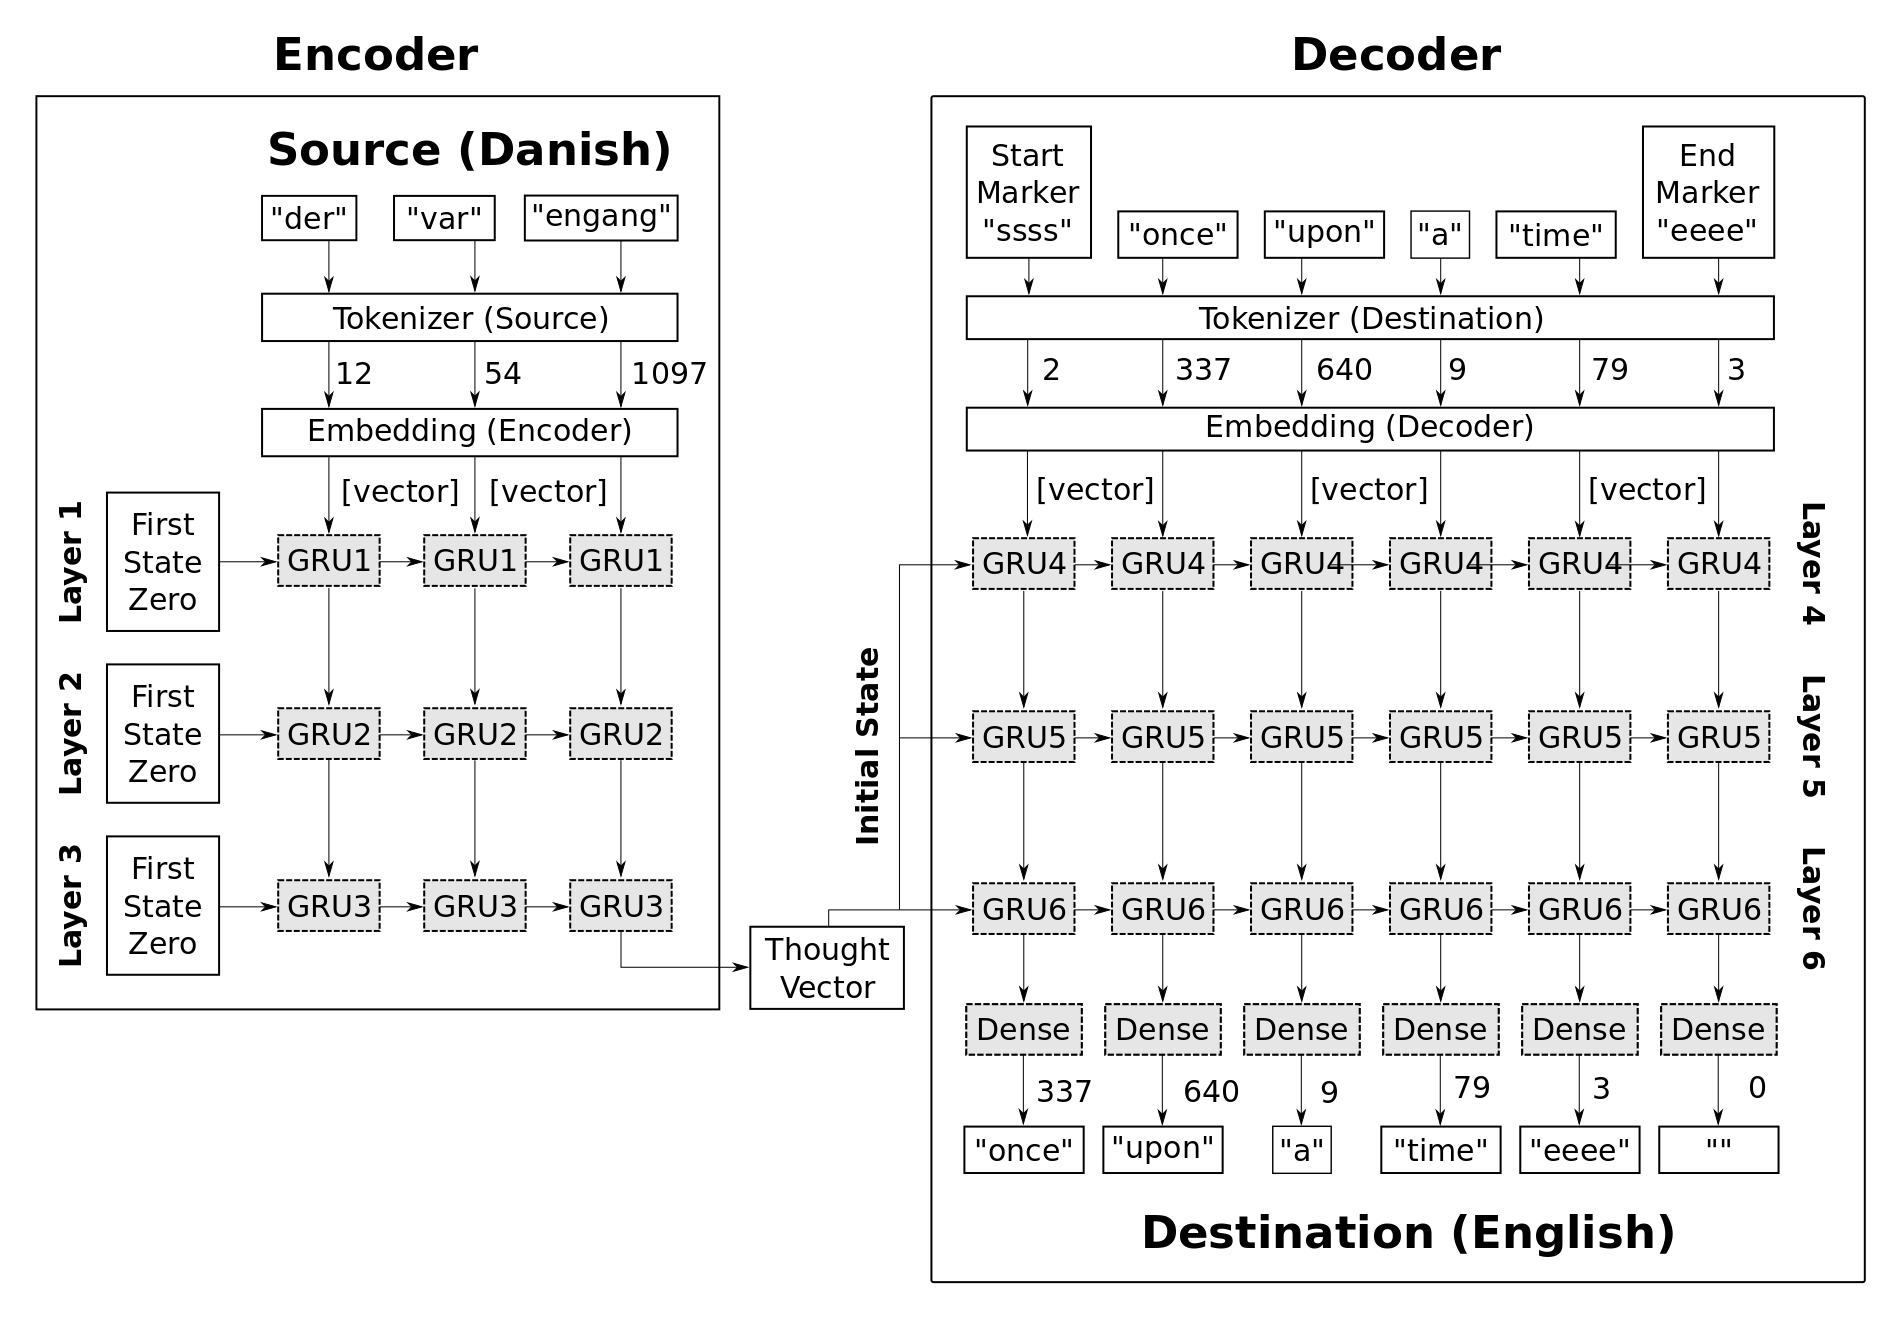

####Encoder:
Usaremos la llamada API funcional de Keras para esto, donde primero creamos los objetos para todas las capas de la red neuronal y luego los conectamos, esto permite una mayor flexibilidad que la llamada API secuencial en Keras, que es útil cuando se experimenta con arquitecturas más complicadas y formas de conectar el codificador y el decodificador.

In [ ]:
encoder_input = Input(shape=(None, ), name='encoder_input')

In [ ]:
embedding_size = 128
encoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,
                              name='encoder_embedding')

In [ ]:
state_size = 512
encoder_gru1 = GRU(state_size, name='encoder_gru1',
                   return_sequences=True)
encoder_gru2 = GRU(state_size, name='encoder_gru2',
                   return_sequences=True)
encoder_gru3 = GRU(state_size, name='encoder_gru3',
                   return_sequences=False)

In [ ]:
def connect_encoder():
    # Start the neural network with its input-layer.
    net = encoder_input

    # Connect the embedding-layer.
    net = encoder_embedding(net)

    # Connect all the GRU-layers.
    net = encoder_gru1(net)
    net = encoder_gru2(net)
    net = encoder_gru3(net)

    # This is the output of the encoder.
    encoder_output = net

    return encoder_output

Observe cómo el codificador usa la salida normal de su última capa GRU como el "vector de pensamiento". Los trabajos de investigación suelen utilizar el estado interno de la última capa recurrente del codificador como "vector de pensamiento". Pero esto hace que la implementación sea más complicada y no es necesario cuando se usa la GRU. Pero si estuviera usando el LSTM en su lugar, entonces es necesario usar los estados internos del LSTM como el "vector de pensamiento" porque en realidad tiene dos vectores internos, que necesitaríamos para inicializar los dos estados internos de las unidades LSTM del decodificador.

Ahora podemos usar esta función para conectar todas las capas en el codificador para que pueda conectarse al decodificador más abajo.

In [ ]:
encoder_output = connect_encoder()

####Decoder:
Cree la parte del decodificador que asigna el "vector de pensamiento" a una secuencia de tokens enteros.

El decodificador toma dos entradas. Primero necesita el "vector de pensamiento" producido por el codificador que resume el contenido del texto de entrada.

In [ ]:
decoder_initial_state = Input(shape=(state_size,),
                              name='decoder_initial_state')
decoder_input = Input(shape=(None, ), name='decoder_input')
decoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,
                              name='decoder_embedding')

In [ ]:
decoder_gru1 = GRU(state_size, name='decoder_gru1',
                   return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                   return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True)

In [ ]:
decoder_dense = Dense(num_words,
                      activation='softmax',
                      name='decoder_output')

In [ ]:
def connect_decoder(initial_state):
    # Start the decoder-network with its input-layer.
    net = decoder_input

    # Connect the embedding-layer.
    net = decoder_embedding(net)

    # Connect all the GRU-layers.
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)

    # Connect the final dense layer that converts to
    # one-hot encoded arrays.
    decoder_output = decoder_dense(net)

    return decoder_output

#### Conectar y crear los modelos

Ahora podemos conectar el codificador y el decodificador de diferentes maneras.

Primero, conectamos el codificador directamente al decodificador para que sea un modelo completo que se pueda entrenar de principio a fin. Esto significa que el estado inicial de las unidades GRU del decodificador se establece en la salida del codificador.

In [ ]:
decoder_output = connect_decoder(initial_state=encoder_output)

model_train = Model(inputs=[encoder_input, decoder_input],
                    outputs=[decoder_output])

In [ ]:
model_encoder = Model(inputs=[encoder_input],
                      outputs=[encoder_output])

In [ ]:
decoder_output = connect_decoder(initial_state=decoder_initial_state)

model_decoder = Model(inputs=[decoder_input, decoder_initial_state],
                      outputs=[decoder_output])

###Parte 5: Entrenamiento:


In [ ]:
model_train.compile(optimizer=RMSprop(lr=1e-3),
                    loss='sparse_categorical_crossentropy')

Durante el entrenamiento, queremos guardar puntos de control y registrar el progreso en TensorBoard para crear las devoluciones de llamadas adecuadas para Keras.

Esta es la devolución de llamada para escribir puntos de control durante el entrenamiento.

In [ ]:
path_checkpoint = '21_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

Esta es la devolución de llamada para detener la optimización cuando el rendimiento empeora en el conjunto de validación.

In [ ]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=3, verbose=1)

Esta es la devolución de llamada para escribir el registro de TensorBoard durante el entrenamiento.

In [ ]:
callback_tensorboard = TensorBoard(log_dir='./21_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [ ]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard]

In [ ]:
try:
    model_train.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [ ]:
x_data = \
{
    'encoder_input': encoder_input_data,
    'decoder_input': decoder_input_data
}

In [ ]:
y_data = \
{
    'decoder_output': decoder_output_data
}

In [ ]:
validation_split = 10000 / len(encoder_input_data)
validation_split

In [ ]:
model_train.fit(x=x_data,
                y=y_data,
                batch_size=512,
                epochs=10,
                validation_split=validation_split,
                callbacks=callbacks)

###Parte 6: Test

Esta función traduce un texto del idioma de origen al idioma de destino y, opcionalmente, imprime una traducción verdadera.

In [ ]:
def translate(input_text, true_output_text=None):
    """Translate a single text-string."""

    # Convert the input-text to integer-tokens.
    # Note the sequence of tokens has to be reversed.
    # Padding is probably not necessary.
    input_tokens = tokenizer_src.text_to_tokens(text=input_text,
                                                reverse=True,
                                                padding=True)

    # Get the output of the encoder's GRU which will be
    # used as the initial state in the decoder's GRU.
    # This could also have been the encoder's final state
    # but that is really only necessary if the encoder
    # and decoder use the LSTM instead of GRU because
    # the LSTM has two internal states.
    initial_state = model_encoder.predict(input_tokens)

    # Max number of tokens / words in the output sequence.
    max_tokens = tokenizer_dest.max_tokens

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int

        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
            'decoder_initial_state': initial_state,
            'decoder_input': decoder_input_data
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict(), but it would make the code
        # much more complicated.

        # Input this data to the decoder and get the predicted output.
        decoder_output = model_decoder.predict(x_data)

        # Get the last predicted token as a one-hot encoded array.
        token_onehot = decoder_output[0, count_tokens, :]

        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer_dest.token_to_word(token_int)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # Sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]

    # Print the input-text.
    print("Input text:")
    print(input_text)
    print()

    # Print the translated output-text.
    print("Translated text:")
    print(output_text)
    print()

    # Optionally print the true translated text.
    if true_output_text is not None:
        print("True output text:")
        print(true_output_text)
        print()

In [ ]:
translate(input_text="Perdone, me puede indicar cómo ir al metro al centro",
          true_output_text='Excuse me, can you tell me how to go to the subway to the center')

In [ ]:
idx = 3
translate(input_text=data_src[idx],
          true_output_text=data_dest[idx])

#**POS Tagging:**
etiquetado de parte del discurso (POS), el proceso de asignar una etiqueta de parte del discurso (sustantivo, verbo, adjetivo...) a cada palabra en un texto de entrada. El etiquetado es difícil porque algunas palabras pueden representar más de una parte del discurso en diferentes momentos.

In [36]:
import pandas as pd
from collections import defaultdict
import math
import numpy as np

## Parte 0: Fuentes de datos
Esta tarea utilizará dos conjuntos de datos etiquetados recopilados del **Wall Street Journal (WSJ)**.

[Aquí](http://relearn.be/2015/training-common-sense/sources/software/pattern-2.6-critical-fork/docs/html/mbsp-tags.html) hay un ejemplo de 'conjunto de etiquetas' o designación de parte del discurso que describe la etiqueta de dos o tres letras y su significado.
- Se usará un conjunto de datos (**WSJ-2_21.pos**) para **entrenamiento**.
- El otro (**WSJ-24.pos**) para **pruebas**.
- Los datos de entrenamiento etiquetados han sido preprocesados para formar un vocabulario (**hmm_vocab.txt**).
- Las palabras del vocabulario son palabras del conjunto de entrenamiento que se usaron dos o más veces.
- El vocabulario se amplía con un conjunto de 'fichas de palabras desconocidas', que se describen a continuación.
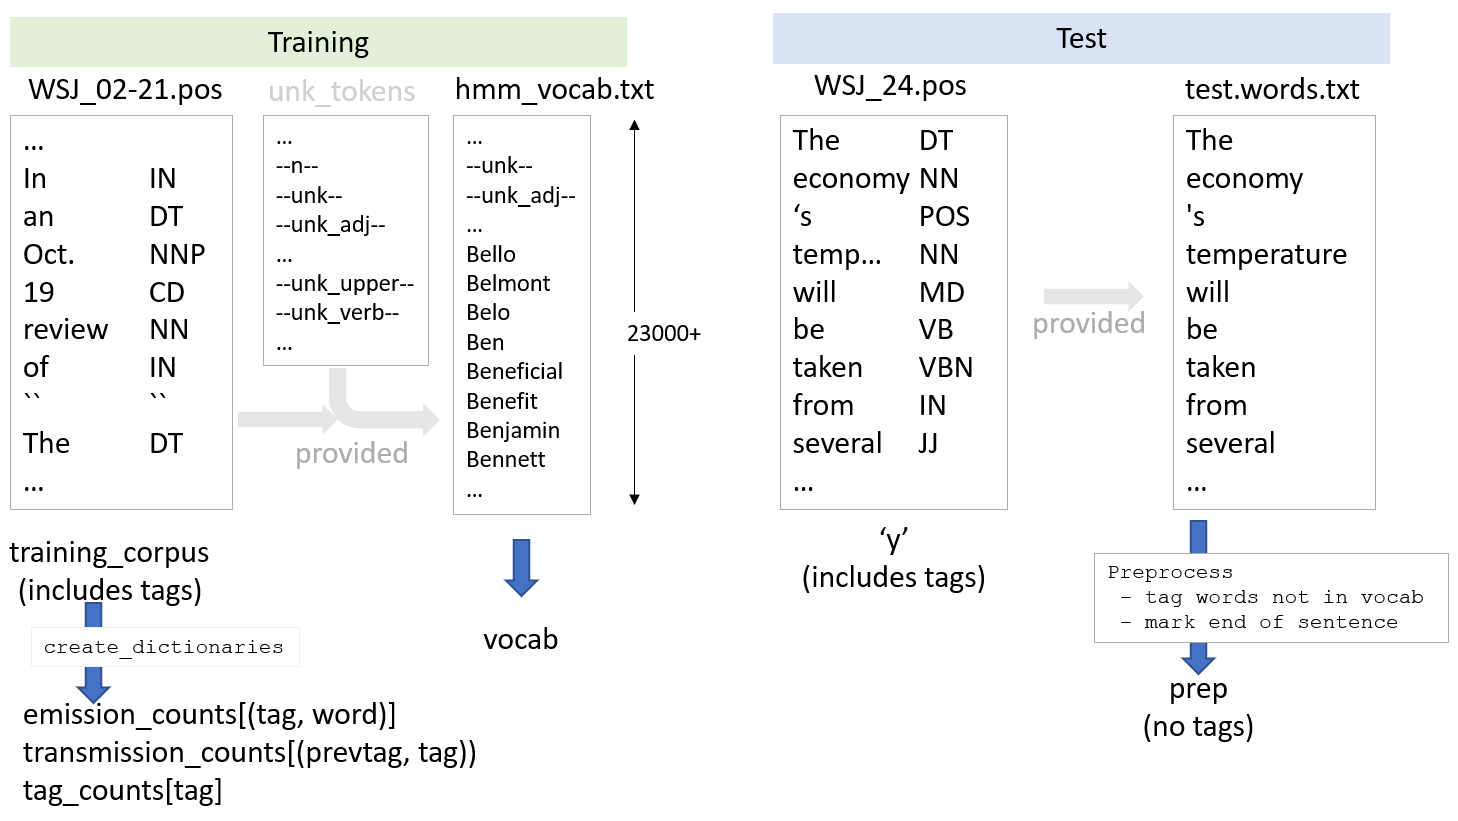

In [37]:
with open("WSJ_02-21.pos", 'r') as f:
    training_corpus = f.readlines()

print(f"A few items of the training corpus list")
print(training_corpus[0:5])

A few items of the training corpus list
['In\tIN\n', 'an\tDT\n', 'Oct.\tNNP\n', '19\tCD\n', 'review\tNN\n']


In [38]:
with open("hmm_vocab.txt", 'r') as f:
    voc_l = f.read().split('\n')

print("A few items of the vocabulary list")
print(voc_l[0:50])
print()
print("A few items at the end of the vocabulary list")
print(voc_l[-50:])

A few items of the vocabulary list
['!', '#', '$', '%', '&', "'", "''", "'40s", "'60s", "'70s", "'80s", "'86", "'90s", "'N", "'S", "'d", "'em", "'ll", "'m", "'n'", "'re", "'s", "'til", "'ve", '(', ')', ',', '-', '--', '--n--', '--unk--', '--unk_adj--', '--unk_adv--', '--unk_digit--', '--unk_noun--', '--unk_punct--', '--unk_upper--', '--unk_verb--', '.', '...', '0.01', '0.0108', '0.02', '0.03', '0.05', '0.1', '0.10', '0.12', '0.13', '0.15']

A few items at the end of the vocabulary list
['yards', 'yardstick', 'year', 'year-ago', 'year-before', 'year-earlier', 'year-end', 'year-on-year', 'year-round', 'year-to-date', 'year-to-year', 'yearlong', 'yearly', 'years', 'yeast', 'yelled', 'yelling', 'yellow', 'yen', 'yes', 'yesterday', 'yet', 'yield', 'yielded', 'yielding', 'yields', 'you', 'young', 'younger', 'youngest', 'youngsters', 'your', 'yourself', 'youth', 'youthful', 'yuppie', 'yuppies', 'zero', 'zero-coupon', 'zeroing', 'zeros', 'zinc', 'zip', 'zombie', 'zone', 'zones', 'zoning', '{',

In [39]:
vocab = {}

# Get the index of the corresponding words.
for i, word in enumerate(sorted(voc_l)):
    vocab[word] = i

print("Vocabulary dictionary, key is the word, value is a unique integer")
cnt = 0
for k,v in vocab.items():
    print(f"{k}:{v}")
    cnt += 1
    if cnt > 20:
        break

Vocabulary dictionary, key is the word, value is a unique integer
:0
!:1
#:2
$:3
%:4
&:5
':6
'':7
'40s:8
'60s:9
'70s:10
'80s:11
'86:12
'90s:13
'N:14
'S:15
'd:16
'em:17
'll:18
'm:19
'n':20


In [40]:
with open("WSJ_24.pos", 'r') as f:
    y = f.readlines()

print("A sample of the test corpus")
print(y[0:10])

A sample of the test corpus
['The\tDT\n', 'economy\tNN\n', "'s\tPOS\n", 'temperature\tNN\n', 'will\tMD\n', 'be\tVB\n', 'taken\tVBN\n', 'from\tIN\n', 'several\tJJ\n', 'vantage\tNN\n']


####Funciones utiles

In [41]:
import string


# Punctuation characters
punct = set(string.punctuation)

# Morphology rules used to assign unknown word tokens
noun_suffix = ["action", "age", "ance", "cy", "dom", "ee", "ence", "er", "hood", "ion", "ism", "ist", "ity", "ling", "ment", "ness", "or", "ry", "scape", "ship", "ty"]
verb_suffix = ["ate", "ify", "ise", "ize"]
adj_suffix = ["able", "ese", "ful", "i", "ian", "ible", "ic", "ish", "ive", "less", "ly", "ous"]
adv_suffix = ["ward", "wards", "wise"]


def get_word_tag(line, vocab):
    if not line.split():
        word = "--n--"
        tag = "--s--"
        return word, tag
    else:
        word, tag = line.split()
        if word not in vocab:
            # Handle unknown words
            word = assign_unk(word)
        return word, tag
    return None


def preprocess(vocab, data_fp):
    """
    Preprocess data
    """
    orig = []
    prep = []

    # Read data
    with open(data_fp, "r") as data_file:

        for cnt, word in enumerate(data_file):

            # End of sentence
            if not word.split():
                orig.append(word.strip())
                word = "--n--"
                prep.append(word)
                continue

            # Handle unknown words
            elif word.strip() not in vocab:
                orig.append(word.strip())
                word = assign_unk(word)
                prep.append(word)
                continue

            else:
                orig.append(word.strip())
                prep.append(word.strip())

    assert(len(orig) == len(open(data_fp, "r").readlines()))
    assert(len(prep) == len(open(data_fp, "r").readlines()))

    return orig, prep


def assign_unk(tok):
    """
    Assign unknown word tokens
    """
    # Digits
    if any(char.isdigit() for char in tok):
        return "--unk_digit--"

    # Punctuation
    elif any(char in punct for char in tok):
        return "--unk_punct--"

    # Upper-case
    elif any(char.isupper() for char in tok):
        return "--unk_upper--"

    # Nouns
    elif any(tok.endswith(suffix) for suffix in noun_suffix):
        return "--unk_noun--"

    # Verbs
    elif any(tok.endswith(suffix) for suffix in verb_suffix):
        return "--unk_verb--"

    # Adjectives
    elif any(tok.endswith(suffix) for suffix in adj_suffix):
        return "--unk_adj--"

    # Adverbs
    elif any(tok.endswith(suffix) for suffix in adv_suffix):
        return "--unk_adv--"

    return "--unk--"


In [ ]:
_, prep = preprocess(vocab, "test.words")

print('The length of the preprocessed test corpus: ', len(prep))
print('This is a sample of the test_corpus: ')
print(prep[0:10])

The length of the preprocessed test corpus:  34199
This is a sample of the test_corpus: 
['The', 'economy', "'s", 'temperature', 'will', 'be', 'taken', 'from', 'several', '--unk--']


###Parte 1: Parts-of-speech tagging
Comenzará con el etiquetador de partes del discurso más simple posible y lo desarrollaremos hasta llegar al estado del arte.

En esta sección, encontrará las palabras que no son ambiguas.
- Por ejemplo, la palabra `is` es un verbo y no es ambiguo.
- En el corpus `WSJ`, $86$% del token no son ambiguos (lo que significa que solo tienen una etiqueta)
- Alrededor de $14\%$ son ambiguos (lo que significa que tienen más de una etiqueta)

#### Recuentos de transición
- El primer diccionario es el diccionario `transition_counts` que calcula el número de veces que cada etiqueta pasó junto a otra etiqueta.

Este diccionario se utilizará para calcular:
$$P(t_i |t_{i-1}) \tag{1}$$

Esta es la probabilidad de una etiqueta en la posición $i$ dada la etiqueta en la posición $i-1$.

#### Recuentos de emisiones

El segundo diccionario que calculará es el diccionario `emission_counts`. Este diccionario se utilizará para calcular:

$$P(w_i|t_i)\tag{2}$$

En otras palabras, lo usará para calcular la probabilidad de una palabra dada su etiqueta.

#### Número de etiquetas

El último diccionario que calculará es el diccionario `tag_counts`.
- La clave es la etiqueta
- El valor es el número de veces que apareció cada etiqueta.

In [43]:
def create_dictionaries(training_corpus, vocab):
    # initialize the dictionaries using defaultdict
    emission_counts = defaultdict(int)
    transition_counts = defaultdict(int)
    tag_counts = defaultdict(int)

    # Initialize "prev_tag" (previous tag) with the start state, denoted by '--s--'
    prev_tag = '--s--'

    # use 'i' to track the line number in the corpus
    i = 0

    # Each item in the training corpus contains a word and its POS tag
    # Go through each word and its tag in the training corpus
    for word_tag in training_corpus:

        # Increment the word_tag count
        i += 1

        # Every 50,000 words, print the word count
        if i % 50000 == 0:
            print(f"word count = {i}")

        # get the word and tag using the get_word_tag helper function (imported from utils_pos.py)
        word, tag = get_word_tag(word_tag,vocab)

        # Increment the transition count for the previous word and tag
        transition_counts[(prev_tag, tag)] += 1

        # Increment the emission count for the tag and word
        emission_counts[(tag, word)] += 1

        # Increment the tag count
        tag_counts[tag] += 1

        # Set the previous tag to this tag (for the next iteration of the loop)
        prev_tag = tag


    return emission_counts, transition_counts, tag_counts

In [44]:
emission_counts, transition_counts, tag_counts = create_dictionaries(training_corpus, vocab)

word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000


In [45]:
states = sorted(tag_counts.keys())
print(f"Number of POS tags (number of 'states'): {len(states)}")
print("View these POS tags (states)")
print(states)

Number of POS tags (number of 'states'): 46
View these POS tags (states)
['#', '$', "''", '(', ')', ',', '--s--', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']


In [46]:
print("transition examples: ")
for ex in list(transition_counts.items())[:3]:
    print(ex)
print()

print("emission examples: ")
for ex in list(emission_counts.items())[200:203]:
    print (ex)
print()

print("ambiguous word example: ")
for tup,cnt in emission_counts.items():
    if tup[1] == 'back': print (tup, cnt)

transition examples: 
(('--s--', 'IN'), 5050)
(('IN', 'DT'), 32364)
(('DT', 'NNP'), 9044)

emission examples: 
(('DT', 'any'), 721)
(('NN', 'decrease'), 7)
(('NN', 'insider-trading'), 5)

ambiguous word example: 
('RB', 'back') 304
('VB', 'back') 20
('RP', 'back') 84
('JJ', 'back') 25
('NN', 'back') 29
('VBP', 'back') 4


#### Pruebas

Ahora probará la precisión de su etiquetador de partes del discurso usando su diccionario `emission_counts`.
- Dado su corpus de prueba preprocesado `prep`, asignará una etiqueta de partes del discurso a cada palabra en ese corpus.
- Usando el corpus de prueba etiquetado original `y`, luego calculará qué porcentaje de las etiquetas obtuvo correctamente.

In [47]:
def predict_pos(prep, y, emission_counts, vocab, states):
    # Initialize the number of correct predictions to zero
    num_correct = 0

    # Get the (tag, word) tuples, stored as a set
    all_words = set(emission_counts.keys())

    # Get the number of (word, POS) tuples in the corpus 'y'
    total = len(y)
    for word, y_tup in zip(prep, y):

        # Split the (word, POS) string into a list of two items
        y_tup_l = y_tup.split()

        # Verify that y_tup contain both word and POS
        if len(y_tup_l) == 2:

            # Set the true POS label for this word
            true_label = y_tup_l[1]

        else:
            # If the y_tup didn't contain word and POS, go to next word
            continue

        count_final = 0
        pos_final = ''

        # If the word is in the vocabulary...
        if word in vocab:
            for pos in states:


                # define the key as the tuple containing the POS and word
                key = (pos,word)

                # check if the (pos, word) key exists in the emission_counts dictionary
                if key in emission_counts: # complete this line

                # get the emission count of the (pos,word) tuple
                    count = emission_counts[key]

                    # keep track of the POS with the largest count
                    if count>count_final: # complete this line

                        # update the final count (largest count)
                        count_final = count

                        # update the final POS
                        pos_final = pos

            # If the final POS (with the largest count) matches the true POS:
            if pos_final == true_label: # complete this line

                # Update the number of correct predictions
                num_correct += 1

    accuracy = num_correct / total

    return accuracy

In [48]:
accuracy_predict_pos = predict_pos(prep, y, emission_counts, vocab, states)
print(f"Accuracy of prediction using predict_pos is {accuracy_predict_pos:.4f}")

Accuracy of prediction using predict_pos is 0.8889


### Parte 2: Modelos ocultos de Markov para POS

Ahora construirá algo más específico para el contexto. Concretamente, estarás implementando un Modelo Oculto de Markov (HMM) con un decodificador Viterbi
- El HMM es uno de los algoritmos más utilizados en el procesamiento del lenguaje natural y es la base de muchas técnicas de aprendizaje profundo que verá en esta especialización.
- Además del etiquetado de partes del discurso, HMM se utiliza en reconocimiento de voz, síntesis de voz, etc.
- Al completar esta parte de la tarea, obtendrá una precisión del 95 % en el mismo conjunto de datos que utilizó en la Parte 1.

El modelo de Markov contiene una serie de estados y la probabilidad de transición entre esos estados.
- En este caso, los estados son las partes del discurso.
- Un modelo de Markov utiliza una matriz de transición, `A`.
- Un Modelo Oculto de Markov añade una matriz de observación o emisión `B` que describe la probabilidad de una observación visible cuando estamos en un estado particular.
- En este caso, las emisiones son las palabras del corpus
- El estado, que está oculto, es la etiqueta POS de esa palabra.

#### Parte 2.1 Generación de matrices

#### Creando la matriz de probabilidades de transición 'A'
Ahora que tiene sus `emission_counts`, `transition_counts` y `tag_counts`, comenzará a implementar el modelo oculto de Markov.

Esto le permitirá construir rápidamente el
- Matriz de probabilidades de transición `A`.
- y la matriz de probabilidades de emisión `B`.

También usará algo de suavizado cuando calcule estas matrices.

Aquí hay un ejemplo de cómo se vería la matriz de transición 'A' (se simplifica a 5 etiquetas para ver. Tiene 46x46 en esta asignación):


|**A** |...| SBR | PR | SIM | A | EH|...
| --- ||---:------------| ------------ | ------------ | -------- | ---------- |----
|**RBS** |...|2.217069e-06 |2.217069e-06 |2.217069e-06 |0.008870 |2.217069e-06|...
|**RP** |...|3.756509e-07 |7.516775e-04 |3.756509e-07 |0.051089 |3.756509e-07|...
|**SYM** |...|1.722772e-05 |1.722772e-05 |1.722772e-05 |0.000017 |1.722772e-05|...
|**A** |...|4.477336e-05 |4.472863e-08 |4.472863e-08 |0.000090 |4.477336e-05|...
|**UH** |...|1.030439e-05 |1.030439e-05 |1.030439e-05 |0.061837 |3.092348e-02|...
| ... |...| ... | ... | ... | ... | ... | ...

Tenga en cuenta que la matriz anterior se calculó con suavizado.

Cada celda te da la probabilidad de pasar de una parte del discurso a otra.
- En otras palabras, hay una probabilidad de 4.47e-8 de pasar de las partes del discurso `TO` a `RP`.
- La suma de cada fila debe ser igual a 1, porque asumimos que la próxima etiqueta POS debe ser una de las columnas disponibles en la tabla.

El alisado se realizó de la siguiente manera:

$$ P(t_i | t_{i-1}) = \frac{C(t_{i-1}, t_{i}) + \alpha }{C(t_{i-1}) +\alpha * N}\tag{3}$$

- $N$ es el número total de etiquetas
- $C(t_{i-1}, t_{i})$ es el recuento de la tupla (POS anterior, POS actual) en el diccionario `transition_counts`.
- $C(t_{i-1})$ es el conteo de los POS anteriores en el diccionario `tag_counts`.
- $\alpha$ es un parámetro de suavizado.

In [49]:
def create_transition_matrix(alpha, tag_counts, transition_counts):
    # Get a sorted list of unique POS tags
    all_tags = sorted(tag_counts.keys())

    # Count the number of unique POS tags
    num_tags = len(all_tags)

    # Initialize the transition matrix 'A'
    A = np.zeros((num_tags,num_tags))

    # Get the unique transition tuples (previous POS, current POS)
    trans_keys = set(transition_counts.keys())

    # Go through each row of the transition matrix A
    for i in range(num_tags):

        # Go through each column of the transition matrix A
        for j in range(num_tags):

            # Initialize the count of the (prev POS, current POS) to zero
            count = 0

            # Define the tuple (prev POS, current POS)
            # Get the tag at position i and tag at position j (from the all_tags list)
            key = (all_tags[i],all_tags[j])

            # Check if the (prev POS, current POS) tuple
            # exists in the transition counts dictionaory
            if key in transition_counts: #complete this line

                # Get count from the transition_counts dictionary
                # for the (prev POS, current POS) tuple
                count = transition_counts[key]

            # Get the count of the previous tag (index position i) from tag_counts
            count_prev_tag = tag_counts[all_tags[i]]

            # Apply smoothing using count of the tuple, alpha,
            # count of previous tag, alpha, and number of total tags
            A[i,j] = (count + alpha) / (count_prev_tag + alpha*num_tags)
    return A

In [50]:
alpha = 0.001
for i in range(46):
    tag_counts.pop(i,None)

A = create_transition_matrix(alpha, tag_counts, transition_counts)
# Testing your function
print(f"A at row 0, col 0: {A[0,0]:.9f}")
print(f"A at row 3, col 1: {A[3,1]:.4f}")

#print("View a subset of transition matrix A")
A_sub = pd.DataFrame(A[30:35,30:35], index=states[30:35], columns = states[30:35] )
print(A_sub)

A at row 0, col 0: 0.000007040
A at row 3, col 1: 0.1691
              RBS            RP           SYM        TO            UH
RBS  2.217069e-06  2.217069e-06  2.217069e-06  0.008870  2.217069e-06
RP   3.756509e-07  7.516775e-04  3.756509e-07  0.051089  3.756509e-07
SYM  1.722772e-05  1.722772e-05  1.722772e-05  0.000017  1.722772e-05
TO   4.477336e-05  4.472863e-08  4.472863e-08  0.000090  4.477336e-05
UH   1.030439e-05  1.030439e-05  1.030439e-05  0.061837  3.092348e-02


### Crear la matriz de probabilidades de emisión 'B'

Ahora creará la matriz de transición 'B' que calcula la probabilidad de emisión.

Utilizará el suavizado como se define a continuación:

$$P(w_i | t_i) = \frac{C(t_i, word_i)+ \alpha}{C(t_{i}) +\alpha * N}\tag{4}$$

- $C(t_i, word_i)$ es el número de veces que $word_i$ se asoció con $tag_i$ en los datos de entrenamiento (almacenados en el diccionario `emission_counts`).
- $C(t_i)$ es el número de veces que $tag_i$ estuvo en los datos de entrenamiento (almacenados en el diccionario `tag_counts`).
- $N$ es el número de palabras en el vocabulario
- $\alpha$ es un parámetro de suavizado.

La matriz `B` es de dimensión (num_tags, N), donde num_tags es el número de posibles etiquetas de partes del discurso.

Aquí hay un ejemplo de la matriz, solo se muestra un subconjunto de etiquetas y palabras:
<p style='text-align: center;'> <b>Matriz de probabilidad de emisiones B (subconjunto)</b> </p>

|**B**| ...| 725 | hábilmente | ingenieros | promovido | sinergia| ...|
|----|----|--------------|--------------|--------------|--------------|------------|----|
|**CD** | ...| **8.201296e-05** | 2.732854e-08 | 2.732854e-08 | 2.732854e-08 | 2.732854e-08| ...|
|**NN** | ...| 7.521128e-09 | 7.521128e-09 | 7.521128e-09 | 7.521128e-09 | **2.257091e-05**| ...|
|**NNS** | ...| 1.670013e-08 | 1.670013e-08 |**4.676203e-04** | 1.670013e-08 | 1.670013e-08| ...|
|**VB** | ...| 3.779036e-08 | 3.779036e-08 | 3.779036e-08 | 3.779036e-08 | 3.779036e-08| ...|
|**RB** | ...| 3.226454e-08 | **6.456135e-05** | 3.226454e-08 | 3.226454e-08 | 3.226454e-08| ...|
|**PR** | ...| 3.723317e-07 | 3.723317e-07 | 3.723317e-07 | **3.723317e-07** | 3.723317e-07| ...|
| ... | ...| ... | ... | ... | ... | ... | ...|

In [51]:
def create_emission_matrix(alpha, tag_counts, emission_counts, vocab):
    # get the number of POS tag
    num_tags = len(tag_counts)

    # Get a list of all POS tags
    all_tags = sorted(tag_counts.keys())

    # Get the total number of unique words in the vocabulary
    num_words = len(vocab)

    # Initialize the emission matrix B with places for
    # tags in the rows and words in the columns
    B = np.zeros((num_tags, num_words))

    # Get a set of all (POS, word) tuples
    # from the keys of the emission_counts dictionary
    emis_keys = set(list(emission_counts.keys()))

    # Go through each row (POS tags)
    for i in range(num_tags): # complete this line

        # Go through each column (words)
        for j in range(num_words): # complete this line

            # Initialize the emission count for the (POS tag, word) to zero
            count = 0

            # Define the (POS tag, word) tuple for this row and column
            key = (all_tags[i],vocab[j])
            # check if the (POS tag, word) tuple exists as a key in emission counts
            if key in emission_counts.keys(): # complete this line

                # Get the count of (POS tag, word) from the emission_counts d
                count = emission_counts[key]

            # Get the count of the POS tag
            count_tag = tag_counts[all_tags[i]]

            # Apply smoothing and store the smoothed value
            # into the emission matrix B for this row and column
            B[i,j] = (count + alpha) / (count_tag+ alpha*num_words)

    return B

In [52]:
for i in range(46):
    tag_counts.pop(i,None)

B = create_emission_matrix(alpha, tag_counts, emission_counts, list(vocab))

print(f"View Matrix position at row 0, column 0: {B[0,0]:.9f}")
print(f"View Matrix position at row 3, column 1: {B[3,1]:.9f}")

# Try viewing emissions for a few words in a sample dataframe
cidx  = ['725','adroitly','engineers', 'promoted', 'synergy']

# Get the integer ID for each word
cols = [vocab[a] for a in cidx]

# Choose POS tags to show in a sample dataframe
rvals =['CD','NN','NNS', 'VB','RB','RP']

# For each POS tag, get the row number from the 'states' list
rows = [states.index(a) for a in rvals]

# Get the emissions for the sample of words, and the sample of POS tags
B_sub = pd.DataFrame(B[np.ix_(rows,cols)], index=rvals, columns = cidx )
print(B_sub)


View Matrix position at row 0, column 0: 0.000006032
View Matrix position at row 3, column 1: 0.000000720
              725      adroitly     engineers      promoted       synergy
CD   8.201296e-05  2.732854e-08  2.732854e-08  2.732854e-08  2.732854e-08
NN   7.521128e-09  7.521128e-09  7.521128e-09  7.521128e-09  2.257091e-05
NNS  1.670013e-08  1.670013e-08  4.676203e-04  1.670013e-08  1.670013e-08
VB   3.779036e-08  3.779036e-08  3.779036e-08  3.779036e-08  3.779036e-08
RB   3.226454e-08  6.456135e-05  3.226454e-08  3.226454e-08  3.226454e-08
RP   3.723317e-07  3.723317e-07  3.723317e-07  3.723317e-07  3.723317e-07


### Parte 3: Algoritmo de Viterbi y Programación Dinámica

En esta parte de la tarea, implementará el algoritmo de Viterbi que hace uso de la programación dinámica. Específicamente, usará sus dos matrices, `A` y `B` para calcular el algoritmo de Viterbi. Hemos descompuesto este proceso en tres pasos principales para usted.

* **Inicialización**: en esta parte, inicializa las matrices `best_paths` y `best_probabilidades` que completará en `feed_forward`.
* **Feed forward**: en cada paso, calcula la probabilidad de que ocurra cada camino y los mejores caminos hasta ese punto.
* **Alimentar hacia atrás**: Esto le permite encontrar el mejor camino con las probabilidades más altas.

<un nombre='3.1'></a>
#### Parte 3.1: Inicialización

Comenzará inicializando dos matrices de la misma dimensión.

- best_probs: Cada celda contiene la probabilidad de pasar de una etiqueta POS a una palabra en el corpus.

- best_paths: una matriz que lo ayuda a rastrear la mejor ruta posible en el corpus.

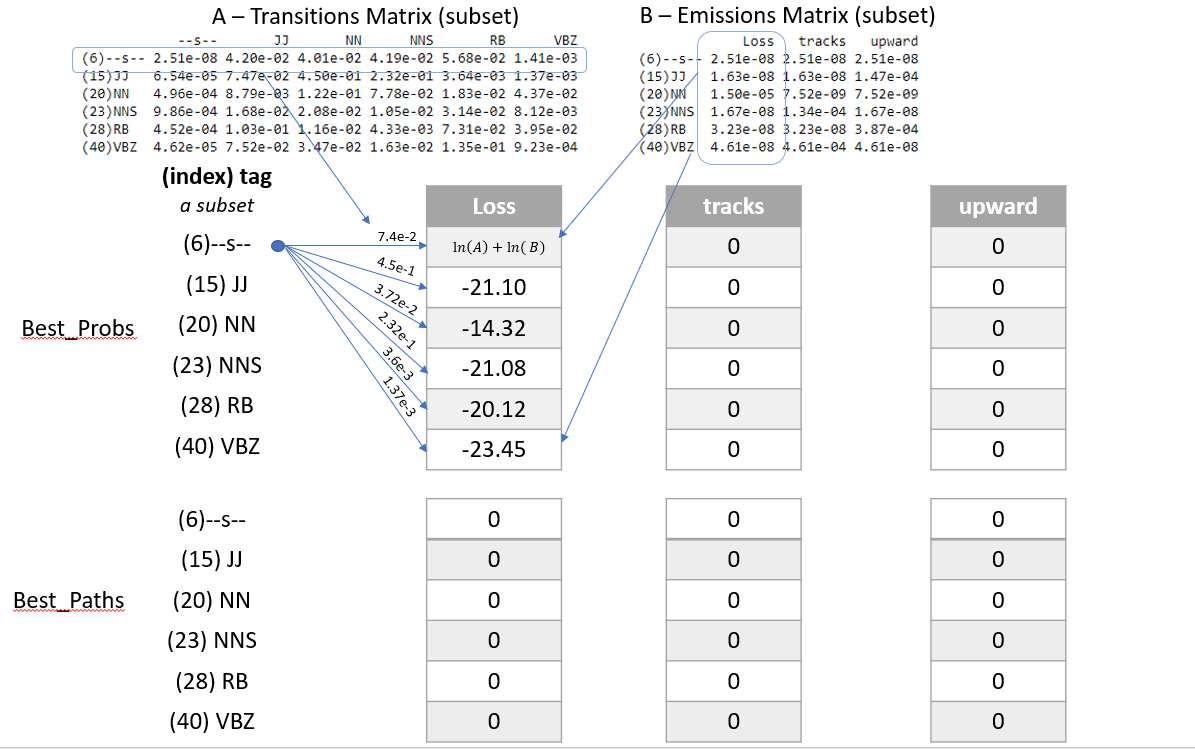

In [53]:
def initialize(states, tag_counts, A, B, corpus, vocab):
    # Get the total number of unique POS tags
    num_tags = len(tag_counts)

    # Initialize best_probs matrix
    # POS tags in the rows, number of words in the corpus as the columns
    best_probs = np.zeros((num_tags, len(corpus)))

    # Initialize best_paths matrix
    # POS tags in the rows, number of words in the corpus as columns
    best_paths = np.zeros((num_tags, len(corpus)), dtype=int)

    # Define the start token
    s_idx = states.index("--s--")
    # Go through each of the POS tags
    for i in range(num_tags): # complete this line

        # Handle the special case when the transition from start token to POS tag i is zero
        if A[s_idx,i] == 0: # complete this line

            # Initialize best_probs at POS tag 'i', column 0, to negative infinity
            best_probs[i,0] = float('-inf')

        # For all other cases when transition from start token to POS tag i is non-zero:
        else:

            # Initialize best_probs at POS tag 'i', column 0
            # Check the formula in the instructions above
            best_probs[i,0] = math.log(A[s_idx,i]) + math.log(B[i,vocab[corpus[0]]] )

    return best_probs, best_paths

In [54]:
best_probs, best_paths = initialize(states, tag_counts, A, B, prep, vocab)

In [55]:
print(f"best_probs[0,0]: {best_probs[0,0]:.4f}")
print(f"best_paths[2,3]: {best_paths[2,3]:.4f}")

best_probs[0,0]: -22.6098
best_paths[2,3]: 0.0000


## Parte 3.2 Viterbi Adelante

En esta parte de la tarea, implementará el segmento `viterbi_forward`. En otras palabras, llenará sus matrices `best_probs` y `best_paths`.
- Caminar hacia adelante a través del corpus.
- Para cada palabra, calcule una probabilidad para cada etiqueta posible.
- A diferencia del algoritmo anterior `predict_pos` (el ejercicio de "calentamiento"), este incluirá la ruta hasta esa combinación (palabra, etiqueta).

Aquí hay un ejemplo con un corpus de tres palabras "Pistas de pérdida hacia arriba":
- Tenga en cuenta que, en este ejemplo, solo se muestra un subconjunto de estados (etiquetas POS) en el siguiente diagrama para facilitar la lectura.
- En el siguiente diagrama, la primera palabra "Pérdida" ya está inicializada.
- El algoritmo calculará una probabilidad para cada una de las posibles etiquetas en la segunda y futuras palabras.

Calcule la probabilidad de que la etiqueta de la segunda obra ('pistas') sea un verbo, presente en 3ra persona del singular (VBZ).
- En la matriz `best_probs`, vaya a la columna de la segunda palabra ('tracks') y fila 40 (VBZ), esta celda está resaltada en naranja claro en el diagrama a continuación.
- Examina cada uno de los caminos a partir de las etiquetas de la primera palabra ('Loss') y elige el camino más probable.
- Un ejemplo del cálculo de **una** de esas rutas es la ruta de ('Pérdida', NN) a ('pistas', VBZ).
- El logaritmo de la probabilidad de la ruta hasta la primera palabra 'Pérdida' incluida con la etiqueta NN de POS es de $-14,32$. La matriz `best_probs` contiene este valor -14,32 en la columna de 'Pérdida' y la fila de 'NN'.
- Encuentre la probabilidad de que NN pase a VBZ. Para encontrar esta probabilidad, vaya a la matriz de transición 'A' y vaya a la fila de 'NN' y la columna de 'VBZ'. El valor es $4.37e-02$, que está dentro de un círculo en el diagrama, así que agregue $-14.32 + log(4.37e-02)$.
- Encuentre el logaritmo de la probabilidad de que la etiqueta VBS 'emita' la palabra 'pistas'. Para encontrar esto, mire la matriz de emisión 'B' en la fila 'VBZ' y la columna para la palabra 'pistas'. El valor $4.61e-04$ está encerrado en un círculo en el siguiente diagrama. Entonces agregue $-14.32 + log(4.37e-02) + log(4.61e-04)$.
- La suma de $-14,32 + log(4,37e-02) + log(4,61e-04)$ es $-25,13$. Almacene $-25.13$ en la matriz `best_probs` en la fila 'VBZ' y la columna 'tracks' (como se ve en la celda que está resaltada en naranja claro en el diagrama).
- Se calculan todas las demás rutas en best_probs. Tenga en cuenta que $-25,13$ es mayor que todos los demás valores de la columna 'pistas' de la matriz `best_probs`, por lo que la ruta más probable a 'VBZ' es desde 'NN'. 'NN' está en la fila 20 de la matriz `best_probs`, por lo que $20$ es la ruta más probable.
- Guarda la ruta más probable $20$ en la tabla `best_paths`. Esto está resaltado en naranja claro en el siguiente diagrama.

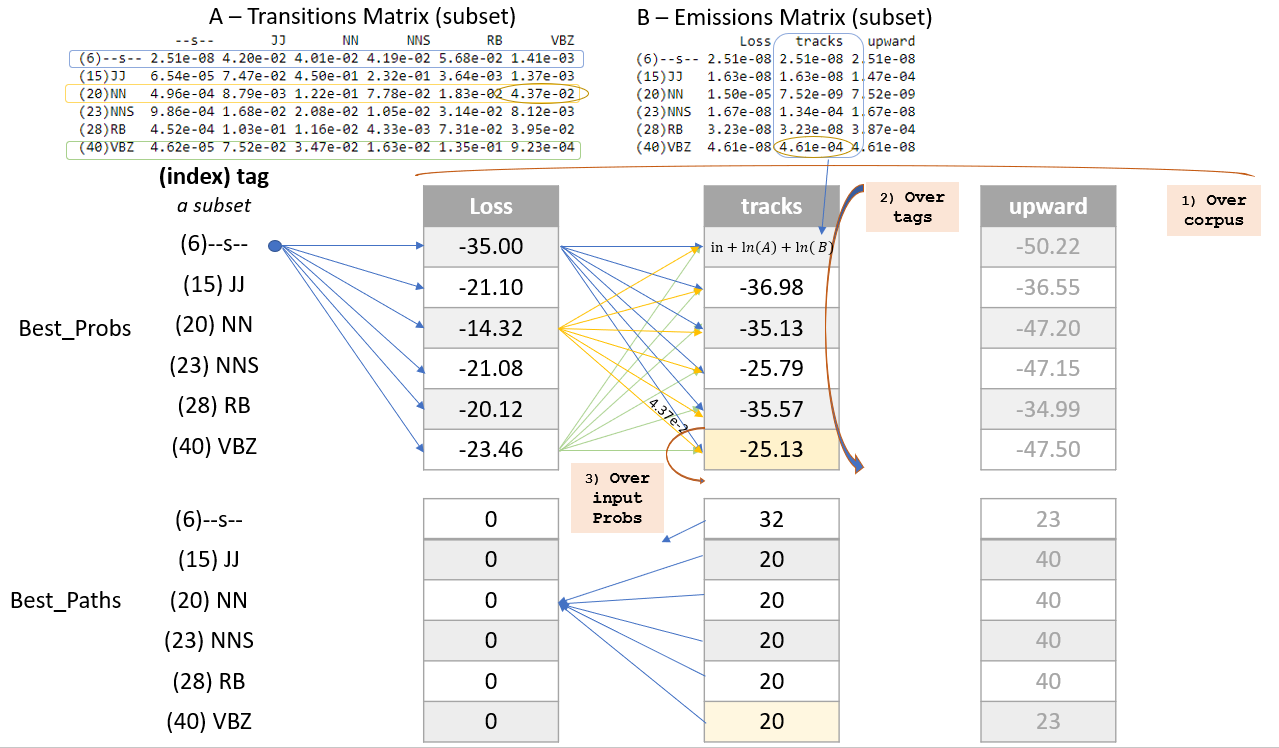

In [56]:
def viterbi_forward(A, B, test_corpus, best_probs, best_paths, vocab):
    # Get the number of unique POS tags (which is the num of rows in best_probs)
    num_tags = best_probs.shape[0]

    # Go through every word in the corpus starting from word 1
    # Recall that word 0 was initialized in `initialize()`
    for i in range(1, len(test_corpus)):

        # Print number of words processed, every 5000 words
        if i % 5000 == 0:
            print("Words processed: {:>8}".format(i))

        # For each unique POS tag that the current word can be
        for j in range(num_tags): # complete this line

            # Initialize best_prob for word i to negative infinity
            best_prob_i =  float("-inf")

            # Initialize best_path for current word i to None
            best_path_i = None

            # For each POS tag that the previous word can be:
            for k in range(num_tags): # complete this line

                # Calculate the probability =
                # best probs of POS tag k, previous word i-1 +
                # log(prob of transition from POS k to POS j) +
                # log(prob that emission of POS j is word i)
                prob = best_probs[k,i-1]+math.log(A[k,j]) +math.log(B[j,vocab[test_corpus[i]]])
                # check if this path's probability is greater than
                # the best probability up to and before this point
                if prob > best_prob_i: # complete this line

                    # Keep track of the best probability
                    best_prob_i = prob

                    # keep track of the POS tag of the previous word
                    # that is part of the best path.
                    # Save the index (integer) associated with
                    # that previous word's POS tag
                    best_path_i = k

            # Save the best probability for the
            # given current word's POS tag
            # and the position of the current word inside the corpus
            best_probs[j,i] = best_prob_i

            # Save the unique integer ID of the previous POS tag
            # into best_paths matrix, for the POS tag of the current word
            # and the position of the current word inside the corpus.
            best_paths[j,i] = best_path_i

    return best_probs, best_paths

In [57]:
best_probs, best_paths = viterbi_forward(A, B, prep, best_probs, best_paths, vocab)

Words processed:     5000
Words processed:    10000
Words processed:    15000
Words processed:    20000
Words processed:    25000
Words processed:    30000


In [58]:
print(f"best_probs[0,1]: {best_probs[0,1]:.4f}")
print(f"best_probs[0,4]: {best_probs[0,4]:.4f}")

best_probs[0,1]: -24.7822
best_probs[0,4]: -49.5601


## Parte 3.3 Viterbi para atras

Ahora implementará el algoritmo inverso de Viterbi.
- El algoritmo hacia atrás de Viterbi obtiene las predicciones de las etiquetas POS para cada palabra del corpus utilizando las matrices `best_paths` y `best_probs`.

El siguiente ejemplo muestra cómo caminar hacia atrás a través de la matriz best_paths para obtener las etiquetas POS de cada palabra en el corpus. Recuerde que este corpus de ejemplo tiene tres palabras: "Loss track up".

La etiqueta POS para 'hacia arriba' es 'RB'
- Seleccione la etiqueta POS más probable para la última palabra del corpus, 'hacia arriba' en la tabla `best_prob`.
- Busque la fila en la columna de 'hacia arriba' que tiene la mayor probabilidad.
- Observe que en la fila 28 de `best_probs`, la probabilidad estimada es -34,99, que es mayor que los otros valores de la columna. Entonces, la etiqueta POS más probable para 'hacia arriba' es 'RB', un adverbio, en la fila 28 de 'best_prob'.
- La variable `z` es una matriz que almacena el ID entero único de las etiquetas de POS pronosticadas para cada palabra en el corpus. En la matriz z, en la posición 2, almacene el valor 28 para indicar que la palabra 'hacia arriba' (en el índice 2 del corpus), muy probablemente tenga la etiqueta POS asociada con el ID único 28 (que es 'RB').
- La variable `pred` contiene las etiquetas POS en forma de cadena. Entonces `pred` en el índice 2 almacena la cadena `RB`.


La etiqueta POS para 'pistas' es `VBZ`
- El siguiente paso es retroceder una palabra en el corpus ('pistas'). Dado que la etiqueta de POS más probable para 'hacia arriba' es 'RB', que se identifica de forma única con el ID entero 28, vaya a la matriz 'best_paths' en la columna 2, fila 28. El valor almacenado en 'best_paths', columna 2, fila 28 indica el ID único de la etiqueta POS de la palabra anterior. En este caso, el valor almacenado aquí es 40, que es la identificación única para la etiqueta POS `VBZ` (verbo, 3ra persona singular presente).
- Entonces, la palabra anterior en el índice 1 del corpus ('pistas'), probablemente tenga la etiqueta POS con ID único 40, que es 'VBZ'.
- En la matriz `z`, almacene el valor 40 en la posición 1, y para la matriz `pred`, almacene la cadena `VBZ` para indicar que la palabra 'pistas' probablemente tenga la etiqueta POS `VBZ`.

La etiqueta POS para 'Pérdida' es `NN`
- En `best_paths` en la columna 1, la ID única almacenada en la fila 40 es 20. 20 es la ID única para la etiqueta POS `NN`.
- En el arreglo `z` en la posición 0, almacene 20. En el arreglo `pred` en la posición 0, almacene `NN`.

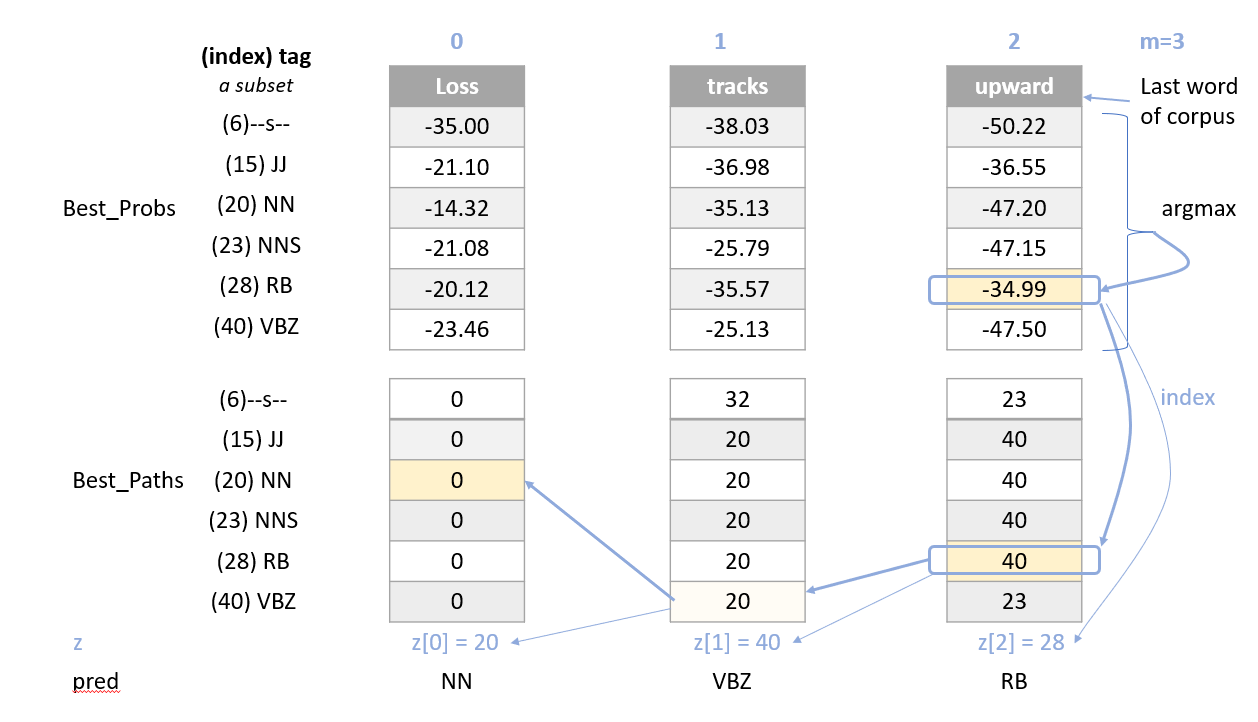

In [59]:
def viterbi_backward(best_probs, best_paths, corpus, states):
    # Get the number of words in the corpus
    # which is also the number of columns in best_probs, best_paths
    m = best_paths.shape[1]

    # Initialize array z, same length as the corpus
    z = [None] * m

    # Get the number of unique POS tags
    num_tags = best_probs.shape[0]

    # Initialize the best probability for the last word
    best_prob_for_last_word = float('-inf')

    # Initialize pred array, same length as corpus
    pred = [None] * m
    ## Step 1 ##

    # Go through each POS tag for the last word (last column of best_probs)
    # in order to find the row (POS tag integer ID)
    # with highest probability for the last word
    for k in range(num_tags): # complete this line

        # If the probability of POS tag at row k
        # is better than the previosly best probability for the last word:
        if best_probs[k,-1]>best_prob_for_last_word: # complete this line

            # Store the new best probability for the last word
            best_prob_for_last_word = best_probs[k,-1]

            # Store the unique integer ID of the POS tag
            # which is also the row number in best_probs
            z[m - 1]=k

    # Convert the last word's predicted POS tag
    # from its unique integer ID into the string representation
    # using the 'states' dictionary
    # store this in the 'pred' array for the last word
    pred[m - 1] = states[k]

    ## Step 2 ##
    # Find the best POS tags by walking backward through the best_paths
    # From the last word in the corpus to the 0th word in the corpus
    for i in range(len(corpus)-1, -1, -1): # complete this line

        # Retrieve the unique integer ID of
        # the POS tag for the word at position 'i' in the corpus
        pos_tag_for_word_i = best_paths[np.argmax(best_probs[:,i]),i]

        # In best_paths, go to the row representing the POS tag of word i
        # and the column representing the word's position in the corpus
        # to retrieve the predicted POS for the word at position i-1 in the corpus
        z[i - 1] = best_paths[pos_tag_for_word_i,i]

        # Get the previous word's POS tag in string form
        # Use the 'states' dictionary,
        # where the key is the unique integer ID of the POS tag,
        # and the value is the string representation of that POS tag
        pred[i - 1] = states[pos_tag_for_word_i]

    return pred

In [60]:
pred = viterbi_backward(best_probs, best_paths, prep, states)
m=len(pred)
print('The prediction for pred[-7:m-1] is: \n', prep[-7:m-1], "\n", pred[-7:m-1], "\n")
print('The prediction for pred[0:8] is: \n', pred[0:7], "\n", prep[0:7])

The prediction for pred[-7:m-1] is: 
 ['see', 'them', 'here', 'with', 'us', '.'] 
 ['VB', 'PRP', 'RB', 'IN', 'PRP', '.'] 

The prediction for pred[0:8] is: 
 ['DT', 'NN', 'POS', 'NN', 'MD', 'VB', 'VBN'] 
 ['The', 'economy', "'s", 'temperature', 'will', 'be', 'taken']


In [62]:
print('The third word is:', prep[4])
print('Your prediction is:', pred[4])
print('Your corresponding label y is: ', y[4])

The third word is: will
Your prediction is: MD
Your corresponding label y is:  will	MD



In [63]:
def compute_accuracy(pred, y):
    num_correct = 0
    total = 0

    # Zip together the prediction and the labels
    for prediction, y in zip(pred, y):
        # Split the label into the word and the POS tag
        word_tag_tuple = y.split()

        # Check that there is actually a word and a tag
        # no more and no less than 2 items
        if len(word_tag_tuple)!=2: # complete this line
            continue
        # store the word and tag separately
        word, tag = word_tag_tuple
        # Check if the POS tag label matches the prediction
        if prediction == tag: # complete this line
            # count the number of times that the prediction
            # and label match
            num_correct += 1

        # keep track of the total number of examples (that have valid labels)
        total += 1

    return (num_correct/total)

In [64]:
print(f"Accuracy of the Viterbi algorithm is {compute_accuracy(pred, y):.4f}")

Accuracy of the Viterbi algorithm is 0.9528


#**Prediccion de Texto**
la siguiente palabra dependiendo de las anteriores

In [65]:
!pip install trax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 637.9/637.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 76.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 31.4 MB/s eta 0:00:00
  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      

In [66]:
import os
import trax
import trax.fastmath.numpy as np
import pickle
import numpy
import random as rnd
from trax import fastmath
from trax import layers as tl

# set random seed
rnd.seed(32)

###Parte 1: Datos
Se tiene varios archivos de libros en ingles de Shakespeare esa es la informacion que se utilizara para predecir

In [69]:
dirname = '/content/drive/MyDrive/NLP/data/'
lines = [] # storing all the lines in a variable.
for filename in os.listdir(dirname):
    with open(os.path.join(dirname, filename)) as files:
        for line in files:
            # remove leading and trailing whitespace
            pure_line = line.strip()

            # if pure_line is not the empty string,
            if pure_line:
                # append it to the list
                lines.append(pure_line)

IsADirectoryError: ignored

In [ ]:
n_lines = len(lines)
print(f"Number of lines: {n_lines}")
print(f"Sample line at position 0 {lines[0]}")
print(f"Sample line at position 999 {lines[999]}")

Observe que las letras son mayúsculas y minúsculas. Para reducir la complejidad de la tarea, convertiremos todos los caracteres a minúsculas. De esta forma, el modelo solo necesita predecir la probabilidad de que una letra sea 'a' y no decidir entre 'A' mayúscula y 'a' minúscula.

In [ ]:
# go through each line
for i, line in enumerate(lines):
    # convert to all lowercase
    lines[i] = line.lower()

print(f"Number of lines: {n_lines}")
print(f"Sample line at position 0 {lines[0]}")
print(f"Sample line at position 999 {lines[999]}")

In [ ]:
eval_lines = lines[-1000:] # Create a holdout validation set
lines = lines[:-1000] # Leave the rest for training

print(f"Number of lines for training: {len(lines)}")
print(f"Number of lines for validation: {len(eval_lines)}")

####Convertir una línea a tensor

Ahora que tiene su lista de líneas, convertirá cada carácter de esa lista en un número. Puedes usar la función `ord` de Python para hacerlo.

Dada una cadena que representa un carácter Unicode, la función `ord` devuelve un número entero que representa el punto de código Unicode de ese carácter.

In [ ]:
# View the unique unicode integer associated with each character
print(f"ord('a'): {ord('a')}")
print(f"ord('b'): {ord('b')}")
print(f"ord('c'): {ord('c')}")
print(f"ord(' '): {ord(' ')}")
print(f"ord('x'): {ord('x')}")
print(f"ord('y'): {ord('y')}")
print(f"ord('z'): {ord('z')}")
print(f"ord('1'): {ord('1')}")
print(f"ord('2'): {ord('2')}")
print(f"ord('3'): {ord('3')}")

In [ ]:
def line_to_tensor(line, EOS_int=1):
    # Initialize the tensor as an empty list
    tensor = []
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    # for each character:
    for c in line:

        # convert to unicode int
        c_int = ord(c)

        # append the unicode integer to the tensor list
        tensor.append(c_int)

    # include the end-of-sentence integer
    tensor.append(EOS_int)
    ### END CODE HERE ###

    return tensor

In [ ]:
line_to_tensor('abc xyz')

####Generador de lotes

La mayor parte del tiempo en el procesamiento del lenguaje natural y la IA en general, usamos lotes cuando entrenamos nuestros conjuntos de datos. Aquí, construirá un generador de datos que toma un texto y devuelve un lote de líneas de texto (las líneas son oraciones).
- El generador convierte las líneas de texto (oraciones) en matrices numpy de números enteros rellenados con ceros para que todas las matrices tengan la misma longitud, que es la longitud de la oración más larga en todo el conjunto de datos.

Una vez que crea el generador, puede iterarlo de esta manera:

```
next(data_generator)
```

Este generador devuelve los datos en un formato que podría usar directamente en su modelo al calcular la alimentación hacia adelante de su algoritmo. Este iterador devuelve un lote de líneas y por máscara de token. El lote es una tupla de tres partes: entradas, objetivos, máscara. Las entradas y los objetivos son idénticos. La segunda columna se utilizará para evaluar sus predicciones. La máscara es 1 para tokens sin relleno.

In [ ]:
def data_generator(batch_size, max_length, data_lines, line_to_tensor=line_to_tensor, shuffle=True):
    # initialize the index that points to the current position in the lines index array
    index = 0

    # initialize the list that will contain the current batch
    cur_batch = []

    # count the number of lines in data_lines
    num_lines = len(data_lines)

    # create an array with the indexes of data_lines that can be shuffled
    lines_index = [*range(num_lines)]

    # shuffle line indexes if shuffle is set to True
    if shuffle:
        rnd.shuffle(lines_index)

    while True:

        # if the index is greater or equal than to the number of lines in data_lines
        if index >= num_lines:
            # then reset the index to 0
            index = 0
            # shuffle line indexes if shuffle is set to True
            if shuffle:
                rnd.shuffle(lines_index)

        # get a line at the `lines_index[index]` position in data_lines
        line = data_lines[lines_index[index]]

        # if the length of the line is less than max_length
        if len(line) < max_length:
            # append the line to the current batch
            cur_batch.append(line)

        # increment the index by one
        index += 1

        # if the current batch is now equal to the desired batch size
        if len(cur_batch) == batch_size:

            batch = []
            mask = []

            # go through each line (li) in cur_batch
            for li in cur_batch:
                # convert the line (li) to a tensor of integers
                tensor = line_to_tensor(li)

                # Create a list of zeros to represent the padding
                # so that the tensor plus padding will have length `max_length`
                pad = [0] * (max_length - len(tensor))

                # combine the tensor plus pad
                tensor_pad = tensor + pad

                # append the padded tensor to the batch
                batch.append(tensor_pad)

                # A mask for  tensor_pad is 1 wherever tensor_pad is not
                # 0 and 0 wherever tensor_pad is 0, i.e. if tensor_pad is
                # [1, 2, 3, 0, 0, 0] then example_mask should be
                # [1, 1, 1, 0, 0, 0]
                # Hint: Use a list comprehension for this
                example_mask = [0 if t == 0 else 1 for t in tensor_pad]
                mask.append(example_mask)

            # convert the batch (data type list) to a trax's numpy array
            batch_np_arr = np.array(batch)
            mask_np_arr = np.array(mask)

            # Yield two copies of the batch and mask.
            yield batch_np_arr, batch_np_arr, mask_np_arr

            # reset the current batch to an empty list
            cur_batch = []

In [ ]:
tmp_lines = ['12345678901', #length 11
             '123456789', # length 9
             '234567890', # length 9
             '345678901'] # length 9

# Get a batch size of 2, max length 10
tmp_data_gen = data_generator(batch_size=2,
                              max_length=10,
                              data_lines=tmp_lines,
                              shuffle=False)

# get one batch
tmp_batch = next(tmp_data_gen)

# view the batch
tmp_batch

In [ ]:
import itertools

infinite_data_generator = itertools.cycle(
    data_generator(batch_size=2, max_length=10, data_lines=tmp_lines))

In [ ]:
ten_lines = [next(infinite_data_generator) for _ in range(10)]
print(len(ten_lines))

### Parte 2: Definición del modelo GRU

Ahora que tiene los tensores de entrada y salida, continuará e inicializará su modelo. Implementará el modelo de unidad recurrente cerrada `GRULM`. Para implementar este modelo, utilizará el paquete `trax` de Google. En lugar de hacer que implemente el `GRU` desde cero, le daremos los métodos necesarios desde un paquete incorporado. Puede utilizar los siguientes paquetes al construir el modelo:


- `tl.Serial`: Combinador que aplica capas en serie (por composición de funciones). [docs](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.combinators.Serial) / [código fuente](https://github.com/google/trax/blob/1372b903bb66b0daccee19fd0b1fdf44f659330b/trax/layers/combinators.py#L26)
     - Puede pasar las capas como argumentos a `Serial`, separados por comas.
     - Por ejemplo: `tl.Serial(tl.Embeddings(...), tl.Mean(...), tl.Dense(...), tl.LogSoftmax(...))`

___

- `tl.ShiftRight`: Permite que el modelo vaya a la derecha en el avance. [docs](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.attention.ShiftRight) / [código fuente](https://github.com/google/trax/blob/1372b903bb66b0daccee19fd0b1fdf44f659330b/trax/layers/attention.py#L297)
     - Capa `ShiftRight(n_shifts=1, mode='train')` para desplazar el tensor a la derecha n_shift veces
     - Aquí en el ejercicio solo necesita especificar el modo y no preocuparse por n_shifts

___

- `tl.Embedding`: Inicializa la incrustación. En este caso es el tamaño del vocabulario por la dimensión del modelo. [docs](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Embedding) / [código fuente](https://github.com/google/trax/blob/1372b903bb66b0daccee19fd0b1fdf44f659330b/trax/layers/core.py#L113)
     - `tl.Embedding(vocab_size, d_feature)`.
     - `vocab_size` es el número de palabras únicas en el vocabulario dado.
     - `d_feature` es el número de elementos en la palabra incrustada (algunas opciones para el tamaño de una palabra incrustada van desde 150 a 300, por ejemplo).
___

- `tl.GRU`: capa GRU `Trax`. [docs](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.rnn.GRU) / [código fuente](https://github.com/google/trax/blob/1372b903bb66b0daccee19fd0b1fdf44f659330b/trax/layers/rnn.py#L143)
     - `GRU(n_units)` Construye un GRU tradicional de n_celdas con transformaciones internas densas.
     - Papel `GRU`: https://arxiv.org/abs/1412.3555
___

- `tl.Dense`: Una capa densa. [docs](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Dense) / [código fuente](https://github.com/google/trax/blob/1372b903bb66b0daccee19fd0b1fdf44f659330b/trax/layers/core.py#L28)
     - `tl.Dense(n_units)`: El parámetro `n_units` es el número de unidades elegidas para esta capa densa.
___

- `tl.LogSoftmax`: Registro de las probabilidades de salida. [docs](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.LogSoftmax) / [código fuente](https://github.com/google/trax/blob/1372b903bb66b0daccee19fd0b1fdf44f659330b/trax/layers/core.py#L242)
     - Aquí, no necesita configurar ningún parámetro para `LogSoftMax()`.

In [ ]:
def GRULM(vocab_size=256, d_model=512, n_layers=2, mode='train'):
    model = tl.Serial(
      tl.ShiftRight(mode=mode), # Stack the ShiftRight layer
      tl.Embedding(vocab_size=vocab_size, d_feature=d_model), # Stack the embedding layer
      [tl.GRU(n_units=d_model) for _ in range(n_layers)], # Stack GRU layers of d_model units keeping n_layer parameter in mind (use list comprehension syntax)
      tl.Dense(n_units=vocab_size), # Dense layer
      tl.LogSoftmax() # Log Softmax
    )
    return model

In [ ]:
model = GRULM()
print(model)

### Parte 3: Entrenamiento

Ahora vas a entrenar tu modelo. Como de costumbre, debe definir la función de costo, el optimizador, y decidir si lo entrenará en un `gpu` o `cpu`. También tienes que introducir un modelo construido. Antes de entrar en el entrenamiento, volvemos a presentar las abstracciones `TrainTask` y `EvalTask` de la tarea de la semana pasada.

Para entrenar un modelo en una tarea, Trax define una abstracción `trax.supervised.training.TrainTask` que empaqueta los datos de entrenamiento, la pérdida y el optimizador (entre otras cosas) en un objeto.

De manera similar, para evaluar un modelo, Trax define una abstracción `trax.supervised.training.EvalTask` que empaqueta los datos y las métricas de evaluación (entre otras cosas) en otro objeto.

La pieza final que une las cosas es la abstracción `trax.supervised.training.Loop`, que es una forma muy simple y flexible de unir todo y entrenar el modelo, mientras lo evalúa y guarda los puntos de control.
Usar `training.Loop` te ahorrará una gran cantidad de código en comparación con escribir siempre el bucle de entrenamiento a mano, como lo hiciste en los cursos 1 y 2. Más importante aún, es menos probable que tengas un error en ese código que arruinaría tu entrenamiento.

In [ ]:
batch_size = 32
max_length = 64
def n_used_lines(lines, max_length):
    n_lines = 0
    for l in lines:
        if len(l) <= max_length:
            n_lines += 1
    return n_lines

num_used_lines = n_used_lines(lines, 32)
print('Number of used lines from the dataset:', num_used_lines)
print('Batch size (a power of 2):', int(batch_size))
steps_per_epoch = int(num_used_lines/batch_size)
print('Number of steps to cover one epoch:', steps_per_epoch)

In [ ]:
from trax.supervised import training

def train_model(model, data_generator, batch_size=32, max_length=64, lines=lines, eval_lines=eval_lines, n_steps=1000, output_dir='model/'):
    bare_train_generator = data_generator(batch_size, max_length, data_lines=lines)
    infinite_train_generator = itertools.cycle(bare_train_generator)

    bare_eval_generator = data_generator(batch_size, max_length, data_lines=eval_lines)
    infinite_eval_generator = itertools.cycle(bare_eval_generator)

    train_task = training.TrainTask(
        labeled_data=infinite_train_generator, # Use infinite train data generator
        loss_layer=tl.CrossEntropyLoss(),   # Don't forget to instantiate this object
        optimizer=trax.optimizers.Adam(0.0005)     # Don't forget to add the learning rate parameter
    )

    eval_task = training.EvalTask(
        labeled_data=infinite_eval_generator,    # Use infinite eval data generator
        metrics=[tl.CrossEntropyLoss(), tl.Accuracy()], # Don't forget to instantiate these objects
        n_eval_batches=3      # For better evaluation accuracy in reasonable time
    )

    training_loop = training.Loop(model,
                                  train_task,
                                  eval_tasks=eval_task,
                                  output_dir=output_dir)

    training_loop.run(n_steps=n_steps)

    # We return this because it contains a handle to the model, which has the weights etc.
    return training_loop

In [ ]:
training_loop = train_model(GRULM(), data_generator)

### 4.1 Evaluar usando las redes profundas

Ahora que ha aprendido a entrenar un modelo, aprenderá a evaluarlo. Para evaluar los modelos de lenguaje, generalmente usamos la perplejidad, que es una medida de qué tan bien un modelo de probabilidad predice una muestra. Tenga en cuenta que la perplejidad se define como:

$$P(W) = \sqrt[N]{\prod_{i=1}^{N} \frac{1}{P(w_i| w_1,...,w_{n-1})}}$$

Como un truco de implementación, generalmente tomaría el registro de esa fórmula (para permitirnos usar las probabilidades de registro que obtenemos como resultado de nuestro 'RNN', convertir exponentes en productos y productos en sumas, lo que hace que los cálculos sean menos complicados y computacionalmente más eficientes). También debe tener cuidado con el relleno, ya que no desea incluir el relleno al calcular la perplejidad (porque no queremos tener una medida de perplejidad artificialmente buena).

$$log P(W) = {log\big(\sqrt[N]{\prod_{i=1}^{N} \frac{1}{P(w_i| w_1,...,w_{n-1})}}\big)}$$

$$ = {log\big({\prod_{i=1}^{N} \frac{1}{P(w_i| w_1,...,w_{n-1})}}\big)^{\frac{1}{N}}}$$

$$ = {log\big({\prod_{i=1}^{N}{P(w_i| w_1,...,w_{n-1})}}\big)^{-\frac{1}{N}}} $$
$$ = -\frac{1}{N}{log\big({\prod_{i=1}^{N}{P(w_i| w_1,...,w_{n-1})}}\big)} $$
$$ = -\frac{1}{N}{\big({\sum_{i=1}^{N}{logP(w_i| w_1,...,w_{n-1})}}\big)} $$



In [ ]:
def test_model(preds, target):
    total_log_ppx = np.sum(preds * tl.one_hot(target, preds.shape[-1]),axis= -1) # HINT: tl.one_hot() should replace one of the Nones

    non_pad = 1.0 - np.equal(target, 0)          # You should check if the target equals 0
    ppx = total_log_ppx * non_pad                       # Get rid of the padding

    log_ppx = np.sum(ppx) / np.sum(non_pad)

    return -log_ppx

In [ ]:
model = GRULM()
model.init_from_file('/content/model/model.pkl.gz')
batch = next(data_generator(batch_size, max_length, lines, shuffle=False))
preds = model(batch[0])
log_ppx = test_model(preds, batch[1])
print('The log perplexity and perplexity of your model are respectively', log_ppx, np.exp(log_ppx))

### Parte 5: Generando el lenguaje con tu propio modelo

Ahora usaremos su propio modelo de lenguaje para generar nuevas oraciones para las que necesitamos hacer sorteos de una distribución de Gumble.

La función de densidad de probabilidad de Gumbel (PDF) se define como:

$$ f(z) = {1\over{\beta}}e^{(-z+e^{(-z)})} $$

donde: $$ z = {(x - \mu)\over{\beta}}$$

El valor máximo, que es el que elegimos como predicción en el último paso de una Red Neuronal Recursiva `RNN` que estamos usando para la generación de texto, en una muestra de una variable aleatoria siguiendo una distribución exponencial se aproxima a la distribución de Gumbel cuando la muestra aumenta asintóticamente. Por esa razón, la distribución de Gumbel se usa para tomar muestras de una distribución categórica.

In [ ]:
def gumbel_sample(log_probs, temperature=1.0):
    """Gumbel sampling from a categorical distribution."""
    u = numpy.random.uniform(low=1e-6, high=1.0 - 1e-6, size=log_probs.shape)
    g = -np.log(-np.log(u))
    return np.argmax(log_probs + g * temperature, axis=-1)

def predict(num_chars, prefix):
    inp = [ord(c) for c in prefix]
    result = [c for c in prefix]
    max_len = len(prefix) + num_chars
    for _ in range(num_chars):
        cur_inp = np.array(inp + [0] * (max_len - len(inp)))
        outp = model(cur_inp[None, :])  # Add batch dim.
        next_char = gumbel_sample(outp[0, len(inp)])
        inp += [int(next_char)]

        if inp[-1] == 1:
            break  # EOS
        result.append(chr(int(next_char)))

    return "".join(result)

print(predict(1, ""))

In [ ]:
print(predict(32, ""))
print(predict(32, ""))
print(predict(32, ""))

In [ ]:
print(predict(10, "I will, my lord"))

#**Named Entity Recognition (NER):**
reconocimiento de entidad nombrada (NER). NER es una subtarea de extracción de información que localiza y clasifica entidades nombradas en un texto. Las entidades nombradas pueden ser organizaciones, personas, ubicaciones, tiempos, etc.

In [ ]:
!pip install trax

In [ ]:
import trax
from trax import layers as tl
import os
import numpy as np
import pandas as pd
import random as rnd

##Parte 1: Explorando los datos

Usaremos un conjunto de datos de Kaggle, que procesaremos previamente para usted. Los datos originales consisten en cuatro columnas, el número de oración, la palabra, la parte del discurso de la palabra y las etiquetas. Algunas etiquetas que podría esperar ver son:

* geo: entidad geográfica
* org: organización
* por persona
* gpe: entidad geopolítica
* tim: indicador de tiempo
* arte: artefacto
* víspera: evento
* nat: fenómeno natural
* O: palabra de relleno

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/NLP/ner_dataset.csv", encoding = "ISO-8859-1")
train_sents = open('/content/drive/MyDrive/NLP/data/small/train/sentences.txt', 'r').readline()
train_labels = open('/content/drive/MyDrive/NLP/data/small/train/labels.txt', 'r').readline()
print('SENTENCE:', train_sents)
print('SENTENCE LABEL:', train_labels)
print('ORIGINAL DATA:\n', data.head(5))
del(data, train_sents, train_labels)

####Funciones utiles:

In [ ]:
def get_vocab(vocab_path, tags_path):
    vocab = {}
    with open(vocab_path) as f:
        for i, l in enumerate(f.read().splitlines()):
            vocab[l] = i  # to avoid the 0
        # loading tags (we require this to map tags to their indices)
    vocab['<PAD>'] = len(vocab) # 35180
    tag_map = {}
    with open(tags_path) as f:
        for i, t in enumerate(f.read().splitlines()):
            tag_map[t] = i

    return vocab, tag_map

def get_params(vocab, tag_map, sentences_file, labels_file):
    sentences = []
    labels = []

    with open(sentences_file) as f:
        for sentence in f.read().splitlines():
            # replace each token by its index if it is in vocab
            # else use index of UNK_WORD
            s = [vocab[token] if token in vocab
                 else vocab['UNK']
                 for token in sentence.split(' ')]
            sentences.append(s)

    with open(labels_file) as f:
        for sentence in f.read().splitlines():
            # replace each label by its index
            l = [tag_map[label] for label in sentence.split(' ')] # I added plus 1 here
            labels.append(l)
    return sentences, labels, len(sentences)

In [ ]:
vocab, tag_map = get_vocab('/content/drive/MyDrive/NLP/data/large/words.txt', '/content/drive/MyDrive/NLP/data/large/tags.txt')
t_sentences, t_labels, t_size = get_params(vocab, tag_map, '/content/drive/MyDrive/NLP/data/large/train/sentences.txt', '/content/drive/MyDrive/NLP/data/large/train/labels.txt')
v_sentences, v_labels, v_size = get_params(vocab, tag_map, '/content/drive/MyDrive/NLP/data/large/val/sentences.txt', '/content/drive/MyDrive/NLP/data/large/val/labels.txt')
test_sentences, test_labels, test_size = get_params(vocab, tag_map, '/content/drive/MyDrive/NLP/data/large/test/sentences.txt', '/content/drive/MyDrive/NLP/data/large/test/labels.txt')

`vocab` es un diccionario que traduce una cadena de palabras a un número único. Dada una oración, puede representarla como una matriz de números que se traducen con este diccionario. El diccionario contiene un token `<PAD>`.

Al entrenar un LSTM usando lotes, todas sus oraciones de entrada deben tener el mismo tamaño. Para lograr esto, establece la longitud de sus oraciones en un número determinado y agrega el token genérico `<PAD>` para llenar todos los espacios vacíos.

In [ ]:
print('vocab["the"]:', vocab["the"])
# Pad token
print('padded token:', vocab['<PAD>'])

El tag_map corresponde a una de las posibles etiquetas que puede tener una palabra. Ejecute la celda a continuación para ver las posibles clases que estará pronosticando. Las preposiciones en las etiquetas significan:
* I: El token está dentro de una entidad.
* B: Token inicia una entidad.

In [ ]:
print(tag_map)

### 1.2 Generador de datos

En Python, un generador es una función que se comporta como un iterador. Devolverá el siguiente artículo. Aquí hay un [enlace] (https://wiki.python.org/moin/Generators) para revisar los generadores de Python.

En muchas aplicaciones de IA es muy útil tener un generador de datos. Ahora implementará un generador de datos para nuestra aplicación NER.

In [ ]:
def data_generator(batch_size, x, y, pad, shuffle=False, verbose=False):
    # count the number of lines in data_lines
    num_lines = len(x)

    # create an array with the indexes of data_lines that can be shuffled
    lines_index = [*range(num_lines)]

    # shuffle the indexes if shuffle is set to True
    if shuffle:
        rnd.shuffle(lines_index)

    index = 0 # tracks current location in x, y
    while True:
        buffer_x = [0] * batch_size # Temporal array to store the raw x data for this batch
        buffer_y = [0] * batch_size # Temporal array to store the raw y data for this batch

        # Copy into the temporal buffers the sentences in x[index : index + batch_size]
        # along with their corresponding labels y[index : index + batch_size]
        # Find maximum length of sentences in x[index : index + batch_size] for this batch.
        # Reset the index if we reach the end of the data set, and shuffle the indexes if needed.
        max_len = 0
        for i in range(batch_size):
             # if the index is greater than or equal to the number of lines in x
            if index >= num_lines:
                # then reset the index to 0
                index = 0
                # re-shuffle the indexes if shuffle is set to True
                if shuffle:
                    rnd.shuffle(lines_index)

            # The current position is obtained using `lines_index[index]`
            # Store the x value at the current position into the buffer_x
            buffer_x[i] = x[lines_index[index]]

            # Store the y value at the current position into the buffer_y
            buffer_y[i] = y[lines_index[index]]

            lenx = len(x[lines_index[index]])    #length of current x[]
            if lenx > max_len:
                max_len = lenx                   #max_len tracks longest x[]

            # increment index by one
            index += 1


        # create X,Y, NumPy arrays of size (batch_size, max_len) 'full' of pad value
        X = np.full((batch_size, max_len), pad)
        Y = np.full((batch_size, max_len), pad)

        # copy values from lists to NumPy arrays. Use the buffered values
        for i in range(batch_size):
            # get the example (sentence as a tensor)
            # in `buffer_x` at the `i` index
            x_i = buffer_x[i]

            # similarly, get the example's labels
            # in `buffer_y` at the `i` index
            y_i = buffer_y[i]

            # Walk through each word in x_i
            for j in range(len(x_i)):
                # store the word in x_i at position j into X
                X[i, j] = x_i[j]

                # store the label in y_i at position j into Y
                Y[i, j] = y_i[j]

        if verbose: print("index=", index)
        yield((X,Y))

In [ ]:
batch_size = 5
mini_sentences = t_sentences[0: 8]
mini_labels = t_labels[0: 8]
dg = data_generator(batch_size, mini_sentences, mini_labels, vocab["<PAD>"], shuffle=False, verbose=True)
X1, Y1 = next(dg)
X2, Y2 = next(dg)
print(Y1.shape, X1.shape, Y2.shape, X2.shape)
print(X1[0][:], "\n", Y1[0][:])

## Parte 2: Construcción del modelo

Ahora implementará el modelo. Usarás TensorFlow de Google.

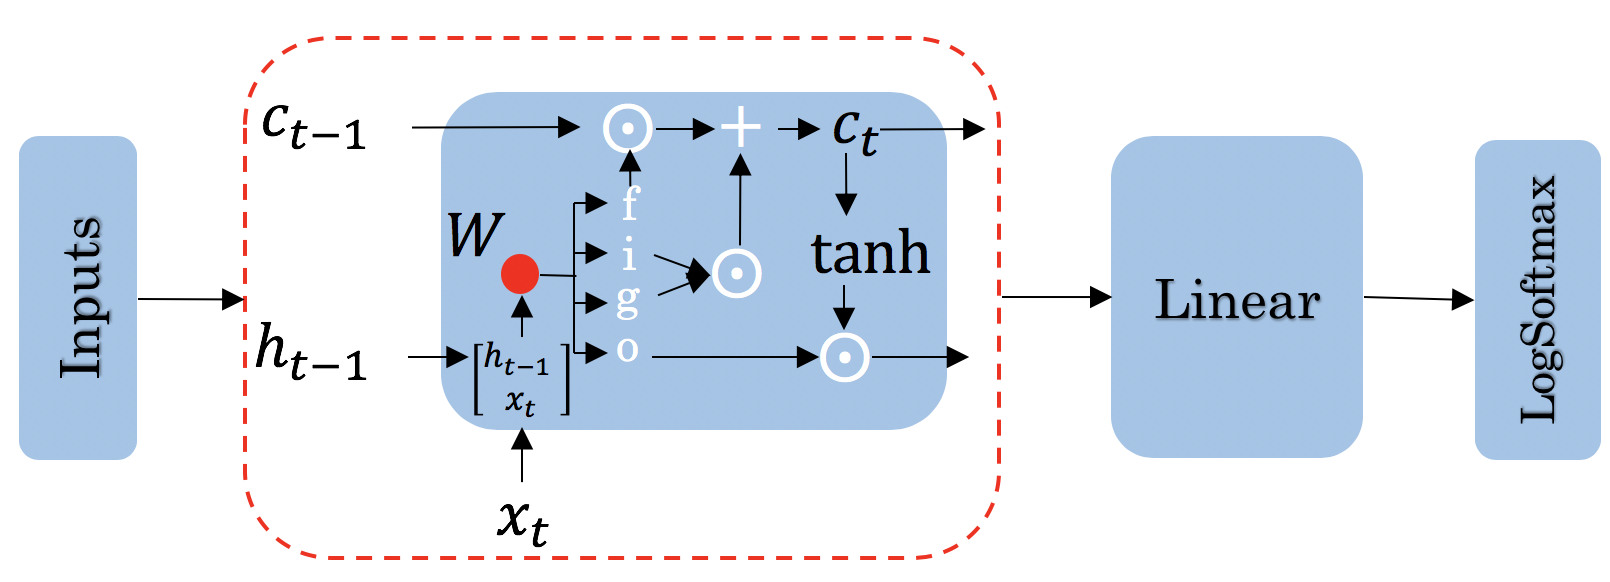

In [ ]:
def NER(vocab_size=35181, d_model=50, tags=tag_map):
    model = tl.Serial(
      tl.Embedding(vocab_size, d_model), # Embedding layer
      tl.LSTM(d_model), # LSTM layer
      tl.Dense(len(tags)), # Dense layer with len(tags) units
      tl.LogSoftmax()  # LogSoftmax layer
      )
    return model

In [ ]:
model = NER()
# display your model
print(model)

## Parte 3: entrenar al modelo

Esta sección entrenará su modelo.

Antes de comenzar, debe crear los generadores de datos para los datos de capacitación y validación. Es importante que enmascare el relleno en los pesos perdidos de sus datos, lo que se puede hacer usando el argumento `id_to_mask` de `trax.supervised.inputs.add_loss_weights`.

In [ ]:
from trax.supervised import training

rnd.seed(33)

batch_size = 64

# Create training data, mask pad id=35180 for training.
train_generator = trax.data.inputs.add_loss_weights(
    data_generator(batch_size, t_sentences, t_labels, vocab['<PAD>'], True),
    id_to_mask=vocab['<PAD>'])

# Create validation data, mask pad id=35180 for training.
eval_generator = trax.data.inputs.add_loss_weights(
    data_generator(batch_size, v_sentences, v_labels, vocab['<PAD>'], True),
    id_to_mask=vocab['<PAD>'])

### 3.1 Entrenamiento del modelo

Ahora escribirá una función que tome su modelo y lo entrene.

Como ha visto en las tareas anteriores, primero creará [https://trax-ml.readthedocs.io/en/stable/trax.supervised.html#trax.supervised.training.traintask) y [evaltask] (https://trax-ml.readthedocs.io/Stable/stable/stable/supered.supered.supered.supered.supered.supered.supered.supered.supered.supered.supered.supered.supered.supered.supered.supered.supervised.supered.supered.supered.supered.supered.supered.supered.supered.supered.supered.supered.supered.supered.supered.supered.supered.supervised. .Training.evalTask) Uso de su generador de datos. Luego usará `training.Loop` para entrenar su modelo.

In [ ]:
def train_model(NER, train_generator, eval_generator, train_steps=1, output_dir='model_3'):
    train_task = training.TrainTask(
      train_generator, # A train data generator
      loss_layer = tl.CrossEntropyLoss(), # A cross-entropy loss function
      optimizer = trax.optimizers.Adam(0.01),  # The adam optimizer
    )

    eval_task = training.EvalTask(
      labeled_data = eval_generator, # A labeled data generator
      metrics = [tl.CrossEntropyLoss(), tl.Accuracy()], # Evaluate with cross-entropy loss and accuracy
      n_eval_batches = 10  # Number of batches to use on each evaluation
    )

    training_loop = training.Loop(
        NER, # A model to train
        train_task, # A train task
        eval_tasks = eval_task, # The evaluation task
        output_dir = output_dir) # The output directory

    # Train with train_steps
    training_loop.run(n_steps = train_steps)
    return training_loop

In [ ]:
train_steps = 100            # In coursera we can only train 100 steps
!rm -f 'model_3/model.pkl.gz'  # Remove old model.pkl if it exists

# Train the model
training_loop = train_model(NER(), train_generator, eval_generator, train_steps)

In [ ]:
model = NER()
model.init(trax.shapes.ShapeDtype((1, 1), dtype=np.int32))

# Load the pretrained model
model.init_from_file('model_3/model.pkl.gz', weights_only=True)

## Parte 4: Cálculo de Precisión

Ahora evaluará en el conjunto de prueba. Anteriormente, ha visto la precisión en el conjunto de entrenamiento y el conjunto de validación (anotado como eval). Ahora evaluará en su conjunto de prueba. Para obtener una buena evaluación, deberá crear una máscara para evitar contar las fichas de relleno al calcular la precisión.

In [ ]:
x, y = next(data_generator(len(test_sentences), test_sentences, test_labels, vocab['<PAD>']))
print("input shapes", x.shape, y.shape)

In [ ]:
tmp_pred = model(x)
print(type(tmp_pred))
print(f"tmp_pred has shape: {tmp_pred.shape}")

In [ ]:
def evaluate_prediction(pred, labels, pad):
## step 1 ##
    outputs = np.argmax(pred, axis=2)
    print("outputs shape:", outputs.shape)

## step 2 ##
    mask = labels != pad
    print("mask shape:", mask.shape, "mask[0][20:30]:", mask[0][20:30])
## step 3 ##
    accuracy = np.sum(outputs == labels) / float(np.sum(mask))
    return accuracy


In [ ]:
accuracy = evaluate_prediction(model(x), y, vocab['<PAD>'])
print("accuracy: ", accuracy)

## Parte 5: Probando con tu propia oración

In [ ]:
def predict(sentence, model, vocab, tag_map):
    s = [vocab[token] if token in vocab else vocab['UNK'] for token in sentence.split(' ')]
    batch_data = np.ones((1, len(s)))
    batch_data[0][:] = s
    sentence = np.array(batch_data).astype(int)
    output = model(sentence)
    outputs = np.argmax(output, axis=2)
    labels = list(tag_map.keys())
    pred = []
    for i in range(len(outputs[0])):
        idx = outputs[0][i]
        pred_label = labels[idx]
        pred.append(pred_label)
    return pred

In [ ]:
sentence = "Peter Navarro, the White House director of trade and manufacturing policy of U.S, said in an interview on Sunday morning that the White House was working to prepare for the possibility of a second wave of the coronavirus in the fall, though he said it wouldn’t necessarily come"
s = [vocab[token] if token in vocab else vocab['UNK'] for token in sentence.split(' ')]
predictions = predict(sentence, model, vocab, tag_map)
for x,y in zip(sentence.split(' '), predictions):
    if y != 'O':
        print(x,y)

#**Transformers:**
Mecanismos de atencion

##**Resumidor de transformadores:**
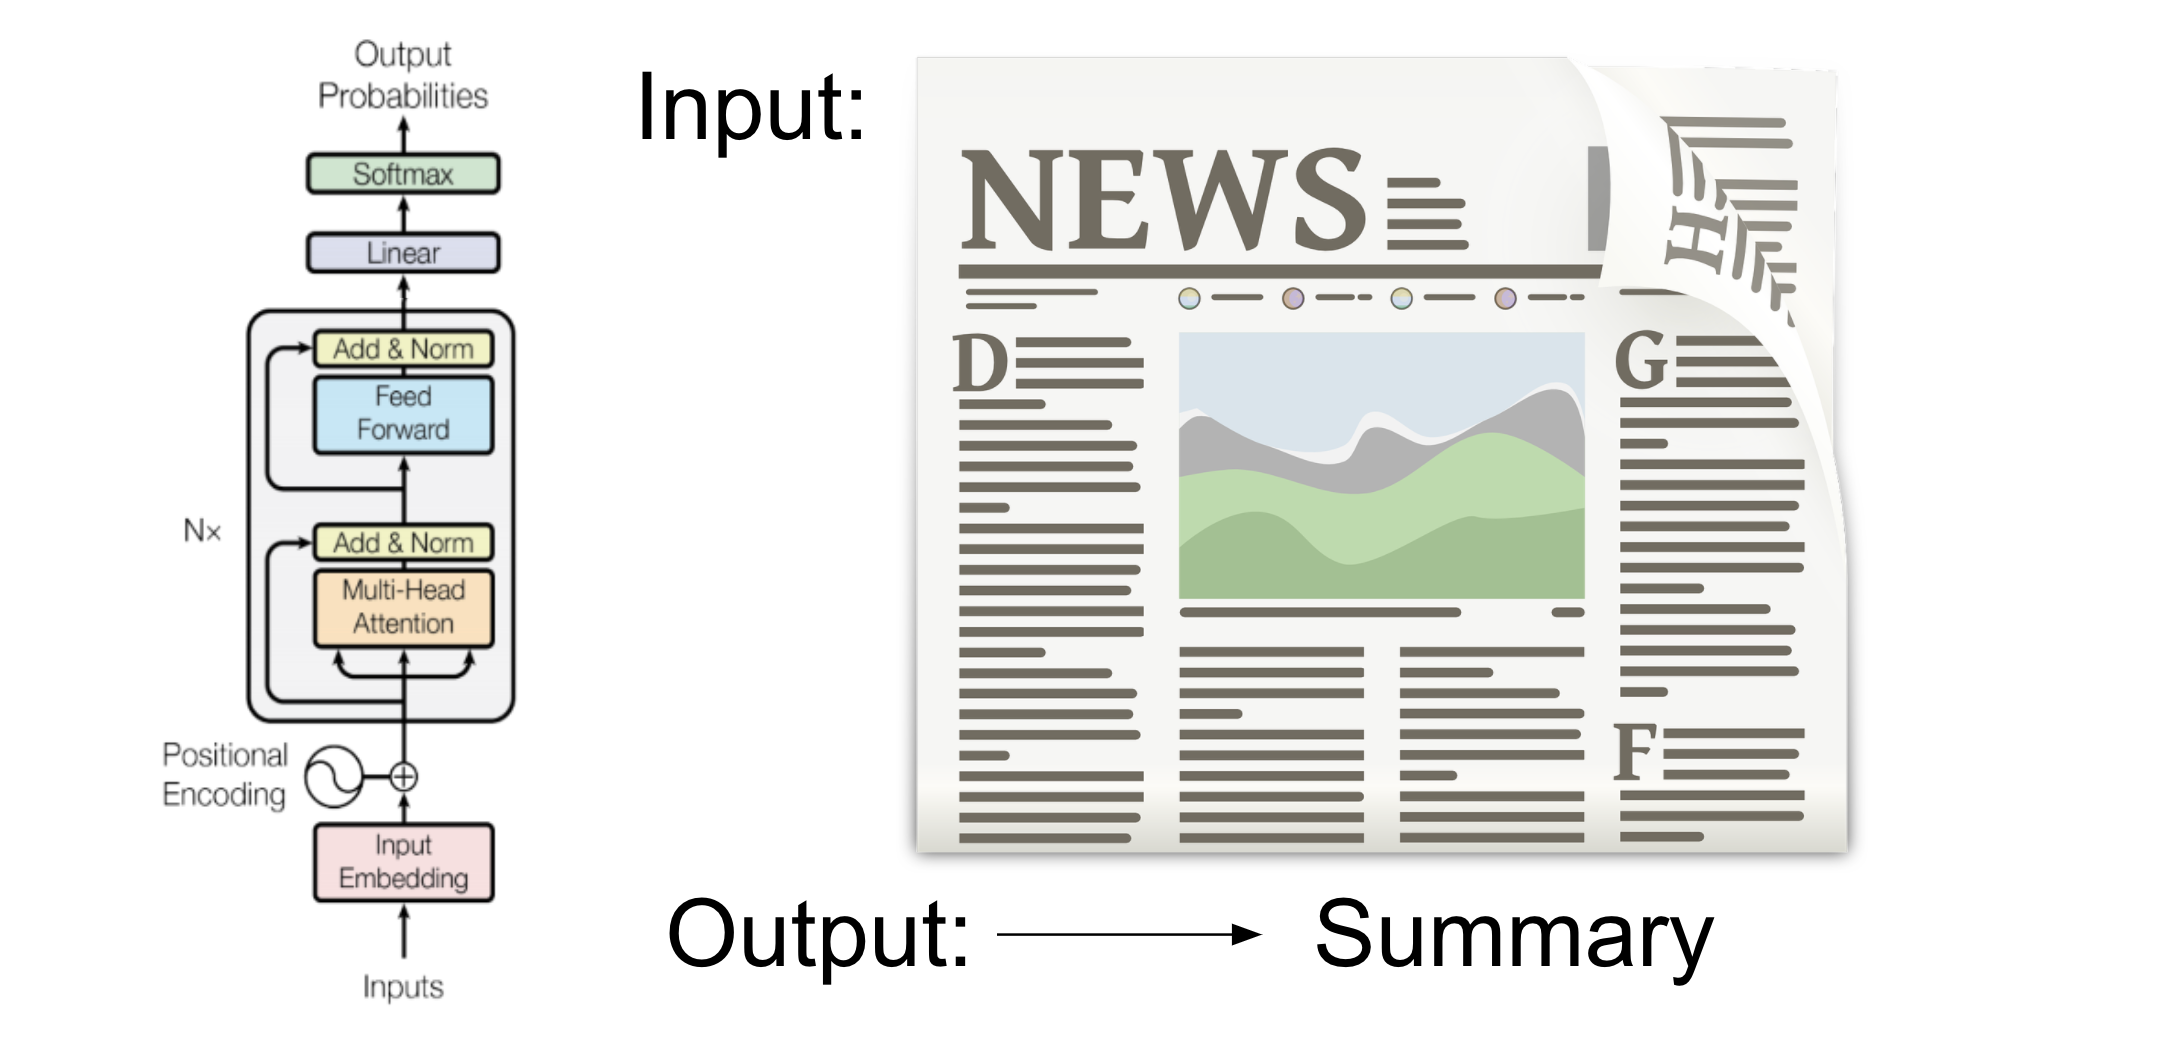

In [ ]:
!pip install trax

In [ ]:
import sys
import os

import numpy as np

import textwrap
wrapper = textwrap.TextWrapper(width=70)

import trax
from trax import layers as tl
from trax.fastmath import numpy as jnp

# to print the entire np array
np.set_printoptions(threshold=sys.maxsize)

### Parte 1: Importar la base de datos

In [ ]:
# Importing CNN/DailyMail articles dataset
train_stream_fn = trax.data.TFDS('cnn_dailymail',
                                 data_dir='data/',
                                 keys=('article', 'highlights'),
                                 train=True)

# This should be much faster as the data is downloaded already.
eval_stream_fn = trax.data.TFDS('cnn_dailymail',
                                data_dir='data/',
                                keys=('article', 'highlights'),
                                train=False)

#### 1.1 Funciones auxiliares de tokenización y destokenización

Al igual que en la tarea anterior, la celda de arriba se carga en el codificador por ti. Dado cualquier conjunto de datos, debe poder asignar palabras a sus índices e índices a sus palabras. Las entradas y salidas de sus modelos [Trax](https://github.com/google/trax) suelen ser tensores de números donde cada número corresponde a una palabra.

In [ ]:
def tokenize(input_str, EOS=1):
    """Input str to features dict, ready for inference"""

    # Use the trax.data.tokenize method. It takes streams and returns streams,
    # we get around it by making a 1-element stream with `iter`.
    inputs =  next(trax.data.tokenize(iter([input_str]),
                                      vocab_dir='/content/drive/MyDrive/NLP/vocab_dir/',
                                      vocab_file='summarize32k.subword.subwords'))

    # Mark the end of the sentence with EOS
    return list(inputs) + [EOS]

def detokenize(integers):
    """List of ints to str"""

    s = trax.data.detokenize(integers,
                             vocab_dir='/content/drive/MyDrive/NLP/vocab_dir/',
                             vocab_file='summarize32k.subword.subwords')

    return wrapper.fill(s)

#### 1.2 Preprocesamiento para modelos de lenguaje: ¡Concatenarlo!

Esta semana usará un modelo de lenguaje, Transformer Decoder, para resolver
un problema de entrada-salida. Como sabes, los modelos de lenguaje solo predicen el siguiente
palabra, no tienen noción de insumos. Para crear una sola entrada adecuada para
un modelo de lenguaje, concatenamos entradas con objetivos poniendo un separador
entre. También necesitamos crear una máscara, con 0 en las entradas y 1 en los objetivos, para que el modelo no sea penalizado por predecir mal el artículo y solo se centre en el resumen. Vea la función de preprocesamiento a continuación para saber cómo se hace esto.

In [ ]:
# Special tokens
SEP = 0 # Padding or separator token
EOS = 1 # End of sentence token

# Concatenate tokenized inputs and targets using 0 as separator.
def preprocess(stream):
    for (article, summary) in stream:
        joint = np.array(list(article) + [EOS, SEP] + list(summary) + [EOS])
        mask = [0] * (len(list(article)) + 2) + [1] * (len(list(summary)) + 1) # Accounting for EOS and SEP
        yield joint, joint, np.array(mask)

# You can combine a few data preprocessing steps into a pipeline like this.
input_pipeline = trax.data.Serial(
    # Tokenizes
    trax.data.Tokenize(vocab_dir='/content/drive/MyDrive/NLP/vocab_dir/',
                       vocab_file='summarize32k.subword.subwords'),
    # Uses function defined above
    preprocess,
    # Filters out examples longer than 2048
    trax.data.FilterByLength(2048)
)

# Apply preprocessing to data streams.
train_stream = input_pipeline(train_stream_fn())
eval_stream = input_pipeline(eval_stream_fn())

train_input, train_target, train_mask = next(train_stream)

assert sum((train_input - train_target)**2) == 0  # They are the same in Language Model (LM).

In [ ]:
print(f'Single example mask:\n\n {train_mask}')

In [ ]:
print(f'Single example:\n\n {detokenize(train_input)}')

## 1.3 Dosificación con depósito

Al igual que la semana anterior, usamos la creación de depósitos para crear lotes de datos.

In [ ]:
boundaries =  [128, 256,  512, 1024]
batch_sizes = [16,    8,    4,    2, 1]

# Create the streams.
train_batch_stream = trax.data.BucketByLength(
    boundaries, batch_sizes)(train_stream)

eval_batch_stream = trax.data.BucketByLength(
    boundaries, batch_sizes)(eval_stream)

In [ ]:
input_batch, _, mask_batch = next(train_batch_stream)

# Shape of the input_batch
input_batch.shape

In [ ]:
print(input_batch[0])

In [ ]:
print('Article:\n\n', detokenize(input_batch[0]))

### Parte 2: Resumen con transformador

Ahora que le hemos proporcionado el generador de datos y hemos manejado el preprocesamiento por usted, es hora de que construya su propio modelo. Le ahorramos algo de tiempo porque sabemos que ya ha preprocesado datos anteriormente en esta especialización, por lo que preferimos que dedique su tiempo a los siguientes pasos.

Implementará la atención desde cero y luego la usará en su modelo de transformador. En concreto, comprenderás cómo funciona la atención, cómo la utilizas para conectar el codificador y el decodificador.
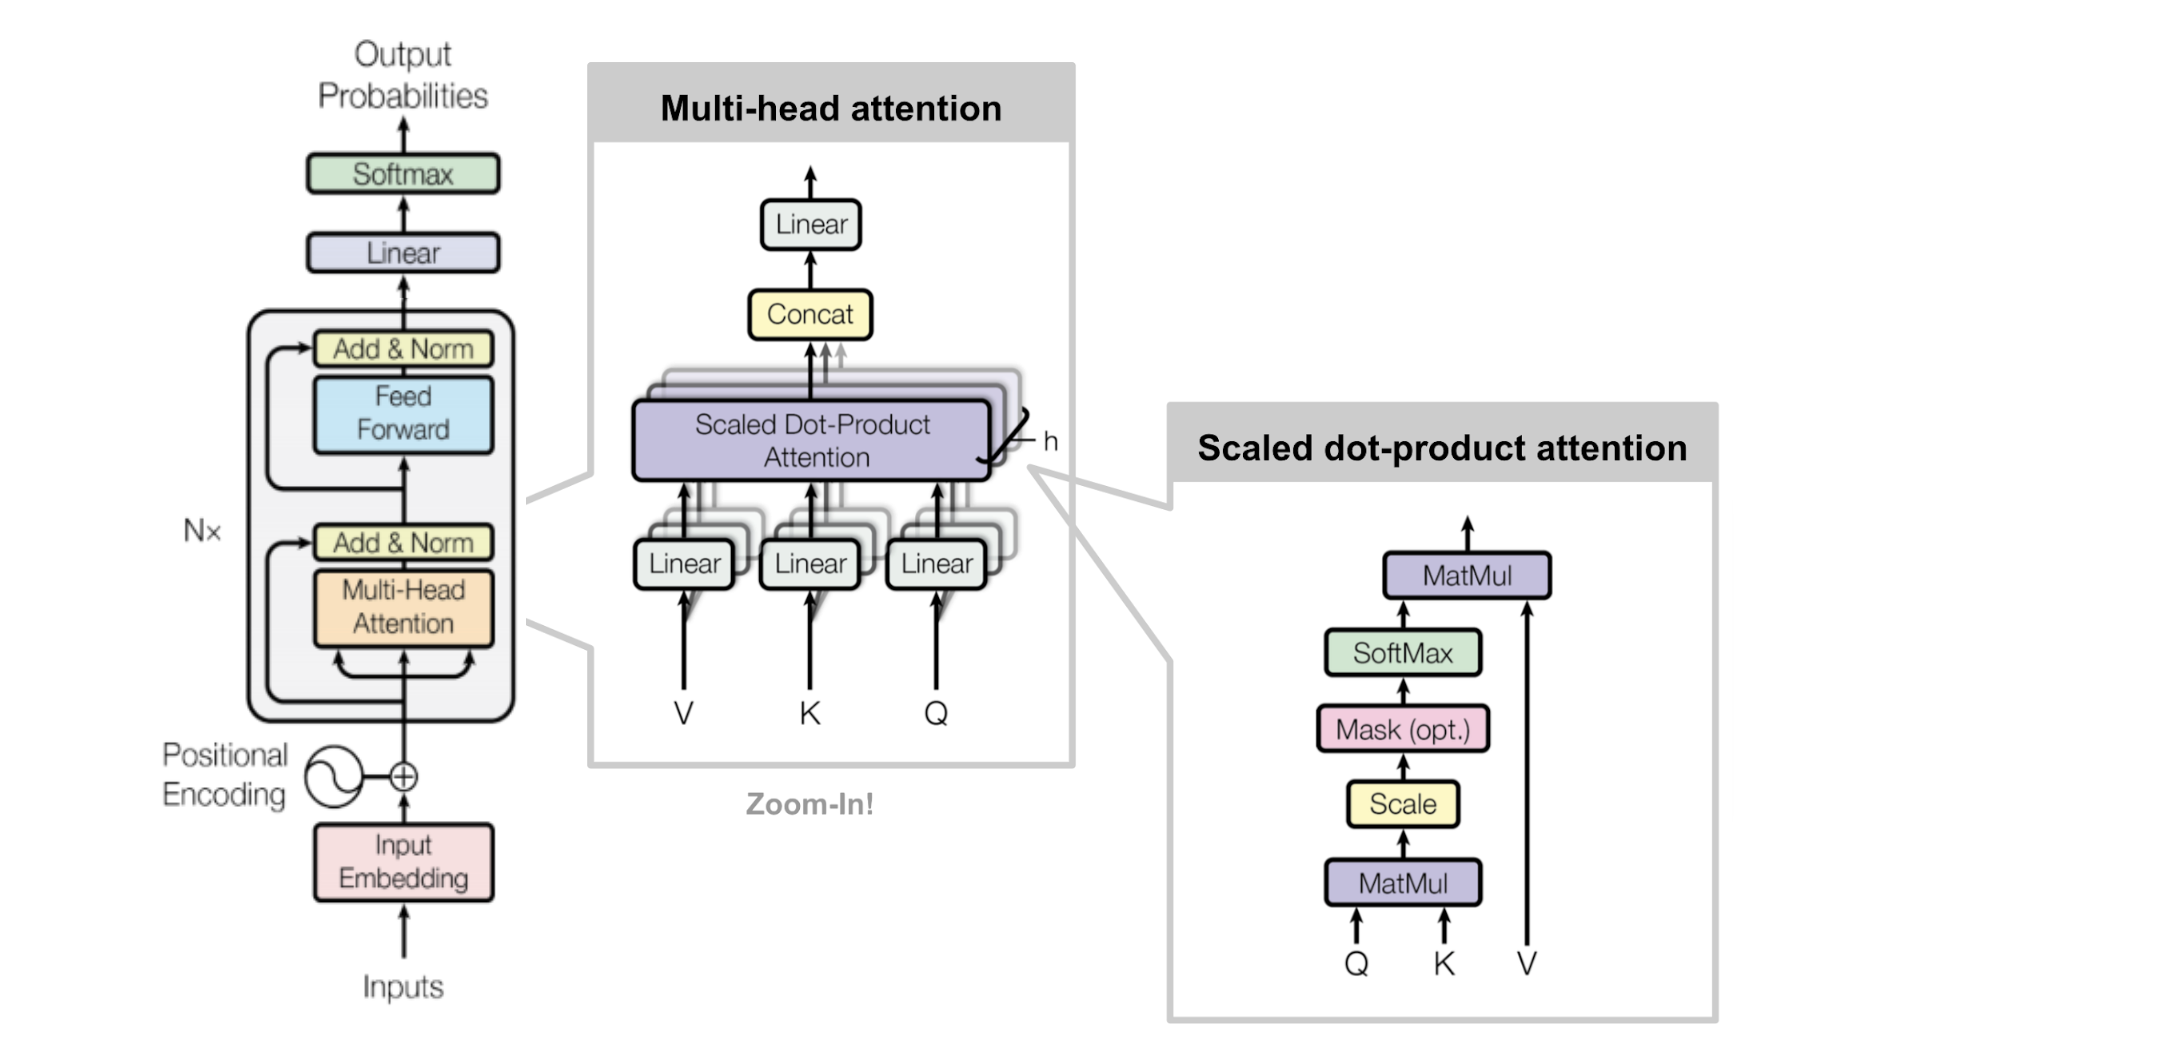

In [ ]:
def create_tensor(t):
    """Create tensor from list of lists"""
    return jnp.array(t)


def display_tensor(t, name):
    """Display shape and tensor"""
    print(f'{name} shape: {t.shape}\n')
    print(f'{t}\n')

Antes de implementarlo usted mismo, puede jugar con un ejemplo de juguete de `atención de producto punto` sin la operación softmax. Técnicamente, no sería "atención de producto punto" sin el softmax, pero esto se hace para evitar revelar demasiado la respuesta y la idea es mostrar estos tensores para darle una idea de cómo se ven.

La fórmula para llamar la atención es esta:

$$
\text { Atención }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}+{M}\right) V\tag{1}\
$$

$d_{k}$ representa la dimensión de consultas y claves.

Los vectores `query`, `key`, `value` y `mask` se proporcionan para este ejemplo.

Tenga en cuenta que el enmascaramiento se realiza con valores muy negativos que producirán un efecto similar al uso de $-\infty $.

In [ ]:
q = create_tensor([[1, 0, 0], [0, 1, 0]])
display_tensor(q, 'query')
k = create_tensor([[1, 2, 3], [4, 5, 6]])
display_tensor(k, 'key')
v = create_tensor([[0, 1, 0], [1, 0, 1]])
display_tensor(v, 'value')
m = create_tensor([[0, 0], [-1e9, 0]])
display_tensor(m, 'mask')

In [ ]:
q_dot_k = q @ k.T / jnp.sqrt(3)
display_tensor(q_dot_k, 'query dot key')

In [ ]:
masked = q_dot_k + m
display_tensor(masked, 'masked query dot key')

In [ ]:
display_tensor(masked @ v, 'masked query dot key dot value')

In [ ]:
q_with_batch = q[None,:]
display_tensor(q_with_batch, 'query with batch dim')
k_with_batch = k[None,:]
display_tensor(k_with_batch, 'key with batch dim')
v_with_batch = v[None,:]
display_tensor(v_with_batch, 'value with batch dim')
m_bool = create_tensor([[True, True], [False, True]])
display_tensor(m_bool, 'boolean mask')

In [ ]:
def DotProductAttention(query, key, value, mask):
    assert query.shape[-1] == key.shape[-1] == value.shape[-1], "Embedding dimensions of q, k, v aren't all the same"
    # Save depth/dimension of the query embedding for scaling down the dot product
    depth = query.shape[-1]

    # Calculate scaled query key dot product according to formula above
    dots = jnp.matmul(query, jnp.swapaxes(key, -1, -2)) / jnp.sqrt(depth)

    # Apply the mask
    if mask is not None: # The 'None' in this line does not need to be replaced
        dots = jnp.where(mask, dots, jnp.full_like(dots, -1e9))

    # Softmax formula implementation
    # Use trax.fastmath.logsumexp of dots to avoid underflow by division by large numbers
    # Hint: Last axis should be used and keepdims should be True
    # Note: softmax = e^(dots - logsumexp(dots)) = E^dots / sumexp(dots)
    logsumexp = trax.fastmath.logsumexp(dots, axis=-1, keepdims=True)

    # Take exponential of dots minus logsumexp to get softmax
    # Use jnp.exp()
    dots = jnp.exp(dots - logsumexp)

    # Multiply dots by value to get self-attention
    # Use jnp.matmul()
    attention = jnp.matmul(dots, value)
    return attention

In [ ]:
DotProductAttention(q_with_batch, k_with_batch, v_with_batch, m_bool)

#### 2.2 Atención Causal

Ahora vas a implementar la atención causal: atención de múltiples cabezas con una máscara para atender solo a las palabras que ocurrieron antes.

In [ ]:
tensor2d = create_tensor(q)
display_tensor(tensor2d, 'query matrix (2D tensor)')

tensor4d2b = create_tensor([[q, q], [q, q]])
display_tensor(tensor4d2b, 'batch of two (multi-head) collections of query matrices (4D tensor)')

tensor3dc = create_tensor([jnp.concatenate([q, q], axis = -1)])
display_tensor(tensor3dc, 'one batch of concatenated heads of query matrices (3d tensor)')

tensor3dc3b = create_tensor([jnp.concatenate([q, q], axis = -1), jnp.concatenate([q, q], axis = -1), jnp.concatenate([q, q], axis = -1)])
display_tensor(tensor3dc3b, 'three batches of concatenated heads of query matrices (3d tensor)')

In [ ]:
def compute_attention_heads_closure(n_heads, d_head):

    def compute_attention_heads(x):

        # Size of the x's batch dimension
        batch_size = x.shape[0]
        # Length of the sequence
        # Should be size of x's first dimension without counting the batch dim
        seqlen = x.shape[1]
        # Reshape x using jnp.reshape()
        # batch_size, seqlen, n_heads*d_head -> batch_size, seqlen, n_heads, d_head
        x = jnp.reshape(x, (batch_size, seqlen, n_heads, d_head))
        # Transpose x using jnp.transpose()
        # batch_size, seqlen, n_heads, d_head -> batch_size, n_heads, seqlen, d_head
        # Note that the values within the tuple are the indexes of the dimensions of x and you must rearrange them
        x = jnp.transpose(x, (0, 2, 1, 3))
        # Reshape x using jnp.reshape()
        # batch_size, n_heads, seqlen, d_head -> batch_size*n_heads, seqlen, d_head
        x = jnp.reshape(x, (-1, seqlen, d_head))

        return x

    return compute_attention_heads

In [ ]:
display_tensor(tensor3dc3b, "input tensor")
result_cah = compute_attention_heads_closure(2,3)(tensor3dc3b)
display_tensor(result_cah, "output tensor")

In [ ]:
def dot_product_self_attention(q, k, v):
    # Hint: mask size should be equal to L_q. Remember that q has shape (batch_size, L_q, d)
    # NOTE: there is a revision underway with the autograder to tolerate better indexing.
    # Until then, please index q.shape using negative values (this is equivalent to counting from right to left)
    mask_size = q.shape[-2]

    # Creates a matrix with ones below the diagonal and 0s above. It should have shape (1, mask_size, mask_size)
    # Notice that 1's and 0's get casted to True/False by setting dtype to jnp.bool_
    # Use jnp.tril() - Lower triangle of an array and jnp.ones()
    mask = jnp.tril(jnp.ones((1, mask_size, mask_size), dtype=jnp.bool_), k=0)

    return DotProductAttention(q, k, v, mask)

In [ ]:
dot_product_self_attention(q_with_batch, k_with_batch, v_with_batch)

In [ ]:
def compute_attention_output_closure(n_heads, d_head):

    def compute_attention_output(x):

        # Length of the sequence
        # Should be size of x's first dimension without counting the batch dim
        seqlen = x.shape[1]
        # Reshape x using jnp.reshape() to shape (batch_size, n_heads, seqlen, d_head)
        x = jnp.reshape(x, ( -1, n_heads, seqlen, d_head))
        # Transpose x using jnp.transpose() to shape (batch_size, seqlen, n_heads, d_head)
        x = jnp.transpose(x, ( 0, 2, 1 , 3))

        # Reshape to allow to concatenate the heads
        return jnp.reshape(x, (-1, seqlen, n_heads * d_head))

    return compute_attention_output

In [ ]:
display_tensor(result_cah, "input tensor")
result_cao = compute_attention_output_closure(2,3)(result_cah)
display_tensor(result_cao, "output tensor")

In [ ]:
def CausalAttention(d_feature,
                    n_heads,
                    compute_attention_heads_closure=compute_attention_heads_closure,
                    dot_product_self_attention=dot_product_self_attention,
                    compute_attention_output_closure=compute_attention_output_closure,
                    mode='train'):
    assert d_feature % n_heads == 0
    d_head = d_feature // n_heads
    # HINT: The second argument to tl.Fn() is an uncalled function (without the parentheses)
    # Since you are dealing with closures you might need to call the outer
    # function with the correct parameters to get the actual uncalled function.
    ComputeAttentionHeads = tl.Fn('AttnHeads', compute_attention_heads_closure(n_heads, d_head), n_out=1)


    return tl.Serial(
        tl.Branch( # creates three towers for one input, takes activations and creates queries keys and values
            [tl.Dense(d_feature), ComputeAttentionHeads], # queries
            [tl.Dense(d_feature), ComputeAttentionHeads], # keys
            [tl.Dense(d_feature), ComputeAttentionHeads], # values
        ),

        tl.Fn('DotProductAttn', dot_product_self_attention, n_out=1), # takes QKV
        # HINT: The second argument to tl.Fn() is an uncalled function
        # Since you are dealing with closures you might need to call the outer
        # function with the correct parameters to get the actual uncalled function.
        tl.Fn('AttnOutput', compute_attention_output_closure(n_heads, d_head), n_out=1), # to allow for parallel
        tl.Dense(d_feature) # Final dense layer
    )

In [ ]:
print(CausalAttention(d_feature=512, n_heads=8))

#### 2.3 Bloque decodificador de transformador

Ahora que ha implementado la parte causal del transformador, implementará el bloque decodificador del transformador. Concretamente estarás implementando esta imagen ahora.

In [ ]:
def DecoderBlock(d_model, d_ff, n_heads,
                 dropout, mode, ff_activation):
    # Create masked multi-head attention block using CausalAttention function
    causal_attention = CausalAttention(
                        d_model,
                        n_heads=n_heads,
                        mode=mode
                        )

    # Create feed-forward block (list) with two dense layers with dropout and input normalized
    feed_forward = [
        # Normalize layer inputs
        tl.LayerNorm(),
        # Add first feed forward (dense) layer (don't forget to set the correct value for n_units)
        tl.Dense(d_ff),
        # Add activation function passed in as a parameter (you need to call it!)
        ff_activation(), # Generally ReLU
        # Add dropout with rate and mode specified (i.e., don't use dropout during evaluation)
        tl.Dropout(rate=dropout, mode=mode),
        # Add second feed forward layer (don't forget to set the correct value for n_units)
        tl.Dense(d_model),
        # Add dropout with rate and mode specified (i.e., don't use dropout during evaluation)
        tl.Dropout(rate=dropout,mode=mode)
    ]

    # Add list of two Residual blocks: the attention with normalization and dropout and feed-forward blocks
    return [
      tl.Residual(
          # Normalize layer input
          tl.LayerNorm(),
          # Add causal attention block previously defined (without parentheses)
          causal_attention,
          # Add dropout with rate and mode specified
          tl.Dropout(rate=dropout, mode=mode)
        ),
      tl.Residual(
          # Add feed forward block (without parentheses)
          feed_forward
        ),
      ]

In [ ]:
print(DecoderBlock(d_model=512, d_ff=2048, n_heads=8, dropout=0.1, mode='train', ff_activation=tl.Relu))

#### 2.4 Modelo de lenguaje transformador

Ahora lo reunirás todo. En esta parte, utilizará todos los subcomponentes que construyó previamente para hacer el modelo final. Concretamente, aquí está la imagen que implementará.

In [ ]:
def TransformerLM(vocab_size=33300,
                  d_model=512,
                  d_ff=2048,
                  n_layers=6,
                  n_heads=8,
                  dropout=0.1,
                  max_len=4096,
                  mode='train',
                  ff_activation=tl.Relu):

    # Embedding inputs and positional encoder
    positional_encoder = [
        # Add embedding layer of dimension (vocab_size, d_model)
        tl.Embedding(vocab_size, d_model),
        # Use dropout with rate and mode specified
        tl.Dropout(rate=dropout, mode=mode),
        # Add positional encoding layer with maximum input length and mode specified
        tl.PositionalEncoding(max_len=max_len, mode=mode)]

    # Create stack (list) of decoder blocks with n_layers with necessary parameters
    decoder_blocks = [
        DecoderBlock(d_model, d_ff, n_heads,
                    dropout, mode, ff_activation) for _ in range(n_layers)]

    # Create the complete model as written in the figure
    return tl.Serial(
        # Use teacher forcing (feed output of previous step to current step)
        tl.ShiftRight(mode=mode), # Specify the mode!
        # Add positional encoder
        positional_encoder,
        # Add decoder blocks
        decoder_blocks,
        # Normalize layer
        tl.LayerNorm(),

        # Add dense layer of vocab_size (since need to select a word to translate to)
        # (a.k.a., logits layer. Note: activation already set by ff_activation)
        tl.Dense(vocab_size),
        # Get probabilities with Logsoftmax
        tl.LogSoftmax()
    )

In [ ]:
print(TransformerLM(n_layers=1))

### Parte 3: Entrenamiento

Ahora vas a entrenar tu modelo. Como de costumbre, debe definir la función de costo, el optimizador, y decidir si lo entrenará en un `gpu` o `cpu`. En este caso, entrenará su modelo en una CPU durante unos pocos pasos y lo cargaremos en un modelo previamente entrenado que puede usar para predecir con sus propias palabras.

In [ ]:
from trax.supervised import training

def training_loop(TransformerLM, train_gen, eval_gen, output_dir = "/content/drive/MyDrive/NLP/model_4"):
    output_dir = os.path.expanduser(output_dir)  # trainer is an object
    lr_schedule = trax.lr.warmup_and_rsqrt_decay(n_warmup_steps=1000, max_value=0.01)

    train_task = training.TrainTask(
      labeled_data=train_gen, # The training generator
      loss_layer=tl.CrossEntropyLoss(), # Loss function
      optimizer=trax.optimizers.Adam(0.01), # Optimizer (Don't forget to set LR to 0.01)
      lr_schedule=lr_schedule,
      n_steps_per_checkpoint=10
    )

    eval_task = training.EvalTask(
      labeled_data=eval_gen, # The evaluation generator
      metrics=[tl.CrossEntropyLoss(), tl.Accuracy()] # CrossEntropyLoss and Accuracy
    )


    loop = training.Loop(TransformerLM(d_model=4,
                                       d_ff=16,
                                       n_layers=1,
                                       n_heads=2,
                                       mode='train'),
                         train_task,
                         eval_tasks=[eval_task],
                         output_dir=output_dir)

    return loop

In [ ]:
!rm -f /content/drive/MyDrive/NLP/model_4/model.pkl.gz
loop = training_loop(TransformerLM, train_batch_stream, eval_batch_stream)
loop.run(700)

#### Parte 4: Evaluación

In [ ]:
model = TransformerLM(mode='eval')

# Load the pre-trained weights
model.init_from_file('/content/model_4/model.pkl.gz', weights_only=True)

### Parte 5: Prueba con tu propia entrada

In [ ]:
def next_symbol(cur_output_tokens, model):
    # current output tokens length
    token_length = len(cur_output_tokens)
    # calculate the minimum power of 2 big enough to store token_length
    # HINT: use np.ceil() and np.log2()
    # add 1 to token_length so np.log2() doesn't receive 0 when token_length is 0
    padded_length = 2**int(np.ceil(np.log2(token_length + 1)))

    # Fill cur_output_tokens with 0's until it reaches padded_length
    padded = cur_output_tokens + [0] * (padded_length - token_length)
    padded_with_batch = np.array(padded)[None, :] # Don't replace this 'None'! This is a way of setting the batch dim

    # model expects a tuple containing two padded tensors (with batch)
    output, _ = model((padded_with_batch, padded_with_batch))
    # HINT: output has shape (1, padded_length, vocab_size)
    # To get log_probs you need to index output with 0 in the first dim
    # token_length in the second dim and all of the entries for the last dim.
    log_probs = output[0, token_length, :]


    return int(np.argmax(log_probs))

In [ ]:
sentence_test_nxt_symbl = "I want to fly in the sky."
detokenize([next_symbol(tokenize(sentence_test_nxt_symbl)+[0], model)])

#### 5.1 Decodificación codiciosa

Ahora implementará el algoritmo greedy_decode que llamará a la función `next_symbol`. Toma input_sentence, el modelo entrenado y devuelve la oración decodificada.

In [ ]:
def greedy_decode(input_sentence, model):
    # Use tokenize()
    cur_output_tokens = tokenize(input_sentence) + [0]
    generated_output = []
    cur_output = 0
    EOS = 1

    while cur_output != EOS:
        # Get next symbol
        cur_output = next_symbol(cur_output_tokens, model)
        # Append next symbol to original sentence
        cur_output_tokens.append(cur_output)
        # Append next symbol to generated sentence
        generated_output.append(cur_output)
        print(detokenize(generated_output))

    return detokenize(generated_output)

In [ ]:
test_sentence = "It was a sunny day when I went to the market to buy some flowers. But I only found roses, not tulips."
print(wrapper.fill(test_sentence), '\n')
print(greedy_decode(test_sentence, model))